In [1]:
# essential
import numpy as np
np.random.seed(67) 

# keras
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.initializers import RandomNormal
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.losses import CategoricalCrossentropy

#sklearn
from sklearn.preprocessing import normalize
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
from dipy.viz import actor, window

# others
import utils.bundleTools3 as BT
import utils.bundleTools as bt
import time
from dipy.segment.metric import mdf
from dipy.segment.clustering import QuickBundles
import pickle
import hdbscan
from collections import defaultdict
from MulticoreTSNE import MulticoreTSNE as TSNE
import random
import time



Using TensorFlow backend.
/home/fondecyt-1190701/anaconda3/envs/python36/lib/python3.6/site-packages/dipy/viz/window.py:12: FutureWarning: We no longer carry a copy of the 'py3k' module in nibabel; Please import from the 'numpy.compat.py3k' module directly. Full removal scheduled for nibabel 4.0.
  from nibabel.py3k import asbytes


In [2]:
def display(streamlines, clusters=False, ids=False, colors=False, hd=False):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    if clusters:
        colormap = actor.create_colormap(np.arange(len(ids)))#, name='hot')
        #print(colormap)
        #random.shuffle(colormap)
        stream = []
        colors = []
        num = 0
        for i,id_ in enumerate(ids):
            for streamline in clusters[id_]:
                stream.append(streamlines[streamline])
                colors.append(colormap[num]*len(streamlines[streamline]))
            num+=1
        if(hd):
            ren.add(actor.streamtube(stream, colors))
        else:
            ren.add(actor.line(stream, colors))
            
    else:
        if colors:
            ren.add(actor.line(streamlines, colors))
        else:
            ren.add(actor.line(streamlines))
    
    window.show(ren, size=(1200, 900))

In [3]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [4]:
def pairwise_matrix(streamlines):
    n = len(streamlines)
    matrix = []
    for line in streamlines:
        fas = []
        for l in streamlines:
            fas.append(mdf(line, l))
        matrix.append(fas)
    return matrix

def pairwise_matrix2(streamlines):
    n = len(streamlines)
    matrix = []
    for fiber in streamlines:
        fas = []
        for fiber2 in streamlines:
            a = abs(np.linalg.norm(fiber2-fiber))
            b = abs(np.linalg.norm(fiber2-np.flip(fiber, axis=0)))
            fas.append(min(a,b))
        matrix.append(fas)
    return matrix

In [5]:
def load_data(path, file_format='bundle'):
    print('loading ', end='')
    if file_format == 'bundle': 
        data = np.array(BT.read_bundle_severalbundles(path)[0][0])
    else:
        data = np.load(path)
    print('size: ', len(data))
    # normalize to 0-1
    print('normalizing...')
    
    xmin, xmax = -89.88333, 114.81356
    data = (data - xmin)/(xmax - xmin)
    #print('orientation...')
    #for i, fiber in enumerate(data):
    #    if np.mean(fiber[0]) > np.mean(fiber[-1]):
    #        data[i] = np.flip(data[i], axis=0)
    return data
    

In [6]:
def load_subject(subject):
    if subject < 9:
        subject_id = '00'+str(num)
    else:
        subject_id = '0'+str(num)

    for j in range(3):
        filename = "data/79subjects/"+subject_id+"/"+subject_id+"_"+str(j+1)+"_3/"+subject_id+"_bundlesTal_21pts.bundles"
        data = load_data(filename)
        

In [7]:
def load_and_predict(subjects, encoder, return_data=False):
    if (min(subjects) < 1 or max(subjects) > 79):
        print("Select a range between 1 and 79")
        return
    full_size = 0
    for i, subject in enumerate(subjects):
        if subject < 9:
            subject_id = '00'+str(subject)
        else:
            subject_id = '0'+str(subject)
        for j in range(3):
            filename = "data/79subjects/"+subject_id+"/"+subject_id+"_"+str(j+1)+"_3/"+subject_id+"_bundlesTal_21pts.bundles"
            data = load_data(filename)
            full_size += (data.size * data.itemsize)
            if i == 0 and j == 0:
                if return_data:
                    full_data = data
                latent_space = encoder.predict(data)
            else:
                if return_data:
                    full_data = np.concatenate((full_data, data), axis=0)
                latent_space = np.concatenate((latent_space,encoder.predict(data)), axis=0)
    print('compressed from ', full_size/1000000, ' to ', (latent_space.size * latent_space.itemsize)/1000000, 'mbytes')
    if return_data:
        return full_data, latent_space
    else:
        return latent_space

### Autoencoder LSTM model

In [8]:
from keras.layers import Bidirectional, LSTM, RepeatVector

In [9]:
from dipy.segment.metric import mdf
import keras.backend as K
def mdf_loss(y_true, y_pred):
    normal = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    inverted = K.sqrt(K.sum(K.square(y_pred - K.reverse(y_true,axes=0)), axis=-1))
    loss=K.minimum(K.sum(normal)/21,K.sum(inverted)/21)
    return loss

In [19]:
from keras.layers import Reshape

inputs = Input(shape=(21, 3))

encoder = LSTM(128, return_sequences=True, activation = 'relu')(inputs)
#encoder = Dropout(0.4)(encoder)
encoder = LSTM(64, return_sequences=True, activation = 'relu')(encoder)
#encoder = Dropout(0.4)(encoder)
encoder = LSTM(11, return_sequences=False, activation = 'relu')(encoder)

decoder = RepeatVector(21)(encoder)

#decoder = Dropout(0.4)(decoder)
decoder = LSTM(64, return_sequences=True, activation = 'relu')(decoder)
#decoder = Dropout(0.4)(decoder)
decoder = LSTM(128, return_sequences=True, activation = 'relu')(decoder)
decoder = LSTM(3, return_sequences=True, activation = 'relu')(decoder)

sequence_encoder = Model(inputs, encoder)
sequence_autoencoder = Model(inputs, decoder)
sequence_autoencoder.summary()

sequence_autoencoder.compile(loss = mdf_loss, optimizer='adam', metrics=['acc'])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 128)           67584     
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 64)            49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 11)                3344      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 11)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 64)            19456     
_________________________________________________________________
lstm_5 (LSTM)                (None, 21, 128)           9881

In [10]:
from keras.models import load_model
sequence_autoencoder = load_model('checkpoints/loop_latent_11_mdf_noflip_try_12.h5', custom_objects = {'mdf_loss': mdf_loss})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [12]:
#history = [0]*8
for i in range(15,16):
    x_train, x_test = train_test_split(load_data('data/autoencoder_training/'+str(i)+'.bundles'), test_size=0.2, shuffle=True)
    sequence_autoencoder.fit(x_train, x_train, epochs=1, batch_size=512, shuffle=True, validation_data=(x_test,x_test))
    #history[i] = sequence_autoencoder.fit(x_train, x_train, epochs=1, batch_size=512, shuffle=True, validation_data=(x_test,x_test))
    sequence_autoencoder.save('checkpoints/loop_latent_11_mdf_noflip_try_' + str(i) + '.h5')

loading data/autoencoder_training/15.bundlesdata
size:  2819426
normalizing...
Train on 2255540 samples, validate on 563886 samples
Epoch 1/1
2255540/2255540 [==============================] - 1436s 637us/step - loss: 7.8931 - acc: 0.9738 - val_loss: 8.3523 - val_acc: 0.9724


In [13]:
sequence_autoencoder.save('checkpoints/autoencoder_79subjects_11latent_noflip_mdfloss.h5')
#sequence_encoder.save('checkpoints/encoder_79subjects_11latent_mdfloss.h5')

In [58]:
lat = sequence_encoder.predict(data)
rec = sequence_autoencoder.predict(data)

In [16]:
data = load_data('data/autoencoder_training/test.bundles')

loading data/autoencoder_training/test.bundlesdata
size:  704422
normalizing...
[0.51170284 0.67373836 0.03458684]
[0.57064474 0.73623055 0.07840349]
[0.5959679  0.7148575  0.07370447]
[0.7493181  0.40035623 0.60222346]
[0.7333169  0.41379303 0.6096108 ]
[0.68398744 0.35467514 0.59899384]
[0.760694   0.551263   0.58034617]
[0.7153373 0.5009536 0.5542462]
[0.75781995 0.5571515  0.5822462 ]
[0.7569384  0.5631065  0.58741844]
[0.7756069  0.5428158  0.32374525]
[0.75413096 0.5568463  0.5855035 ]
[0.7697857  0.5584722  0.31980297]
[0.7824701  0.6172207  0.28188056]
[0.14606312 0.50600845 0.549651  ]
[0.14314973 0.61798084 0.33162394]
[0.15916477 0.62008685 0.30661368]
[0.17277029 0.6199347  0.30616874]
[0.15719977 0.58661234 0.3775784 ]
[0.09615811 0.6033523  0.3075704 ]
[0.14364764 0.59286547 0.36271524]
[0.16161135 0.59158194 0.37038368]
[0.10714718 0.612143   0.30753592]
[0.08649405 0.6353742  0.5377426 ]
[0.07331207 0.5255138  0.49735755]
[0.13376543 0.7185837  0.25046006]
[0.44130352 0

[0.3852717  0.80026495 0.5182976 ]
[0.45451373 0.8268973  0.24382704]
[0.47673073 0.8010357  0.25918052]
[0.4659595  0.6893142  0.28114355]
[0.4948427  0.84839606 0.16337699]
[0.52226764 0.813706   0.13295466]
[0.6015836 0.7711278 0.1185191]
[0.6920116  0.7968652  0.22117312]
[0.68752617 0.7352814  0.18831377]
[0.7980046 0.5877052 0.5483623]
[0.6810468  0.7442318  0.18839848]
[0.6982755  0.7045341  0.18712595]
[0.69171643 0.70970017 0.17724094]
[0.6437041 0.8388757 0.2511318]
[0.6684143  0.69424206 0.21122274]
[0.69861984 0.7030144  0.25130826]
[0.7191681  0.71669185 0.23979187]
[0.731123   0.6984374  0.20731398]
[0.6871224  0.72372997 0.16605686]
[0.73250294 0.70918137 0.22512819]
[0.7394218  0.7163391  0.23280123]
[0.7499734  0.69897735 0.2555948 ]
[0.7315701  0.70340353 0.23153567]
[0.73337483 0.7076745  0.22930916]
[0.7464259  0.551931   0.57862955]
[0.11546353 0.7023498  0.29855072]
[0.76447564 0.6903944  0.30628988]
[0.7656839  0.6692673  0.28218403]
[0.18339163 0.787904   0.2667

[0.567085   0.6938662  0.37371352]
[0.43614182 0.7653187  0.38799524]
[0.61248386 0.8650175  0.26567954]
[0.6809118  0.83495843 0.4123877 ]
[0.52193487 0.880136   0.24687293]
[0.4040088 0.96362   0.3873444]
[0.2663125 0.8832984 0.277805 ]
[0.2598854  0.8835349  0.27803642]
[0.39484757 0.95046467 0.3699844 ]
[0.6192589  0.8649299  0.26530036]
[0.32571623 0.90557796 0.3120681 ]
[0.3358327 0.8797332 0.2762197]
[0.17104505 0.7269672  0.688908  ]
[0.39309594 0.88785005 0.22998497]
[0.17545767 0.68400615 0.6947637 ]
[0.21953917 0.78222156 0.7021627 ]
[0.52027947 0.9081092  0.27582905]
[0.4187287 0.8722787 0.6445986]
[0.53069973 0.9454402  0.44883263]
[0.44188553 0.87453735 0.26954168]
[0.5751429  0.70167845 0.37034774]
[0.55008775 0.9633981  0.3909977 ]
[0.70765764 0.7788627  0.6081023 ]
[0.5462014  0.9373613  0.51008946]
[0.6124081 0.8701026 0.2653596]
[0.6191328  0.87006044 0.2649838 ]
[0.26653442 0.88857794 0.27734068]
[0.31108356 0.90091866 0.28273487]
[0.5887052  0.6072764  0.42402565]


[0.72634387 0.29488024 0.2881275 ]
[0.6359389  0.30867305 0.6138827 ]
[0.7334564  0.2917855  0.28439438]
[0.7280957  0.29080752 0.28647408]
[0.3373279  0.36788923 0.09497511]
[0.13066335 0.44459438 0.2669799 ]
[0.6359404  0.20006143 0.29506293]
[0.668041   0.15950882 0.36829874]
[0.14992183 0.2665743  0.34450606]
[0.14519462 0.27247766 0.35610673]
[0.14807421 0.24586359 0.4055222 ]
[0.13626944 0.28054306 0.3762883 ]
[0.61661303 0.15682805 0.30780146]
[0.15040337 0.265687   0.40787327]
[0.3591542  0.31549183 0.3512854 ]
[0.3965999  0.57681614 0.68718994]
[0.43347526 0.5866086  0.49294758]
[0.41746163 0.8706428  0.61778736]
[0.42019612 0.4035734  0.3230068 ]
[0.61778575 0.14944382 0.31032896]
[0.59015137 0.13044986 0.26349092]
[0.6225519  0.142114   0.29624167]
[0.6331578 0.1931278 0.2836855]
[0.40276796 0.31750253 0.33304793]
[0.4093657  0.31663206 0.33268178]
[0.4752719  0.17093877 0.1838609 ]
[0.42487893 0.31580368 0.3315165 ]
[0.46044913 0.17486933 0.18902445]
[0.5494864  0.22705266 

[0.12202111 0.41194996 0.37655616]
[0.39104947 0.5902474  0.6573555 ]
[0.12470005 0.42812133 0.37553358]
[0.11363237 0.42961556 0.38398355]
[0.10861631 0.4349553  0.38688663]
[0.12724777 0.42577645 0.38353577]
[0.15594165 0.426767   0.37358657]
[0.18368858 0.38971213 0.4448412 ]
[0.35474145 0.12230482 0.48173216]
[0.3401146  0.13187476 0.47750467]
[0.15058307 0.5153997  0.5461509 ]
[0.706889   0.7744826  0.61645395]
[0.43335402 0.407019   0.5117989 ]
[0.4334135 0.5901956 0.5008895]
[0.48654112 0.57781243 0.6795268 ]
[0.35949335 0.4941219  0.29614425]
[0.41649726 0.4511197  0.3157361 ]
[0.563169   0.57519555 0.05290874]
[0.56418496 0.5758885  0.05567698]
[0.5905109 0.7283829 0.0656826]
[0.56377083 0.575081   0.05319181]
[0.6251313 0.4791824 0.5155225]
[0.44862238 0.5929616  0.6983143 ]
[0.59130293 0.9044442  0.2965872 ]
[0.459658   0.41140896 0.4959175 ]
[0.6199974  0.30816647 0.596215  ]
[0.44947696 0.58762634 0.7028554 ]
[0.41881296 0.39995068 0.41862312]
[0.495199   0.4939161  0.0463

[0.15791807 0.5846256  0.36338204]
[0.15835994 0.58160245 0.37734795]
[0.16135724 0.5857422  0.3735203 ]
[0.16838975 0.5851388  0.37055457]
[0.16995849 0.58560234 0.36296672]
[0.155177   0.5862714  0.37322664]
[0.16247977 0.5812224  0.36907554]
[0.16088271 0.58601576 0.3649609 ]
[0.14787872 0.5964604  0.35774845]
[0.09620421 0.6375794  0.5326434 ]
[0.40300918 0.596053   0.70932025]
[0.4459086  0.68970287 0.17952898]
[0.44944575 0.6928508  0.15732463]
[0.44927484 0.6901256  0.16817065]
[0.4601883  0.6919241  0.17072998]
[0.4391531  0.72465116 0.16608052]
[0.43591142 0.72077984 0.16269234]
[0.46029902 0.69242525 0.18634671]
[0.44481397 0.7190676  0.15873395]
[0.4471962  0.7231286  0.16332603]
[0.45954895 0.6925428  0.18166575]
[0.44617108 0.6894847  0.17608784]
[0.4810373  0.7550337  0.09788819]
[0.42094553 0.71994525 0.09137131]
[0.50689304 0.6840901  0.03021745]
[0.39114144 0.58143365 0.3228553 ]
[0.46602866 0.57596666 0.32409286]
[0.47773263 0.67118216 0.03464715]
[0.50206375 0.684551

[0.4312616  0.81540436 0.28247717]
[0.5462725 0.5494067 0.4691328]
[0.45029092 0.8294062  0.2229356 ]
[0.47768423 0.77739346 0.29423434]
[0.48059624 0.82817626 0.23690324]
[0.51518214 0.75519866 0.29418436]
[0.4816822  0.90114176 0.34232357]
[0.53011185 0.85669667 0.18098302]
[0.689217   0.799265   0.22976266]
[0.5218033 0.581825  0.5114015]
[0.6828868  0.78928363 0.22613262]
[0.78912914 0.5971805  0.5431564 ]
[0.80749595 0.594807   0.5433319 ]
[0.7917114  0.6974877  0.48263365]
[0.1509005  0.76554406 0.29059798]
[0.16111694 0.772047   0.28669682]
[0.17855765 0.7862891  0.26586694]
[0.15835184 0.7340887  0.3065171 ]
[0.21778505 0.8006338  0.22000632]
[0.22751062 0.8032699  0.1938722 ]
[0.22811101 0.7961279  0.215864  ]
[0.24548918 0.8091193  0.20096228]
[0.29608303 0.84479487 0.20258613]
[0.28991386 0.85487306 0.21100394]
[0.32435822 0.9132762  0.3045554 ]
[0.23593313 0.7999454  0.1926856 ]
[0.32719117 0.9066037  0.3127146 ]
[0.4200182 0.862969  0.228567 ]
[0.40841362 0.8586073  0.2095

[0.4698913  0.08889934 0.34767792]
[0.45458907 0.15508123 0.34487933]
[0.42448068 0.1569431  0.3494602 ]
[0.47206697 0.07840557 0.42368135]
[0.43449584 0.1329104  0.3259314 ]
[0.44363746 0.1353547  0.31725135]
[0.45042694 0.12220407 0.30134407]
[0.43188462 0.15297404 0.34763652]
[0.44152635 0.14866424 0.3371348 ]
[0.49299696 0.10170123 0.34240803]
[0.5193707  0.88555086 0.5144443 ]
[0.46645793 0.08700546 0.3466833 ]
[0.5510919  0.93847007 0.5062386 ]
[0.5641082 0.9465816 0.5016364]
[0.59571177 0.11330885 0.3357948 ]
[0.6147777  0.13626409 0.3307973 ]
[0.11867531 0.37532225 0.3215615 ]
[0.65391606 0.86779416 0.30648595]
[0.54822093 0.9356374  0.5065545 ]
[0.42689258 0.333581   0.37760696]
[0.38632074 0.5070034  0.2976317 ]
[0.34660396 0.53427243 0.03609743]
[0.2751866  0.17123461 0.35013518]
[0.4874412  0.284396   0.38995716]
[0.27264866 0.11749219 0.36458695]
[0.29383686 0.13259771 0.36060515]
[0.47390568 0.09033374 0.34780806]
[0.46093714 0.08999383 0.34651157]
[0.47160724 0.0940274  

[0.63626295 0.30827087 0.60796565]
[0.7457743  0.40184805 0.30087274]
[0.43265882 0.5740994  0.7089061 ]
[0.4887418 0.5803706 0.7029559]
[0.43342862 0.6230524  0.6957382 ]
[0.751061   0.33241144 0.33461922]
[0.73511606 0.3274202  0.3299339 ]
[0.7429077  0.32420093 0.32610792]
[0.73579574 0.33229202 0.31933528]
[0.74229175 0.33566087 0.32019114]
[0.7502103 0.3219459 0.3237748]
[0.4333264  0.85617065 0.60685575]
[0.73224086 0.33701375 0.32428545]
[0.73699546 0.34179506 0.32204568]
[0.7430412  0.33757442 0.32028067]
[0.6127629  0.89365214 0.2943189 ]
[0.10855009 0.35802847 0.34267572]
[0.11438053 0.35886452 0.33993253]
[0.12728873 0.35930017 0.34035456]
[0.1261173  0.36978608 0.32406634]
[0.11974701 0.3590306  0.34399492]
[0.12616554 0.35710672 0.34560516]
[0.11336011 0.3608807  0.3421608 ]
[0.13405117 0.35543814 0.3545181 ]
[0.11613643 0.35757408 0.34743717]
[0.62723017 0.13032243 0.31363916]
[0.12902367 0.3536987  0.3503321 ]
[0.13543548 0.35154653 0.35182598]
[0.7252987  0.29523984 0.2

[0.5999112  0.9363866  0.36009565]
[0.74227154 0.44052953 0.36739087]
[0.73559517 0.3652401  0.30974108]
[0.6548923  0.86870295 0.30584913]
[0.7465214  0.4483487  0.37941435]
[0.73739713 0.44373834 0.38129392]
[0.7478538  0.44211525 0.38287097]
[0.76148033 0.5855621  0.21077344]
[0.2092454  0.70506996 0.15884268]
[0.23408134 0.71338445 0.1283439 ]
[0.1511847  0.69806606 0.24372406]
[0.20769106 0.35734758 0.4563576 ]
[0.12291164 0.44138643 0.40138176]
[0.21394484 0.38063774 0.4620344 ]
[0.10996596 0.4442805  0.38304967]
[0.20474763 0.43048486 0.43684578]
[0.19491394 0.43424267 0.43135107]
[0.13335116 0.48948228 0.4098336 ]
[0.12670824 0.54706943 0.21241018]
[0.40043995 0.58843255 0.65946895]
[0.08568869 0.5290025  0.59065235]
[0.12811297 0.42835408 0.31273794]
[0.4366233  0.58667564 0.4954695 ]
[0.3954966  0.58459234 0.69780785]
[0.7289621 0.3101977 0.292505 ]
[0.17356052 0.7020933  0.69345224]
[0.36808938 0.659597   0.03479374]
[0.5597211  0.6148522  0.38008654]
[0.5871878 0.6086925 0.

[0.11259443 0.7216475  0.510967  ]
[0.7736134  0.63681257 0.29274702]
[0.10742709 0.65518653 0.36061928]
[0.09366538 0.66324234 0.37273505]
[0.09742282 0.6715127  0.37128028]
[0.09504861 0.68882704 0.38001359]
[0.57844937 0.6121112  0.412308  ]
[0.22494432 0.6081893  0.529672  ]
[0.63420445 0.31515917 0.61646104]
[0.41314533 0.402957   0.50969994]
[0.38935095 0.6125828  0.5719415 ]
[0.3695493  0.5703495  0.47968915]
[0.3222348  0.7963778  0.13397408]
[0.4404952  0.82075393 0.23297061]
[0.44372436 0.81849647 0.24078009]
[0.3808422 0.6102951 0.463125 ]
[0.42423272 0.7140414  0.38496393]
[0.40538242 0.79675394 0.1207639 ]
[0.45448533 0.7145932  0.38689414]
[0.48422897 0.61377895 0.44895676]
[0.45597833 0.7150879  0.38396546]
[0.49650866 0.8318245  0.15960163]
[0.4743002  0.68627197 0.39130062]
[0.44244185 0.82550955 0.21879338]
[0.46576175 0.76526874 0.10294465]
[0.5470222  0.77316785 0.10461342]
[0.59413344 0.76125145 0.10417759]
[0.6151578  0.76975316 0.12708846]
[0.7272968 0.7793324 0.

[0.33053166 0.87946993 0.2464777 ]
[0.36375514 0.8524308  0.25143382]
[0.35933352 0.8542476  0.20733982]
[0.38861316 0.82634974 0.2904281 ]
[0.3944914  0.8260928  0.29120496]
[0.5285887  0.86185515 0.22815225]
[0.58560914 0.8668943  0.23414865]
[0.5422505  0.86487716 0.23382583]
[0.6299308  0.85290504 0.25319645]
[0.6559418  0.8272696  0.26179975]
[0.6709189  0.8245504  0.26815653]
[0.6846819  0.8143281  0.27819157]
[0.22460055 0.8366243  0.29469302]
[0.42422765 0.5715706  0.7093604 ]
[0.16192184 0.76320225 0.51976585]
[0.16553904 0.7581545  0.51312214]
[0.14813867 0.76950574 0.5019685 ]
[0.41879153 0.9535977  0.51819444]
[0.32207042 0.89070106 0.28879702]
[0.32981402 0.9141087  0.2773015 ]
[0.31248745 0.8334008  0.29250628]
[0.3983646 0.7820692 0.5815535]
[0.5936551 0.8947707 0.2973215]
[0.42680967 0.8268775  0.287185  ]
[0.49844164 0.8590328  0.22016522]
[0.50992674 0.8648361  0.22449894]
[0.58584315 0.8724108  0.23400423]
[0.6347149  0.8482698  0.24074483]
[0.65682757 0.83306134 0.2

[0.4490929 0.7614022 0.2634705]
[0.4269828  0.6573323  0.22337273]
[0.58467597 0.31295365 0.5914366 ]
[0.4048263  0.29829186 0.34303212]
[0.6102125  0.14553957 0.29362923]
[0.43857816 0.42132062 0.24377178]
[0.44821995 0.5957479  0.2688963 ]
[0.12538506 0.3357475  0.35984236]
[0.5739446  0.13118184 0.27534103]
[0.57797605 0.1310555  0.27082273]
[0.4154067  0.44222784 0.3116352 ]
[0.4582143  0.6091843  0.47529104]
[0.43753138 0.5983034  0.46132967]
[0.48768353 0.5744928  0.4386685 ]
[0.6857517  0.24565227 0.3801624 ]
[0.69715184 0.23739856 0.37626678]
[0.67998165 0.24930513 0.37717855]
[0.5029073 0.5741859 0.4452229]
[0.7149082  0.22348236 0.3521179 ]
[0.68290716 0.22197448 0.32633188]
[0.6823048  0.21649463 0.32948858]
[0.6923887  0.21971971 0.33487687]
[0.6890025 0.2185558 0.3332232]
[0.36930442 0.51886874 0.04565783]
[0.21848528 0.886166   0.45811906]
[0.67785674 0.27159646 0.22930974]
[0.6146941  0.15263261 0.3119456 ]
[0.15907402 0.27198783 0.34726644]
[0.11732432 0.37111348 0.3213

[0.4061426  0.6006758  0.42220688]
[0.39514047 0.60335785 0.4238355 ]
[0.3565227  0.49223226 0.288895  ]
[0.42401263 0.936472   0.5250803 ]
[0.44521657 0.39377886 0.46154648]
[0.45617306 0.7955428  0.49477902]
[0.4618012 0.4068209 0.4934538]
[0.49415666 0.45105693 0.31083   ]
[0.49480578 0.50691664 0.30654553]
[0.43392646 0.4774714  0.46304023]
[0.42091852 0.49697927 0.48676375]
[0.48584354 0.5908233  0.6951345 ]
[0.4603328  0.41037956 0.4918628 ]
[0.59669197 0.44281107 0.08160431]
[0.6226477  0.64466316 0.06484327]
[0.717098   0.40297174 0.41650683]
[0.6893718 0.7585487 0.4996455]
[0.7374303  0.37487397 0.39014348]
[0.7321903  0.40186864 0.31728   ]
[0.7792286 0.6401664 0.2764937]
[0.7723926  0.6480963  0.24045058]
[0.752601   0.42630574 0.31658712]
[0.41020718 0.8619838  0.60403603]
[0.43763727 0.58006644 0.7136316 ]
[0.11762413 0.44318038 0.3321038 ]
[0.7473373  0.40158963 0.39057624]
[0.28116047 0.44833252 0.468211  ]
[0.12218581 0.44748896 0.3282134 ]
[0.10516023 0.4457913  0.3203

[0.4977979  0.77153355 0.08654355]
[0.49971294 0.77102923 0.09516415]
[0.5079191  0.7745942  0.08853348]
[0.49684116 0.59094423 0.320536  ]
[0.5154567  0.74643755 0.0881816 ]
[0.47774225 0.59225583 0.42480564]
[0.5881968  0.7207198  0.06541125]
[0.5857118  0.8659741  0.22977726]
[0.5022981 0.5910047 0.3170712]
[0.51420206 0.85033613 0.6594071 ]
[0.7470927 0.5457708 0.5747688]
[0.47005996 0.576215   0.3569283 ]
[0.68877906 0.5689424  0.3660123 ]
[0.5957181  0.713886   0.07058334]
[0.6035367  0.59434617 0.30994472]
[0.75779116 0.42815238 0.3867168 ]
[0.4439077  0.58542186 0.6993076 ]
[0.7725148  0.47936326 0.40108195]
[0.4562937  0.5349938  0.65805405]
[0.77071506 0.55016094 0.5755431 ]
[0.7153885  0.50000894 0.55460536]
[0.7965446  0.55441916 0.40987155]
[0.799176   0.57503104 0.4055978 ]
[0.7940981  0.56572026 0.40901437]
[0.7171489  0.48091722 0.55598146]
[0.7475624  0.40390205 0.5873301 ]
[0.7470045 0.5525462 0.5798289]
[0.7393763  0.547869   0.57591474]
[0.11308642 0.61718816 0.3259

[0.25410256 0.8169963  0.23665646]
[0.29022154 0.8522431  0.21484357]
[0.29762372 0.8591573  0.22309649]
[0.32551807 0.9107364  0.30599767]
[0.40534544 0.8593044  0.20826773]
[0.58029866 0.8782496  0.23072341]
[0.5404774  0.87850195 0.22734745]
[0.41501433 0.7961793  0.31081718]
[0.4065944 0.7947228 0.3110963]
[0.44433913 0.7536979  0.2993035 ]
[0.45376527 0.83349097 0.22136757]
[0.47444883 0.8512493  0.24353965]
[0.47996774 0.8328993  0.19284287]
[0.42017508 0.79732496 0.30968103]
[0.42231685 0.7979515  0.31462842]
[0.4860727  0.7718472  0.31075066]
[0.52439576 0.78438437 0.2956795 ]
[0.47655794 0.7718303  0.31316388]
[0.6210607  0.86033785 0.26997623]
[0.5149776  0.8174211  0.26222825]
[0.62384576 0.85847133 0.22655769]
[0.73569787 0.72748977 0.45162103]
[0.72579503 0.74437666 0.51563805]
[0.40574571 0.88955116 0.4714522 ]
[0.7480704 0.7407602 0.5009222]
[0.7441184 0.7338958 0.4974248]
[0.7331537 0.72641   0.5090087]
[0.74491936 0.5540437  0.5818022 ]
[0.73068035 0.7663557  0.4662826

[0.5225598  0.12055685 0.3483235 ]
[0.35605752 0.20431677 0.35630026]
[0.36248457 0.20408022 0.35606885]
[0.3498802  0.20430459 0.35641634]
[0.4414943  0.43917388 0.23588437]
[0.58749884 0.21871541 0.18357404]
[0.44527236 0.6582555  0.21241547]
[0.7122063  0.22834298 0.4116128 ]
[0.6076859 0.5671956 0.5617168]
[0.54836607 0.9374916  0.5102116 ]
[0.6009296  0.73859394 0.0932987 ]
[0.41129467 0.49267715 0.30621937]
[0.64991504 0.17924105 0.33637547]
[0.708304   0.22932073 0.3646694 ]
[0.43745744 0.6291384  0.71201074]
[0.6568141  0.17948808 0.3371193 ]
[0.6546908  0.19944191 0.3555912 ]
[0.6617412  0.7114774  0.12451346]
[0.23960733 0.79503644 0.29749534]
[0.40490425 0.6010536  0.41537264]
[0.55495065 0.11879759 0.3599419 ]
[0.19500479 0.19734223 0.3607673 ]
[0.37229863 0.23773338 0.13299212]
[0.3497577  0.21260804 0.18537924]
[0.19864875 0.17406888 0.3357891 ]
[0.23195748 0.15754382 0.34972385]
[0.43339884 0.63712174 0.6877437 ]
[0.32868484 0.11833759 0.36121115]
[0.5212058  0.11314061 

[0.36257678 0.43048453 0.06914301]
[0.17623228 0.38059297 0.3496929 ]
[0.15193851 0.3579489  0.4143768 ]
[0.13761002 0.35219777 0.4003545 ]
[0.16174264 0.36318624 0.41952983]
[0.12529002 0.3624684  0.3797266 ]
[0.3089377  0.9179255  0.31167468]
[0.20434627 0.37270814 0.46078384]
[0.447079   0.75744873 0.45464164]
[0.14497794 0.7649934  0.39371726]
[0.15122432 0.7645937  0.5415514 ]
[0.16095997 0.75499594 0.5209028 ]
[0.4849289  0.79630756 0.5182059 ]
[0.3401843  0.17371261 0.5046628 ]
[0.28303158 0.370297   0.6493948 ]
[0.3793646  0.33149344 0.3619563 ]
[0.41134158 0.3702007  0.3398493 ]
[0.37617952 0.3292835  0.3591161 ]
[0.4550903  0.53442055 0.66410375]
[0.5988663  0.77365667 0.50235593]
[0.39791384 0.4425268  0.33119538]
[0.643756   0.35386637 0.62361115]
[0.5101102  0.5914252  0.36351633]
[0.43579388 0.593078   0.49966526]
[0.50370103 0.8477464  0.6474065 ]
[0.6979482  0.21657795 0.44468448]
[0.7062266  0.41373375 0.40571395]
[0.6466178  0.87134415 0.3011142 ]
[0.61530447 0.895401

[0.22447    0.7156541  0.15413311]
[0.1325235  0.7052194  0.23099625]
[0.13721918 0.71695065 0.24120373]
[0.15744069 0.71542984 0.20585553]
[0.23826218 0.5220431  0.35894498]
[0.15664314 0.49280116 0.39971864]
[0.09884764 0.6324541  0.5295127 ]
[0.4117749  0.40983716 0.48818436]
[0.21918893 0.51521826 0.3823121 ]
[0.39746603 0.9510782  0.32970154]
[0.6165669 0.8302965 0.6710345]
[0.42866796 0.76353353 0.6768727 ]
[0.7192774  0.36380836 0.379731  ]
[0.26853952 0.36434323 0.6460976 ]
[0.6398602  0.575789   0.48325542]
[0.5700052  0.4192136  0.45595604]
[0.42589703 0.5089402  0.32868013]
[0.45856068 0.58702296 0.35131693]
[0.45039755 0.5286634  0.3313394 ]
[0.4630602  0.54851127 0.3354615 ]
[0.4057185  0.41446307 0.47984463]
[0.43517673 0.59445906 0.48867974]
[0.44254804 0.59570795 0.4987009 ]
[0.54656726 0.65785533 0.35293344]
[0.51678354 0.5813502  0.3475497 ]
[0.5502213 0.8106624 0.1405444]
[0.53060573 0.93736863 0.48077217]
[0.58647263 0.8600068  0.22187752]
[0.45673138 0.58465374 0.7

[0.40909544 0.55682    0.68158394]
[0.28592375 0.7737642  0.6854213 ]
[0.4986094  0.83851194 0.16525717]
[0.46497533 0.75918484 0.22890754]
[0.4625708  0.7926539  0.19619147]
[0.46390635 0.67320657 0.31398657]
[0.454239   0.8445325  0.20612633]
[0.34769234 0.67285043 0.04612283]
[0.56288415 0.62778103 0.3996958 ]
[0.29227805 0.4309992  0.46576226]
[0.71397895 0.7727996  0.619708  ]
[0.69086    0.7355801  0.19673103]
[0.72371316 0.71282506 0.18169919]
[0.70412743 0.7129225  0.19334537]
[0.74066    0.6750691  0.18924354]
[0.74205774 0.7032714  0.22108689]
[0.7364328  0.54926246 0.57592523]
[0.75038904 0.55988777 0.58448505]
[0.7504426 0.555431  0.5779269]
[0.7507332  0.55339456 0.5816729 ]
[0.7508569 0.6772054 0.2821698]
[0.7482857  0.56283796 0.5870451 ]
[0.752003   0.69432247 0.28758276]
[0.11322984 0.67838013 0.33544868]
[0.1431774  0.50811756 0.55322057]
[0.13689893 0.7502168  0.34593818]
[0.48854917 0.80986476 0.5040431 ]
[0.18344836 0.7663893  0.30765057]
[0.09317876 0.64534575 0.4

[0.65324   0.8492515 0.2891438]
[0.66091466 0.84750366 0.2888652 ]
[0.2842089  0.86695474 0.30212975]
[0.33278212 0.90006864 0.288883  ]
[0.33597144 0.89728266 0.2763371 ]
[0.21743108 0.8807628  0.45094058]
[0.32680562 0.86439604 0.30027008]
[0.2175497 0.8890117 0.4505562]
[0.45224807 0.7580658  0.4535016 ]
[0.38459685 0.86318594 0.29812464]
[0.49130902 0.873573   0.2392666 ]
[0.41892317 0.5249233  0.65533406]
[0.49171075 0.87580395 0.23962925]
[0.4987867  0.87198514 0.22287424]
[0.44606423 0.7569083  0.3895249 ]
[0.41863266 0.9427803  0.334015  ]
[0.48535797 0.8628916  0.23808308]
[0.46451256 0.85984844 0.29479408]
[0.49170735 0.86939687 0.2469424 ]
[0.48863804 0.8731738  0.2478715 ]
[0.58241796 0.8534729  0.29128742]
[0.5760748  0.85387754 0.29120046]
[0.4295506  0.6230499  0.70748836]
[0.6292447  0.87639344 0.28814578]
[0.6053137  0.8544821  0.29107648]
[0.6676409  0.8519381  0.28839773]
[0.6611366  0.85278314 0.28840086]
[0.673827   0.85109305 0.28816244]
[0.28481904 0.87242436 0.3

[0.6252736 0.142362  0.3068126]
[0.4454015 0.6095225 0.5173064]
[0.6001033  0.14057161 0.28184825]
[0.64495933 0.33951715 0.44530028]
[0.6554581  0.70987546 0.12631044]
[0.7121255 0.8134407 0.3793186]
[0.6467407  0.86699104 0.29524955]
[0.6521603 0.8600541 0.3071104]
[0.6540225  0.8706307  0.30657914]
[0.6374295  0.33492988 0.6181555 ]
[0.65597004 0.8753661  0.30510598]
[0.71112365 0.32080802 0.42875203]
[0.7117944  0.32330215 0.43046123]
[0.7095014  0.3191341  0.42151642]
[0.74083227 0.29412296 0.33973655]
[0.39869288 0.33108485 0.09567425]
[0.7343098  0.29391003 0.3404087 ]
[0.1545779  0.31956312 0.36188978]
[0.12037135 0.32160348 0.36355326]
[0.13036267 0.74607664 0.5059061 ]
[0.15523441 0.750402   0.5269507 ]
[0.16112918 0.31944656 0.36199036]
[0.17000186 0.3689243  0.45078108]
[0.18023075 0.38534954 0.4577712 ]
[0.14945294 0.5180455  0.54618865]
[0.15114033 0.76294273 0.5425198 ]
[0.17231968 0.75847894 0.21030731]
[0.21014169 0.42953533 0.4280113 ]
[0.12845366 0.7324455  0.5043066

[0.10046407 0.47252756 0.35021928]
[0.10012072 0.47507647 0.36328602]
[0.10379925 0.4705195  0.357586  ]
[0.428132  0.5417599 0.6702452]
[0.43036115 0.56799096 0.7169259 ]
[0.4349118 0.5700308 0.702815 ]
[0.14860816 0.5125682  0.5477483 ]
[0.2217666  0.60410905 0.5309488 ]
[0.19459003 0.4563105  0.40125564]
[0.18997443 0.4494994  0.390317  ]
[0.20386443 0.43380597 0.43344346]
[0.485454   0.57468003 0.4524496 ]
[0.24512099 0.4663998  0.34740534]
[0.09817115 0.46191457 0.32189423]
[0.40826172 0.56461805 0.67606556]
[0.43876794 0.6036774  0.55840427]
[0.22541322 0.6091432  0.5288425 ]
[0.37540278 0.41616923 0.47483388]
[0.3705254  0.43208078 0.05543244]
[0.43475395 0.5996256  0.53788   ]
[0.40986693 0.87736434 0.6222853 ]
[0.36734745 0.562907   0.32715797]
[0.37375832 0.5432157  0.3161572 ]
[0.38742265 0.42146897 0.47429687]
[0.34467986 0.6112727  0.3609244 ]
[0.30843726 0.64332557 0.40336567]
[0.4205849  0.9579094  0.48074088]
[0.55740327 0.5459544  0.4704337 ]
[0.5798583  0.12323222 0.4

[0.17343153 0.5497414  0.37714282]
[0.32736468 0.87125987 0.66039675]
[0.41310725 0.8110105  0.539304  ]
[0.5889585  0.60781324 0.4265571 ]
[0.49986586 0.60942733 0.3359949 ]
[0.6441726 0.5647663 0.4891119]
[0.34201765 0.62002015 0.32705954]
[0.4141025  0.7846381  0.09839214]
[0.40443867 0.7975963  0.11620133]
[0.637449   0.76226556 0.1230863 ]
[0.40869823 0.7752365  0.08800538]
[0.62644047 0.7531021  0.13004449]
[0.5069557  0.77690846 0.09934831]
[0.3219688  0.7968971  0.10350585]
[0.3409079  0.6869328  0.11761783]
[0.40138304 0.7982892  0.11398415]
[0.4070091  0.3920621  0.40587312]
[0.75334543 0.54746014 0.574487  ]
[0.65202427 0.60026026 0.3582214 ]
[0.48535785 0.5901839  0.4209059 ]
[0.6222583 0.7620272 0.1107846]
[0.6755028 0.5771967 0.3547879]
[0.6881936  0.56844157 0.36472985]
[0.69318336 0.5662458  0.3653544 ]
[0.68469304 0.5715343  0.34806073]
[0.7979629  0.5506501  0.41253933]
[0.77777    0.59765047 0.36854708]
[0.7589236  0.55032676 0.5799006 ]
[0.75147855 0.5617378  0.5865

[0.20647556 0.8117524  0.42524186]
[0.14885701 0.7617999  0.5004081 ]
[0.14128113 0.76368624 0.5076187 ]
[0.31658593 0.79858905 0.3129035 ]
[0.30373186 0.8094148  0.64608514]
[0.4182707  0.85029006 0.2087719 ]
[0.4250772  0.8588017  0.20227848]
[0.33227727 0.8898733  0.21808591]
[0.4411397  0.8494207  0.27500436]
[0.5811868  0.8674538  0.18812694]
[0.52540475 0.8755923  0.2264997 ]
[0.50727004 0.7307766  0.55648124]
[0.51269406 0.78935283 0.30721444]
[0.43906176 0.79239005 0.31167224]
[0.53281504 0.7904231  0.3063302 ]
[0.5389775 0.7899388 0.3062327]
[0.54176015 0.8646604  0.21941432]
[0.51974905 0.7903544  0.30770123]
[0.54415447 0.8717587  0.23134956]
[0.5848913  0.8716463  0.22946726]
[0.7530076  0.5577456  0.58425564]
[0.7261214  0.77562207 0.3435012 ]
[0.6589448  0.83205813 0.25647727]
[0.72977155 0.7401086  0.5151427 ]
[0.70493233 0.78542393 0.28846812]
[0.7441066  0.54676026 0.57884145]
[0.18623833 0.8398105  0.30378136]
[0.1954697  0.84177274 0.30779332]
[0.15501693 0.7582104  

[0.5384398  0.08109037 0.3438245 ]
[0.48334175 0.39684597 0.30105886]
[0.54854125 0.10407085 0.3344995 ]
[0.45274752 0.65357536 0.21564394]
[0.5576349  0.08470579 0.33848426]
[0.69070715 0.350163   0.19257936]
[0.613809   0.21863006 0.3594131 ]
[0.6198346  0.21832645 0.35904497]
[0.6591052  0.21691185 0.35751998]
[0.11163729 0.3313722  0.35308358]
[0.43109807 0.8081339  0.5985952 ]
[0.2581425  0.4959063  0.54554415]
[0.20202258 0.24296395 0.37236625]
[0.11462846 0.37419087 0.2832828 ]
[0.16234933 0.23148341 0.36233646]
[0.1232696  0.3611994  0.27320883]
[0.19605646 0.20948376 0.382662  ]
[0.17502996 0.2114851  0.4055932 ]
[0.55886906 0.09240884 0.33119568]
[0.5518529  0.09224842 0.33461866]
[0.5455624  0.09597939 0.339589  ]
[0.41584387 0.34644747 0.24578029]
[0.39379767 0.6027297  0.2855445 ]
[0.45015392 0.8285531  0.25420818]
[0.41104144 0.2217974  0.4356967 ]
[0.41705033 0.18344067 0.48196408]
[0.39587373 0.23522702 0.4387605 ]
[0.4566631  0.5872892  0.21790504]
[0.42492583 0.809988

[0.16768537 0.40126666 0.44054326]
[0.36736396 0.43462056 0.06528033]
[0.16412477 0.75400126 0.5360477 ]
[0.30446762 0.4025545  0.64261425]
[0.37791762 0.49306914 0.31312594]
[0.38888955 0.42335868 0.33592093]
[0.42441553 0.48202622 0.4593686 ]
[0.38892868 0.44004995 0.329595  ]
[0.30297652 0.37911206 0.642028  ]
[0.47155163 0.4028583  0.34530553]
[0.4962825  0.50200874 0.30185625]
[0.7074244  0.31057274 0.26489416]
[0.7348309  0.32769892 0.32595313]
[0.7285468  0.74738747 0.51401895]
[0.73370546 0.7363772  0.5138529 ]
[0.64045554 0.37052724 0.64424556]
[0.6399523  0.31039932 0.61181736]
[0.7059771  0.4197088  0.40347755]
[0.64961135 0.36017996 0.4005063 ]
[0.7043449  0.41777897 0.4011337 ]
[0.66001785 0.37683824 0.4111261 ]
[0.7149899  0.38591862 0.41232127]
[0.73217744 0.7327858  0.51441157]
[0.728179   0.36907953 0.3815443 ]
[0.73738253 0.7378833  0.51363975]
[0.70002615 0.76883525 0.21193573]
[0.69056255 0.80345947 0.23405097]
[0.7380776  0.37877455 0.33913222]
[0.7311695 0.7332319

[0.61566657 0.43969667 0.42635885]
[0.47165066 0.5381647  0.6683134 ]
[0.77429074 0.5504963  0.31922895]
[0.715807   0.54952395 0.36142558]
[0.7100376  0.53799117 0.34386387]
[0.72513777 0.5360989  0.34085858]
[0.71017146 0.3498152  0.60932446]
[0.77676785 0.5458901  0.32956985]
[0.76998246 0.5279367  0.32607505]
[0.15805703 0.55640304 0.34830686]
[0.19714953 0.5542678  0.34769753]
[0.2037205  0.55369604 0.34762573]
[0.21014754 0.5534595  0.3473943 ]
[0.13094586 0.5567221  0.34981078]
[0.12496732 0.73839647 0.5217386 ]
[0.09176657 0.6305125  0.5271818 ]
[0.08630396 0.5342324  0.5873755 ]
[0.08049291 0.52519596 0.571671  ]
[0.29715303 0.9068037  0.31141686]
[0.4251969 0.570724  0.7112095]
[0.43010768 0.63232994 0.70585454]
[0.41276488 0.55244803 0.6762677 ]
[0.45497277 0.7435064  0.45407498]
[0.26705125 0.5222869  0.5110312 ]
[0.26537716 0.55743307 0.49004158]
[0.36262262 0.6148571  0.37602568]
[0.31959805 0.9065482  0.30598828]
[0.60064274 0.63707143 0.43730658]
[0.43582338 0.6299246  

[0.74054486 0.7415764  0.50151616]
[0.7345828  0.75944567 0.2672134 ]
[0.6869182  0.7839198  0.23032731]
[0.7488333  0.55509365 0.5812593 ]
[0.75016034 0.5625008  0.58703667]
[0.7086808 0.7135112 0.3259384]
[0.7205378  0.48562995 0.5625323 ]
[0.75827974 0.56002885 0.58257645]
[0.20869166 0.7146473  0.3318811 ]
[0.7621593  0.56522083 0.58586556]
[0.17021737 0.7534135  0.35045558]
[0.73672414 0.69373614 0.31377873]
[0.13806355 0.7592768  0.38835642]
[0.39571315 0.5949947  0.6636435 ]
[0.29300788 0.9025998  0.27028307]
[0.43585253 0.8522225  0.20343079]
[0.4658637  0.8593192  0.61308134]
[0.43862885 0.72842485 0.3580137 ]
[0.4392135  0.7444535  0.37236932]
[0.43679002 0.70880294 0.32316825]
[0.4409859  0.8062532  0.44252658]
[0.44809705 0.77999437 0.38291928]
[0.6197256  0.87150943 0.29644656]
[0.5844285  0.86150986 0.19314173]
[0.6127424  0.50619614 0.5910879 ]
[0.46621606 0.7378445  0.35013312]
[0.58206934 0.8620338  0.19464268]
[0.6040199  0.47862646 0.5975407 ]
[0.568854   0.39019933 

[0.55046594 0.10472247 0.373643  ]
[0.50885516 0.08669144 0.4360647 ]
[0.50283545 0.09694607 0.4392247 ]
[0.50817674 0.08653989 0.4366159 ]
[0.51631695 0.09488439 0.42842326]
[0.49768817 0.08387899 0.45702237]
[0.48579043 0.08400337 0.42347336]
[0.5845546  0.09676452 0.43190047]
[0.5842205  0.10214987 0.43222576]
[0.4405876  0.1373193  0.37800822]
[0.48036355 0.07164118 0.42200628]
[0.4727509  0.13593887 0.3775597 ]
[0.47921732 0.1363255  0.3771998 ]
[0.42096493 0.3215409  0.38677207]
[0.50315213 0.27540928 0.38490936]
[0.48248407 0.08453125 0.41169685]
[0.6747127  0.1891934  0.42573628]
[0.71301556 0.20544502 0.4246343 ]
[0.7095348  0.20656437 0.42319304]
[0.7145965  0.21178383 0.4076651 ]
[0.6040767  0.12944968 0.37150738]
[0.61121714 0.12946147 0.37135363]
[0.41869676 0.49665853 0.30920163]
[0.27331325 0.12886341 0.372507  ]
[0.38264698 0.58557546 0.4769966 ]
[0.34644878 0.2813144  0.4178971 ]
[0.4824164  0.07536931 0.42534953]
[0.47882894 0.09711812 0.47844213]
[0.48332983 0.084840

[0.18087347 0.3299927  0.37259302]
[0.18740746 0.32990384 0.37271452]
[0.23136082 0.40181518 0.41683272]
[0.21725726 0.3787748  0.45487803]
[0.32237884 0.14146844 0.44996947]
[0.1992977  0.46882513 0.10587081]
[0.37566078 0.32474813 0.35317   ]
[0.56516576 0.4744285  0.4834871 ]
[0.6169529  0.14929233 0.3122984 ]
[0.45747492 0.6383878  0.70109856]
[0.64998186 0.87579733 0.2882934 ]
[0.7092546  0.34838516 0.21660432]
[0.73597634 0.32699135 0.32778355]
[0.7417168 0.7514441 0.5103399]
[0.7217468  0.31256634 0.3543996 ]
[0.6504629 0.3128087 0.3557777]
[0.11976263 0.32737705 0.38898504]
[0.12787554 0.33845106 0.3746508 ]
[0.15480597 0.7561501  0.5468892 ]
[0.17466834 0.3355089  0.3723601 ]
[0.18120235 0.33541995 0.3724816 ]
[0.13739482 0.32588693 0.3905052 ]
[0.425387   0.5695557  0.71426105]
[0.2572297  0.33531022 0.3664541 ]
[0.18762945 0.33518338 0.3722502 ]
[0.21437632 0.37783667 0.45881358]
[0.11590554 0.65154344 0.2673214 ]
[0.43940622 0.57896817 0.69712687]
[0.22151393 0.35649905 0.4

[0.4083371  0.4148976  0.48877653]
[0.35816228 0.90268725 0.25036693]
[0.45394406 0.4441268  0.49263012]
[0.4789285  0.58240473 0.35696512]
[0.35791683 0.8980525  0.25738   ]
[0.5784766  0.50384146 0.4796884 ]
[0.6057295  0.60245705 0.46405655]
[0.580948   0.74651486 0.51482224]
[0.5741725  0.75380266 0.5174099 ]
[0.48589462 0.37319946 0.44928798]
[0.45226195 0.5735087  0.7003162 ]
[0.45248812 0.5622047  0.69975394]
[0.6156097  0.8489672  0.20216072]
[0.73354596 0.7417068  0.513755  ]
[0.67630315 0.7908864  0.24642082]
[0.76584417 0.58290124 0.21205835]
[0.6753427  0.78285354 0.25914964]
[0.7461803  0.556062   0.58287215]
[0.7449573  0.40797073 0.6034111 ]
[0.7774231  0.53382564 0.31983978]
[0.7461323 0.3987247 0.6044901]
[0.76244044 0.61824495 0.2054581 ]
[0.12389722 0.4961112  0.36059314]
[0.78817713 0.61028296 0.28657675]
[0.15151064 0.7147057  0.19285262]
[0.1711163  0.71223885 0.18814853]
[0.22085902 0.39170453 0.47333172]
[0.08678835 0.50098443 0.35443848]
[0.2199372  0.36863267 

[0.5232325  0.515574   0.50399214]
[0.6830583  0.79131955 0.59068453]
[0.29821444 0.71704763 0.40741393]
[0.61010456 0.8791889  0.31496248]
[0.4020865  0.4071147  0.46722013]
[0.4405764  0.9643924  0.47259828]
[0.44635206 0.9597647  0.4873886 ]
[0.58702147 0.68982005 0.37794232]
[0.47464386 0.5742317  0.4246996 ]
[0.5322802  0.93938977 0.4704798 ]
[0.70896524 0.77968603 0.60383296]
[0.7429924  0.68576455 0.2661078 ]
[0.7479156 0.5532723 0.5806302]
[0.49630657 0.8304897  0.13098659]
[0.7814113  0.6478107  0.33533585]
[0.75142646 0.67837965 0.26355654]
[0.78215843 0.66581064 0.35855126]
[0.77159125 0.65607285 0.35388604]
[0.7673281  0.6565649  0.35018113]
[0.7435579  0.55045706 0.57611877]
[0.09993813 0.66350454 0.5035329 ]
[0.08327546 0.5321483  0.587648  ]
[0.1508631  0.39054906 0.5854453 ]
[0.14956333 0.5103964  0.5506691 ]
[0.1467605  0.50613534 0.5523034 ]
[0.1322259  0.5086833  0.56151915]
[0.13822016 0.5065691  0.55788606]
[0.13787764 0.5099729  0.555681  ]
[0.15235937 0.5123468  

[0.4828416  0.8645863  0.22423807]
[0.48702547 0.86966294 0.22682871]
[0.4748346  0.87070227 0.22883333]
[0.5671121  0.93684787 0.47656652]
[0.59769976 0.88896316 0.2704247 ]
[0.6957598  0.84000176 0.42558664]
[0.51125956 0.8804099  0.22900757]
[0.509514   0.8740623  0.22572595]
[0.68160236 0.8379689  0.4118275 ]
[0.6117027  0.8346336  0.31050205]
[0.6145124  0.85662717 0.31365687]
[0.68645597 0.8449879  0.31401533]
[0.7467661 0.5557885 0.5824154]
[0.6995884  0.8317649  0.30884135]
[0.29112387 0.89478797 0.31407714]
[0.40459895 0.52980673 0.65748876]
[0.5212191  0.90663725 0.28742826]
[0.4124868  0.8886718  0.22889525]
[0.53809077 0.86938685 0.24218293]
[0.49300876 0.86918104 0.2461572 ]
[0.5334536  0.8674875  0.23191391]
[0.46200907 0.84579766 0.3169403 ]
[0.4819514  0.86973095 0.22433014]
[0.49037188 0.8747266  0.22500066]
[0.46209228 0.8664309  0.28358898]
[0.47303548 0.8741945  0.22894646]
[0.60550225 0.83983195 0.3101544 ]
[0.61998504 0.841347   0.31093138]
[0.6119247 0.8399132 0.

[0.5536106  0.08954142 0.33839384]
[0.56625754 0.10454215 0.34150457]
[0.4400604  0.5938592  0.49351442]
[0.44300777 0.62281513 0.70768166]
[0.46907994 0.5745788  0.42135966]
[0.6563084  0.8553811  0.30694216]
[0.6527604  0.86092025 0.30665183]
[0.6536668  0.86152196 0.30798998]
[0.65696865 0.8788697  0.30648118]
[0.7297182  0.2869461  0.41780016]
[0.6543928  0.86204964 0.30553216]
[0.7291674  0.2130065  0.42135847]
[0.72794163 0.2447251  0.42985657]
[0.7274869 0.2406947 0.3672475]
[0.6974355  0.24301216 0.36513576]
[0.7135987  0.23758341 0.35966143]
[0.1073275 0.5256114 0.5807073]
[0.7200883  0.24818172 0.36316136]
[0.15134074 0.75894463 0.53602463]
[0.15251224 0.7620625  0.53930867]
[0.13789277 0.3635899  0.32171533]
[0.39031243 0.6081715  0.4196309 ]
[0.38784078 0.6035733  0.41986585]
[0.40533522 0.5741191  0.41644233]
[0.20479867 0.700163   0.5713278 ]
[0.22081265 0.59897625 0.53458905]
[0.5505111  0.14020899 0.43504012]
[0.5639339  0.09541253 0.34369925]
[0.5523277  0.08849319 0.3

[0.20907018 0.44865754 0.4172326 ]
[0.1267076  0.43435827 0.297576  ]
[0.27327245 0.65453017 0.08347993]
[0.43767315 0.57795143 0.70422524]
[0.10804073 0.4777723  0.2339268 ]
[0.43979117 0.5803266  0.7007525 ]
[0.38120806 0.5897329  0.3483596 ]
[0.34443048 0.63293713 0.06283493]
[0.4008968 0.8478987 0.6643559]
[0.28274214 0.53029096 0.51577777]
[0.43677837 0.59276235 0.4921302 ]
[0.460175   0.63558984 0.68398523]
[0.58054763 0.7480125  0.51685053]
[0.4680705  0.5702175  0.42753738]
[0.48563796 0.58708    0.69472414]
[0.4514419  0.485235   0.49309114]
[0.48346892 0.5836249  0.71168816]
[0.48524135 0.81703645 0.64368856]
[0.441821   0.43196416 0.48638195]
[0.67826676 0.80073273 0.2438716 ]
[0.29656738 0.7624307  0.6782715 ]
[0.68189144 0.7669458  0.21289709]
[0.7322748 0.7339477 0.5127551]
[0.6467789  0.69249403 0.12708046]
[0.7322032  0.73704153 0.5148659 ]
[0.48670623 0.6347884  0.6879613 ]
[0.653114   0.8660901  0.30683666]
[0.66334236 0.8729256  0.3022218 ]
[0.44429886 0.5857888  0.7

[0.58183044 0.6605135  0.3800857 ]
[0.27980167 0.44967368 0.47055826]
[0.58460957 0.66482383 0.38455927]
[0.2828753 0.4446006 0.4672869]
[0.32771006 0.7963672  0.11496055]
[0.41430107 0.8032593  0.10578889]
[0.38659394 0.60731393 0.3356699 ]
[0.410206   0.45318687 0.48537564]
[0.40781856 0.79458296 0.11714165]
[0.43853045 0.5970762  0.49625954]
[0.74977374 0.56015724 0.5847025 ]
[0.78380877 0.42058957 0.5278087 ]
[0.7594041  0.49086457 0.3858432 ]
[0.6825895  0.5733663  0.37435362]
[0.6603478  0.7193577  0.11953848]
[0.41718978 0.3966597  0.4211509 ]
[0.45356524 0.59458846 0.70035815]
[0.74618566 0.60849154 0.33427215]
[0.7516264  0.57442576 0.5257558 ]
[0.14347929 0.50923926 0.5512651 ]
[0.21236841 0.6336832  0.35278305]
[0.15059535 0.51486325 0.5469812 ]
[0.7286881  0.39866033 0.62127954]
[0.2959117 0.6374301 0.4270158]
[0.24678373 0.6321596  0.3509637 ]
[0.08880896 0.5282463  0.4035082 ]
[0.17375657 0.6822168  0.68488616]
[0.11015318 0.7130948  0.51289487]
[0.47818494 0.6001145  0.3

[0.7305435 0.7405259 0.5175877]
[0.7279699  0.7921864  0.32698244]
[0.7399648  0.55008477 0.57481855]
[0.7227731  0.7743791  0.32693067]
[0.77760845 0.68667835 0.47634268]
[0.47741792 0.8282595  0.19527861]
[0.75985396 0.57683176 0.52620286]
[0.785025   0.6749477  0.47439295]
[0.7565488  0.55088717 0.57828814]
[0.15427484 0.76922643 0.33154824]
[0.14337796 0.7815651  0.3182261 ]
[0.20821393 0.83506536 0.33179548]
[0.2581801  0.8795291  0.33697343]
[0.27982908 0.90025055 0.31366447]
[0.57263976 0.61768603 0.40618232]
[0.42452893 0.5145302  0.6493101 ]
[0.528925   0.8703799  0.23911546]
[0.4776477  0.8716011  0.22572024]
[0.5214434 0.9049688 0.3017696]
[0.5215648  0.9107481  0.31203237]
[0.14637639 0.7823978  0.34125492]
[0.41901365 0.7740467  0.3326501 ]
[0.44917306 0.7963198  0.36958107]
[0.42506993 0.77390677 0.3324504 ]
[0.50684845 0.771325   0.32797366]
[0.53189677 0.76952726 0.32699144]
[0.54040194 0.86304784 0.22670412]
[0.6360241  0.8838255  0.29460973]
[0.7925673  0.42317975 0.5

[0.4450428  0.41091803 0.47302425]
[0.4579319  0.6090135  0.47761485]
[0.58373487 0.35121095 0.6426456 ]
[0.2776006  0.489442   0.58812237]
[0.2434591  0.8994875  0.37959683]
[0.15520613 0.23435514 0.36518967]
[0.15306646 0.23339342 0.3796348 ]
[0.13774073 0.23310867 0.37859097]
[0.3137907  0.10648557 0.35178813]
[0.40867049 0.365985   0.34140274]
[0.37447897 0.5246771  0.3139272 ]
[0.33565867 0.6897033  0.08274639]
[0.33914226 0.6827684  0.05953609]
[0.4793971  0.09809095 0.35290137]
[0.43093398 0.6641569  0.18658134]
[0.4082735  0.22398175 0.43079662]
[0.42683318 0.23062383 0.39153576]
[0.41085425 0.22948359 0.3844281 ]
[0.40620697 0.6378438  0.20174767]
[0.4225988  0.36731157 0.46620962]
[0.43923458 0.22967345 0.38317055]
[0.1326068  0.38392708 0.27369994]
[0.45644015 0.58824074 0.21320629]
[0.454148   0.26958275 0.52526075]
[0.4401452  0.65277904 0.24157028]
[0.38529557 0.12433333 0.52680814]
[0.70377964 0.25258857 0.3779851 ]
[0.72174835 0.24739191 0.3835294 ]
[0.69638044 0.236225

[0.38096908 0.44615978 0.3180326 ]
[0.49085158 0.48618543 0.31230643]
[0.50436366 0.46347615 0.48074436]
[0.7174144  0.29782325 0.28879416]
[0.4521116  0.40774158 0.49474388]
[0.70595014 0.8299555  0.4860521 ]
[0.6233447 0.8902599 0.3084256]
[0.64717704 0.8447046  0.26494542]
[0.70829886 0.24038354 0.37284896]
[0.639738   0.39182326 0.36147568]
[0.73626155 0.73569995 0.5106285 ]
[0.6967379  0.37794837 0.39883474]
[0.7184005  0.36871147 0.38992378]
[0.72830856 0.37074772 0.38731447]
[0.7259174  0.38817522 0.3577885 ]
[0.7559617  0.71964693 0.52710956]
[0.7391301  0.38722047 0.35782725]
[0.12574232 0.41214687 0.37940237]
[0.13126674 0.41405302 0.380465  ]
[0.13378459 0.40315366 0.39276922]
[0.7351956  0.37369165 0.38768128]
[0.13608977 0.4085279  0.4322885 ]
[0.73255265 0.3877149  0.35781428]
[0.14141138 0.40228754 0.39373544]
[0.17585985 0.41161612 0.4190409 ]
[0.18583153 0.42104542 0.41837236]
[0.2029649  0.41906163 0.39660835]
[0.24682522 0.40991706 0.37346375]
[0.25327566 0.4100085  

[0.60246927 0.33561087 0.6500182 ]
[0.42745468 0.62136585 0.6921989 ]
[0.63552487 0.86394477 0.49230173]
[0.6155142  0.89858717 0.29950556]
[0.69572705 0.30740118 0.26475266]
[0.76469076 0.5543999  0.3248258 ]
[0.1521817 0.575659  0.3658226]
[0.15860876 0.5754224  0.3655912 ]
[0.16468325 0.5751726  0.36514783]
[0.17146291 0.5749493  0.36512828]
[0.1508233 0.7434918 0.28689  ]
[0.14963494 0.7619128  0.5371564 ]
[0.13899548 0.71205586 0.24881484]
[0.0852251 0.6382454 0.5278983]
[0.3137431  0.9029873  0.27231178]
[0.4201062  0.7981342  0.09239919]
[0.33928353 0.88662654 0.22252288]
[0.28433046 0.37488726 0.60557187]
[0.46632028 0.5832129  0.36684197]
[0.6031463  0.6224789  0.44438672]
[0.30498862 0.6419614  0.40938976]
[0.5369882  0.5976849  0.37800908]
[0.43957663 0.5999652  0.50522673]
[0.6122917  0.34560376 0.64327943]
[0.6243919 0.4604008 0.4218769]
[0.6572616  0.69931954 0.12311589]
[0.59740216 0.56228393 0.34692514]
[0.60382926 0.56204736 0.34669375]
[0.72312367 0.48588175 0.5473646

[0.2494662  0.68367636 0.66083384]
[0.5267692  0.87269855 0.23080543]
[0.5987747  0.84120876 0.67498696]
[0.41976586 0.5293086  0.6649813 ]
[0.43087238 0.88043064 0.24750666]
[0.48233423 0.88126886 0.23939529]
[0.39103228 0.8403007  0.30692542]
[0.5267135  0.87160796 0.23249635]
[0.5174727  0.90885824 0.301582  ]
[0.43821424 0.75832886 0.34244767]
[0.4941103  0.7356099  0.33822548]
[0.53220844 0.7333398  0.33373   ]
[0.5382113  0.73258    0.33338368]
[0.44054925 0.77085906 0.36971542]
[0.53877383 0.86674017 0.23165077]
[0.7072447 0.8221138 0.292323 ]
[0.730225   0.7615525  0.38422775]
[0.7351803  0.74249476 0.51376045]
[0.63503844 0.73054796 0.33229354]
[0.64151675 0.73032135 0.33166978]
[0.73110384 0.79067045 0.34604964]
[0.78269744 0.67414445 0.46973184]
[0.7870147  0.6747491  0.47503877]
[0.7813974  0.6756017  0.46967468]
[0.76989    0.67678165 0.48273072]
[0.7972057  0.67401165 0.47975954]
[0.15175831 0.7504235  0.3494485 ]
[0.4634106  0.75715786 0.4581111 ]
[0.15823556 0.7502858  

[0.6999749  0.23296829 0.47711876]
[0.6969025  0.8148872  0.38704887]
[0.41864908 0.6240898  0.69707614]
[0.4573616  0.62719244 0.5661336 ]
[0.50192696 0.6821312  0.03477149]
[0.4948763  0.72680634 0.45344627]
[0.7446361  0.74467266 0.5074091 ]
[0.29649773 0.13263367 0.40495154]
[0.35498008 0.28855047 0.40743116]
[0.37711444 0.30229792 0.40419808]
[0.44094142 0.12856945 0.39726427]
[0.42656115 0.12902181 0.39115387]
[0.43956086 0.07753488 0.39747882]
[0.44546175 0.0794825  0.39112642]
[0.43579042 0.31169152 0.38601962]
[0.3623073  0.29581892 0.38587785]
[0.5285011  0.10301886 0.40413308]
[0.4552372  0.07927699 0.39346132]
[0.6818069  0.1935251  0.44069627]
[0.72092426 0.23495801 0.41389602]
[0.33855754 0.67444474 0.0581397 ]
[0.31453708 0.13774003 0.39937845]
[0.5849881 0.1658644 0.3547895]
[0.41072208 0.13898788 0.40246376]
[0.40060928 0.13536498 0.39885423]
[0.34826618 0.28950292 0.37915218]
[0.7063712  0.23391558 0.41139153]
[0.5842381  0.11424176 0.33570796]
[0.41637942 0.14168967 

[0.19357774 0.15221806 0.39921606]
[0.09689274 0.67355514 0.5061025 ]
[0.37900487 0.6149374  0.43035898]
[0.6524664  0.6927278  0.12281541]
[0.38745493 0.6054945  0.40092006]
[0.38161978 0.3344769  0.38302806]
[0.38055995 0.61251897 0.4284573 ]
[0.4846398 0.2904485 0.3804331]
[0.4909016  0.48597416 0.3057853 ]
[0.50219595 0.5612163  0.32549736]
[0.45570034 0.5745629  0.711294  ]
[0.47190168 0.37369648 0.3470723 ]
[0.4348225  0.60112745 0.53588897]
[0.4863166  0.5849226  0.35938978]
[0.6596944  0.87411463 0.31942073]
[0.5827789 0.7423745 0.513792 ]
[0.7537256  0.44586197 0.52100915]
[0.63925207 0.3249822  0.40207744]
[0.59527403 0.32767498 0.37417725]
[0.6016295  0.32768074 0.37327063]
[0.65408874 0.8644114  0.30774453]
[0.61363244 0.32608783 0.3732443 ]
[0.6485572  0.27976573 0.56020975]
[0.5545334 0.8060304 0.1501739]
[0.6910651  0.3245669  0.37282017]
[0.42277226 0.43376473 0.50242853]
[0.13915916 0.34304345 0.40766892]
[0.43242344 0.5942173  0.50240695]
[0.2875093  0.8872965  0.2544

[0.72297555 0.7742933  0.33899382]
[0.7719449 0.6148586 0.2904301]
[0.65599644 0.7955371  0.20621811]
[0.7545447  0.47452903 0.35706198]
[0.13671705 0.6730174  0.17699575]
[0.14733008 0.7016987  0.23278841]
[0.14282177 0.6973116  0.24755515]
[0.16384064 0.49381787 0.4004271 ]
[0.68728787 0.73484284 0.22570825]
[0.21246502 0.4032664  0.47379646]
[0.09546825 0.6789395  0.50696737]
[0.19290844 0.49145088 0.39892846]
[0.21278217 0.40485203 0.47388858]
[0.13998008 0.50147897 0.5530818 ]
[0.0875043 0.6362366 0.5288019]
[0.120197  0.5068035 0.5607961]
[0.12762351 0.51007164 0.5626005 ]
[0.42887118 0.5713218  0.71982074]
[0.6699813 0.7878867 0.6575547]
[0.19071944 0.16365194 0.44761762]
[0.6371071  0.75585246 0.6693068 ]
[0.71481246 0.2987182  0.25533515]
[0.37486354 0.62229    0.42377678]
[0.44869652 0.5362576  0.36666209]
[0.45816576 0.574097   0.39204398]
[0.4059943  0.43954244 0.48970193]
[0.4983914 0.8691612 0.6247569]
[0.65142524 0.69835544 0.12917635]
[0.7473556  0.74222034 0.5051462 ]


[0.56585586 0.67620474 0.36152506]
[0.57653177 0.6730772  0.365764  ]
[0.5649961  0.94342345 0.3712318 ]
[0.5707228  0.67457473 0.36440465]
[0.58751875 0.8440744  0.19865896]
[0.7926585  0.57053083 0.38154298]
[0.76689976 0.69305545 0.52895653]
[0.759176   0.71356493 0.5344544 ]
[0.7416763  0.5463625  0.57773143]
[0.7183847  0.50492287 0.5435409 ]
[0.76449454 0.67843306 0.3422354 ]
[0.7431552 0.5524872 0.5785483]
[0.78532773 0.66277695 0.37344342]
[0.7709678  0.66438866 0.36423218]
[0.7853807  0.6653906  0.35999453]
[0.7688918  0.6613382  0.35672018]
[0.78001595 0.6675262  0.3682765 ]
[0.7757772  0.66904753 0.373193  ]
[0.7785985  0.65247846 0.36456123]
[0.776529   0.6548131  0.33865723]
[0.7765455  0.65797496 0.36784443]
[0.11666044 0.6849314  0.36264744]
[0.4231918  0.61230373 0.7154918 ]
[0.2848778  0.76933825 0.68314564]
[0.12282894 0.71384454 0.38428295]
[0.12689799 0.71116304 0.3820071 ]
[0.11831358 0.7242452  0.38925627]
[0.13580309 0.703375   0.37733558]
[0.12119979 0.71984464 

[0.4937646  0.8710878  0.24573398]
[0.47521558 0.8740965  0.22556521]
[0.58886725 0.88347983 0.27427995]
[0.73632926 0.74982935 0.5139348 ]
[0.62227654 0.88789016 0.3328733 ]
[0.6254606  0.89210516 0.33462548]
[0.5038161 0.8783923 0.6405547]
[0.6267799  0.83693665 0.33000702]
[0.2078422  0.8559229  0.34269592]
[0.21449059 0.8555823  0.34213015]
[0.22091764 0.8553457  0.34189868]
[0.4971907 0.8429531 0.6555863]
[0.20993195 0.8408597  0.30330828]
[0.15283108 0.7667804  0.5410642 ]
[0.30582175 0.9106647  0.31527668]
[0.31452674 0.85193866 0.33886343]
[0.3216665  0.86612976 0.3266707 ]
[0.4161244  0.8899726  0.24210738]
[0.49316213 0.8721878  0.24464214]
[0.44997633 0.8517099  0.25152406]
[0.5351004 0.8671414 0.2286639]
[0.40718076 0.9364653  0.32165107]
[0.47348714 0.8420622  0.3335505 ]
[0.56338555 0.92669225 0.48270512]
[0.58600515 0.8967301  0.27045923]
[0.4860774  0.87463284 0.24649751]
[0.49218905 0.868608   0.2426708 ]
[0.5570868  0.84259033 0.32906196]
[0.5873928  0.88590777 0.2791

[0.214567   0.86376613 0.34685388]
[0.52366567 0.08926691 0.4355156 ]
[0.52506524 0.09933601 0.3689534 ]
[0.46114534 0.07156567 0.41742676]
[0.48618126 0.10393243 0.5045126 ]
[0.4729392  0.07890379 0.42268798]
[0.47057167 0.07745057 0.4210465 ]
[0.54613155 0.1404197  0.43798035]
[0.5223295  0.10582347 0.37766644]
[0.48481068 0.09243467 0.4404503 ]
[0.50117636 0.277547   0.3860709 ]
[0.56819093 0.16888176 0.40783033]
[0.47535717 0.08292972 0.42262185]
[0.46181014 0.5572539  0.41337058]
[0.7405181  0.54883546 0.5758837 ]
[0.49859425 0.861405   0.5158212 ]
[0.6887272  0.78062814 0.50830173]
[0.6526964 0.864244  0.3067313]
[0.4751889  0.37457797 0.3153709 ]
[0.5290509  0.9341767  0.48497498]
[0.7241638  0.3004851  0.43091133]
[0.6871965  0.227134   0.42292902]
[0.7207439  0.24911287 0.38237262]
[0.71076435 0.24328081 0.38299373]
[0.2581498 0.4902097 0.5465603]
[0.14695671 0.3253101  0.4295693 ]
[0.19494936 0.74951    0.52406645]
[0.2826833  0.89550394 0.32076046]
[0.3249218  0.91107094 0.3

[0.4485333  0.5427067  0.36820877]
[0.5011612  0.57601845 0.45015204]
[0.5387837 0.8228373 0.5183923]
[0.58611965 0.87022233 0.22871354]
[0.58737606 0.86304474 0.22372308]
[0.7524573  0.4471015  0.52108103]
[0.65061396 0.38084373 0.45744756]
[0.63453764 0.8491591  0.25145325]
[0.656635   0.8769773  0.30683973]
[0.6536127  0.43253437 0.3704158 ]
[0.445219  0.5851339 0.7070048]
[0.45378357 0.5338964  0.6616787 ]
[0.6789463  0.80253285 0.24769315]
[0.44490036 0.5791045  0.69868433]
[0.4453523 0.5790785 0.700359 ]
[0.74421734 0.4250759  0.37379187]
[0.74045163 0.42599937 0.3886735 ]
[0.73785025 0.42546076 0.37392986]
[0.75224113 0.42494902 0.38240474]
[0.7409526  0.42878115 0.3677603 ]
[0.10424607 0.49555206 0.3896163 ]
[0.12572688 0.4774603  0.39526498]
[0.15371194 0.45810086 0.38719177]
[0.160139   0.45786434 0.38696036]
[0.17441939 0.4571451  0.3874951 ]
[0.18773198 0.45581228 0.38767493]
[0.12313437 0.49713817 0.39504543]
[0.19489762 0.4554827  0.38682935]
[0.22315292 0.45394942 0.3833

[0.17457785 0.69324833 0.6963567 ]
[0.77030134 0.4078313  0.5638558 ]
[0.08183972 0.593551   0.40696198]
[0.08255973 0.5735165  0.39072177]
[0.41516688 0.5136408  0.641856  ]
[0.08558742 0.5848003  0.4048632 ]
[0.07906767 0.57623255 0.38973442]
[0.3658813  0.76099145 0.5901475 ]
[0.3749748  0.84388936 0.68241346]
[0.15272881 0.7647856  0.54167074]
[0.3578012  0.6383395  0.38034043]
[0.5584355 0.6300105 0.3951777]
[0.549766   0.8123713  0.14207402]
[0.5866057  0.87139857 0.22714417]
[0.7477297  0.55355513 0.5803841 ]
[0.7343916  0.5265063  0.38092393]
[0.62093115 0.75989676 0.14093423]
[0.6239735  0.60076046 0.3564348 ]
[0.76718336 0.54472315 0.33291528]
[0.7619689  0.54588646 0.33498105]
[0.48920378 0.61363584 0.6901563 ]
[0.7714119  0.6356367  0.27533373]
[0.700606   0.59849256 0.35138127]
[0.60731286 0.5818235  0.35428992]
[0.7636357  0.594055   0.34250405]
[0.4474891 0.8517103 0.6179316]
[0.7860671 0.5951034 0.3494659]
[0.4116125  0.53525776 0.6719059 ]
[0.22763056 0.6238015  0.3708

[0.6615933  0.7563365  0.34017047]
[0.67386866 0.7554845  0.3399607 ]
[0.7191398  0.78820515 0.34557554]
[0.702266  0.7952138 0.311133 ]
[0.7278569 0.7708429 0.354124 ]
[0.7252467  0.53915757 0.575481  ]
[0.7353466  0.75114894 0.33958167]
[0.23915109 0.86403066 0.30012003]
[0.16482732 0.75732106 0.513624  ]
[0.73103255 0.7370283  0.514876  ]
[0.7467935  0.556465   0.58210075]
[0.23946328 0.8673252  0.29386   ]
[0.2839079  0.91378385 0.31353968]
[0.13821675 0.74918425 0.5209836 ]
[0.28359577 0.89868927 0.31953683]
[0.24564505 0.8657477  0.28076255]
[0.25409994 0.87542486 0.34652513]
[0.19813418 0.7535957  0.7066034 ]
[0.5152813 0.9048578 0.2981165]
[0.5165522  0.9078259  0.29395562]
[0.57691234 0.62666714 0.41457075]
[0.4161035  0.7721451  0.34930706]
[0.48055327 0.8793949  0.23866633]
[0.48383614 0.865999   0.23498768]
[0.43537185 0.911541   0.2636232 ]
[0.49740657 0.76176625 0.3374638 ]
[0.5331703 0.8649312 0.2343325]
[0.47177106 0.87295675 0.22941941]
[0.5089683 0.7647452 0.3416067]


KeyboardInterrupt: 

In [21]:
test_fiber

array([[[0.40123206, 0.2834183 , 0.92997676],
        [0.41754988, 0.28639457, 0.8974506 ],
        [0.4263603 , 0.289366  , 0.8776307 ],
        ...,
        [0.57348543, 0.4212074 , 0.6682583 ],
        [0.5941522 , 0.41863143, 0.66947526],
        [0.6135221 , 0.415106  , 0.67701405]],

       [[0.33804968, 0.28138447, 0.87545633],
        [0.3755448 , 0.29012266, 0.8582734 ],
        [0.40691957, 0.2973975 , 0.8319485 ],
        ...,
        [0.57622427, 0.5617636 , 0.6565148 ],
        [0.5725636 , 0.52597845, 0.6705644 ],
        [0.5665369 , 0.47403428, 0.6702272 ]],

       [[0.48782772, 0.17307152, 0.73659843],
        [0.4739152 , 0.20740677, 0.72871155],
        [0.46088353, 0.23111297, 0.7185558 ],
        ...,
        [0.59877133, 0.18257125, 0.7686873 ],
        [0.5816393 , 0.16153456, 0.78038275],
        [0.5595364 , 0.14314084, 0.7873952 ]],

       ...,

       [[0.29373187, 0.21061005, 0.39668626],
        [0.29905152, 0.2532362 , 0.3930141 ],
        [0.33499524, 0

In [16]:
test_fiber = data[::1000]
#test_fiber = np.reshape(test_fiber, (1,) + test_fiber.shape)
test_fiber_recons = sequence_autoencoder.predict(test_fiber)

test_fiber.shape

(705, 21, 3)

In [17]:
xmax, xmin = -89.88333, 114.81356

test_fiber_real = test_fiber*(xmax - xmin) + xmin
test_fiber_recons_real = test_fiber_recons*(xmax - xmin) + xmin

In [18]:
display(test_fiber_real)
display(test_fiber_recons_real)
#display(data[::1000])
#display(data2[::2000])

In [31]:
display([test_fiber_real[500],test_fiber_recons_real[500]])

In [26]:
xmax, xmin = -89.88333, 114.81356

test_fiber_real = test_fiber*(xmax - xmin) + xmin
test_fiber_recons_real = test_fiber_recons*(xmax - xmin) + xmin

dif = np.abs(test_fiber_real - test_fiber_recons_real)

dif_mean = np.mean(dif)

dif_mean

2.3086326

In [27]:
dif_re = dif.reshape((7045*21*3))

In [28]:
dif_re.shape

(443835,)

In [29]:
np.mean(dif_re)

2.3086326

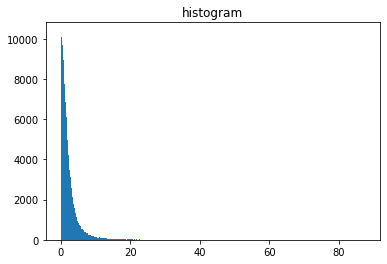

In [30]:
%matplotlib inline

plt.hist(dif_re, bins = 'auto') 
plt.title("histogram") 
plt.show()

In [26]:
display([data[0],data[1][::-1]])

In [78]:
normal_, reversed_ = sequence_encoder.predict(np.array([data[0],data[0][::-1]]))

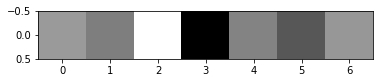

In [79]:
plt.imshow([normal_],cmap="gray")
plt.show()

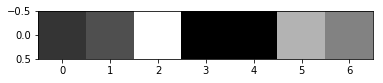

In [80]:
plt.imshow([reversed_],cmap="gray")
plt.show()

In [27]:
history = [0]*8
for i in range(0,8):
    x_train, x_test = train_test_split(load_data('data/autoencoder_training/'+str(i)+'.bundles'), test_size=0.2, shuffle=True)

    history[i] = sequence_autoencoder.fit(x_train, x_train, epochs=1, batch_size=512, shuffle=True, validation_data=(x_test,x_test))

loading data/autoencoder_training/0.bundlesdata
size:  10428168
normalizing...
Train on 8342534 samples, validate on 2085634 samples
Epoch 1/1
8342534/8342534 [==============================] - 4899s 587us/step - loss: 0.0013 - acc: 0.9352 - val_loss: 1.7398e-04 - val_acc: 0.9637
loading data/autoencoder_training/1.bundlesdata
size:  8908287
normalizing...
Train on 7126629 samples, validate on 1781658 samples
Epoch 1/1
7126629/7126629 [==============================] - 4130s 579us/step - loss: 1.1807e-04 - acc: 0.9714 - val_loss: 1.0823e-04 - val_acc: 0.9713
loading data/autoencoder_training/2.bundlesdata
size:  10747497
normalizing...
Train on 8597997 samples, validate on 2149500 samples
Epoch 1/1
8597997/8597997 [==============================] - 5044s 587us/step - loss: 9.8040e-05 - acc: 0.9746 - val_loss: 8.7295e-05 - val_acc: 0.9761
loading data/autoencoder_training/3.bundlesdata
size:  10850091
normalizing...
Train on 8680072 samples, validate on 2170019 samples
Epoch 1/1
8680072

In [26]:
sequence_autoencoder.save_weights('checkpoints/autoencoder_79subjects_9latent.h5')
sequence_encoder.save_weights('checkpoints/encoder_79subjects_9latent.h5')

{'val_loss': [0.00018386261005838182],
 'val_acc': [0.960109652072221],
 'loss': [0.0019791742608597997],
 'acc': [0.9224055449470183]}

In [14]:
plot_history(np.concatenate(history))

ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
for i in range(0,8):
    x_train, x_test = train_test_split(load_data('data/autoencoder_training/'+str(i)+'.bundles'), test_size=0.2, shuffle=True)

    history = sequence_autoencoder.fit(x_train, x_train, epochs=1, batch_size=512, shuffle=True, validation_data=(x_test,x_test))
    plot_history(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 128)           67584     
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 64)            49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 9)                 2664      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 9)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 64)            18944     
_________________________________________________________________
lstm_5 (LSTM)                (None, 21, 128)           98816     
__________

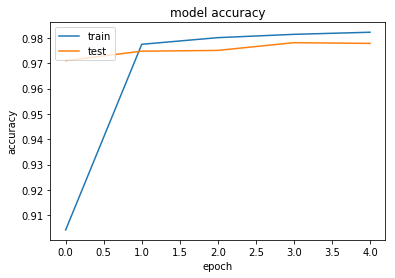

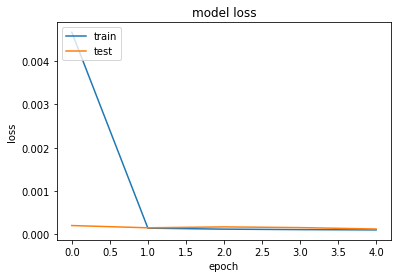

In [10]:
from keras.layers import Reshape
i=9
inputs = Input(shape=(21, 3))

encoder = LSTM(128, return_sequences=True)(inputs)
encoder = LSTM(64, return_sequences=True)(encoder)
encoder = LSTM(i, return_sequences=False)(encoder)

decoder = RepeatVector(21)(encoder)

decoder = LSTM(64, return_sequences=True)(decoder)
decoder = LSTM(128, return_sequences=True)(decoder)
decoder = LSTM(3, return_sequences=True)(decoder)

sequence_encoder = Model(inputs, encoder)
sequence_autoencoder = Model(inputs, decoder)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = sequence_autoencoder.fit(x_train, x_train, epochs=5, batch_size=512, shuffle=True, validation_data=(x_test,x_test))
plot_history(history)

#### Load...

In [24]:
latent_size = 21
sequence_autoencoder.load_weights('checkpoints/autoencoder_10samples_'+str(latent_size)+'latent_robust.h5')
sequence_encoder.load_weights('checkpoints/encoder_10samples_'+str(latent_size)+'latent_robust.h5')

#### or train...

In [54]:
sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = sequence_autoencoder.fit(x_train1, x_train1, epochs=15, batch_size=512, shuffle=True, validation_data=(x_test1,x_test1))
plot_history(history)

Train on 266211 samples, validate on 66553 samples
Epoch 1/15
266211/266211 [==============================] - 220s 827us/step - loss: 0.0260 - acc: 0.5375 - val_loss: 0.0157 - val_acc: 0.6459
Epoch 2/15
266211/266211 [==============================] - 214s 802us/step - loss: 0.0132 - acc: 0.7489 - val_loss: 0.0110 - val_acc: 0.8032
Epoch 3/15
266211/266211 [==============================] - 213s 802us/step - loss: 0.0103 - acc: 0.8083 - val_loss: 0.0074 - val_acc: 0.8222
Epoch 4/15
266211/266211 [==============================] - 213s 800us/step - loss: 0.0058 - acc: 0.8476 - val_loss: 0.0036 - val_acc: 0.8762
Epoch 5/15
266211/266211 [==============================] - 214s 803us/step - loss: 0.0030 - acc: 0.8903 - val_loss: 0.0024 - val_acc: 0.9029
Epoch 6/15
266211/266211 [==============================] - 214s 803us/step - loss: 0.0020 - acc: 0.9109 - val_loss: 0.0017 - val_acc: 0.9205
Epoch 7/15
266211/266211 [==============================] - 214s 802us/step - loss: 0.0014 - acc:

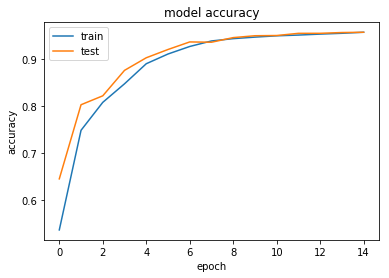

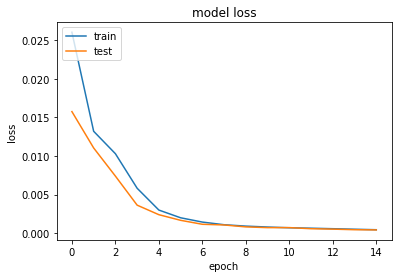

In [55]:
plot_history(history)

In [24]:
inputs = Input(shape=(21, 3))

encoder = Bidirectional(LSTM(128, return_sequences=True))(inputs)
encoder = LSTM(64, return_sequences=True)(encoder)
encoder = LSTM(7)(encoder)

decoder = RepeatVector(9)(encoder)
decoder = Reshape((21,3))(decoder)

decoder = LSTM(64, return_sequences=True)(decoder)
decoder = LSTM(128, return_sequences=True)(decoder)
decoder = LSTM(3, return_sequences=True)(decoder)

sequence_encoder = Model(inputs, encoder)
sequence_autoencoder = Model(inputs, decoder)
sequence_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 21, 3)             0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 21, 256)           135168    
_________________________________________________________________
lstm_20 (LSTM)               (None, 21, 64)            82176     
_________________________________________________________________
lstm_21 (LSTM)               (None, 7)                 2016      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 9, 7)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 21, 3)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 21, 64)            17408     
__________

In [29]:
sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = sequence_autoencoder.fit(x_train, x_train, epochs=3, batch_size=512, shuffle=True, validation_data=(x_test,x_test))

Train on 266211 samples, validate on 66553 samples
Epoch 1/3
266211/266211 [==============================] - 244s 918us/step - loss: 0.0156 - acc: 0.6777 - val_loss: 0.0127 - val_acc: 0.7790
Epoch 2/3
266211/266211 [==============================] - 239s 897us/step - loss: 0.0092 - acc: 0.8366 - val_loss: 0.0058 - val_acc: 0.8773
Epoch 3/3
266211/266211 [==============================] - 236s 888us/step - loss: 0.0035 - acc: 0.8967 - val_loss: 0.0026 - val_acc: 0.9051


In [21]:
data = load_data('data/autoencoder_training/7.bundles')

loading data/autoencoder_training/7.bundlesdata
size:  8976573
normalizing...


In [22]:
len(data)

8976573

In [23]:
#latent_space = sequence_encoder.predict(data)
reconstruction = sequence_autoencoder.predict(data[::100])

In [26]:
display([*data[0:1000:100],*reconstruction[:10]])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [25]:
display(reconstruction)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [ ]:
plt.imshow(toy_latent_space[0].reshape(1,latent_size), cmap="gray")
plt.imshow(toy_latent_space[700].reshape(1,latent_size), cmap="gray")

In [21]:
display(data)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


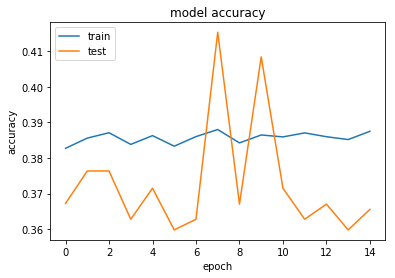

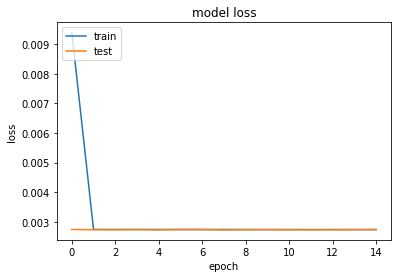

In [58]:
plot_history(history)

In [27]:
sequence_autoencoder.save_weights('checkpoints/autoencoder_79subjects_7latent.h5')
sequence_encoder.save_weights('checkpoints/encoder_79subjects_7latent.h5')

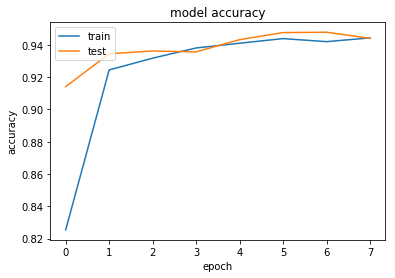

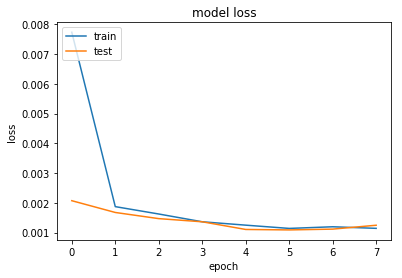

In [16]:
plot_history(history)

## Latent space

# Toy case: 3500 fibers

In [33]:
toy_data = load_data('data/3500fibers.npy', file_format='npy')

loading size:  3500
normalizing...


In [38]:
display(toy_data)
display(toy_reconstruction)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [34]:
toy_latent_space = sequence_encoder.predict(toy_data)
toy_reconstruction = sequence_autoencoder.predict(toy_data)
print("original data: ", toy_data.shape)
print("latent_space: ", toy_latent_space.shape)
print("reconstruction: ", toy_reconstruction.shape)
print('compressed from ', (toy_data.size * toy_data.itemsize)/1000, ' to ', (toy_latent_space.size * toy_latent_space.itemsize)/1000, 'kbytes')

original data:  (3500, 21, 3)
latent_space:  (3500, 7)
reconstruction:  (3500, 21, 3)
compressed from  882.0  to  98.0 kbytes


In [35]:
display(toy_reconstruction)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


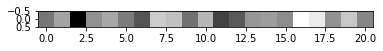

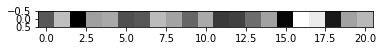

In [130]:
plt.imshow(toy_latent_space[0].reshape(1,latent_size), cmap="gray")
plt.show()
plt.imshow(toy_latent_space[700].reshape(1,latent_size), cmap="gray")
plt.show()

In [23]:
#clustering
t0 = time.time()
clusterer2 = hdbscan.HDBSCAN(min_cluster_size=50)
clusterer2.fit(toy_latent_space)
print(time.time() - t0, "seconds")

0.11237812042236328 seconds


In [145]:
kmeans = KMeans(n_clusters=10, n_init=10)
y_pred = kmeans.fit_predict(toy_latent_space)

cluster_centres = kmeans.cluster_centers_

In [148]:
clusters_dict2 = defaultdict(list)
for i, clus in enumerate(y_pred):
    clusters_dict2[clus].append(i)
n = len(set(clusters_dict2))
print(n, "clusters")

10 clusters


In [24]:
clusters_dict2 = defaultdict(list)
for i, clus in enumerate(clusterer2.labels_):
    clusters_dict2[clus].append(i)
n = len(set(clusters_dict2))
print(n, "clusters")

11 clusters


In [25]:
# reconstruction
display(toy_reconstruction, clusters_dict2, ids=range(n))
# original
display(toy_data, clusters_dict2, ids=range(n))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


# 3 full subjects case

In [46]:
t0 = time.time()
data, latent_space = load_and_predict([1], sequence_encoder, return_data=True)
print(time.time() - t0, 'seconds')

loading data/79subjects/001/001_1_3/001_bundlesTal_21pts.bundlesdata
size:  330948
normalizing...
loading data/79subjects/001/001_2_3/001_bundlesTal_21pts.bundlesdata
size:  328505
normalizing...
loading data/79subjects/001/001_3_3/001_bundlesTal_21pts.bundlesdata
size:  295623
normalizing...
compressed from  240.679152  to  80.226384 mbytes
317.33955335617065 seconds


In [152]:
latent_space.shape

(3045142, 21)

In [153]:
data.shape

(3045142, 21, 3)

## Clustering

#### HDBSCAN

In [36]:
t0 = time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
clusterer.fit(latent_space[:1000000])
print(time.time() - t0, "seconds")
#1/3 subject, 21 latent: 118 seconds
#3 subjects, 21 latent: 1:33 hrs
#3 subjects, 7 latent: 44 min

521.715961933136 seconds


In [155]:
# load
clusterer=pickle.load(open("checkpoints/clusterer_hdbscan_"+str(latent_size), "rb"))

In [35]:
# save
pickle.dump(clusterer,open("checkpoints/clusterer_hdbscan_"+str(latent_size), 'wb'))

In [37]:
clusters_dict = defaultdict(list)
for i, clus in enumerate(clusterer.labels_):
    clusters_dict[clus].append(i)
n = len(set(clusters_dict))
print(n, "clusters")
print(len(clusters_dict[-1]), "noise fibers, ",int(len(clusters_dict[-1])*100/len(data)), "% of total data")

2269 clusters
768316 noise fibers,  25 % of total data


In [83]:
display(data, clusters_dict, ids=range(100,110))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [159]:
a, b = 16, 26
for i in range(a,b):
    display(data*100, clusters_dict, ids=[i], hd=True)
display(data, clusters_dict, ids=range(a,b))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### k-means

In [138]:
n_clusters=154
# 20 reinicios de kmeans para quedarse con la mejor solucion
kmeans = KMeans(n_clusters=n_clusters, n_init=1, verbose=1)
y_pred = kmeans.fit_predict(latent_space[:1000])

cluster_centres = kmeans.cluster_centers_

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 4209.711
start iteration
done sorting
end inner loop
Iteration 1, inertia 4002.7913
start iteration
done sorting
end inner loop
Iteration 2, inertia 3936.7068
start iteration
done sorting
end inner loop
Iteration 3, inertia 3903.184
start iteration
done sorting
end inner loop
Iteration 4, inertia 3875.7512
start iteration
done sorting
end inner loop
Iteration 5, inertia 3853.0413
start iteration
done sorting
end inner loop
Iteration 6, inertia 3840.086
start iteration
done sorting
end inner loop
Iteration 7, inertia 3831.2617
start iteration
done sorting
end inner loop
Iteration 8, inertia 3824.289
start iteration
done sorting
end inner loop
Iteration 9, inertia 3818.224
start iteration
done sorting
end inner loop
Iteration 10, inertia 3814.1172
start iteration
done sorting
end inner loop
Iteration 11, inertia 3811.18
start iteration
done sorting
end inner loop
Iteration 12, inertia 3808.755
start 

In [139]:
from collections import defaultdict
clusters_dict = defaultdict(list)
for i, clus in enumerate(y_pred):
    clusters_dict[clus].append(i)
n = len(set(clusters_dict))
print(n)

154


In [14]:
latent_space = sequence_encoder.predict(data)
reconstruction = sequence_autoencoder.predict(data)

In [20]:
display(data[:10000])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [21]:
display(reconstruction[:10000])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [15]:
BT.write_bundle_severalbundles( "3Msift_t_MNI_21p_suavizado.bundles", reconstruction, bundles = [] )

In [6]:
import tslearn as ts

In [66]:
encoded = sequence_encoder.predict(data)
decoded = sequence_autoencoder.predict(data)

In [118]:
from kshape.core import kshape, zscore

cluster_num = 20
clusters = kshape(zscore(encoded, axis=1,ddof=10), cluster_num)

In [121]:
from scipy.stats import zscore as zs

In [39]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
X = data #random_walks(n_ts=50, sz=32, d=3)
k = TimeSeriesKMeans(n_clusters=12, metric="euclidean", max_iter=10, verbose=False, random_state=0).fit(X)

In [58]:
from tslearn.clustering import GlobalAlignmentKernelKMeans
X = data #random_walks(n_ts=50, sz=32, d=3)
k = GlobalAlignmentKernelKMeans(n_clusters=12, max_iter=10, verbose=True, random_state=0).fit(X)

Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster


In [40]:
from collections import defaultdict
clusters_dict = defaultdict(list)
for i, clus in enumerate(km.labels_):
    clusters_dict[clus].append(i)
n = len(set(clusters_dict))
print(n)
display(data, clusters_dict, ids=range(n))

12


In [55]:
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape
X = data#random_walks(n_ts=50, sz=32, d=3)
X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X)
k = KShape(n_clusters=10, n_init=5, verbose=True, random_state=0).fit(X)

Init 1
0.379 --> 0.336 --> 0.365 --> 
Init 2
0.369 --> 0.340 --> 0.345 --> 
Init 3
0.371 --> 0.343 --> 0.367 --> 
Init 4
Resumed because of empty cluster
Init 4
0.388 --> 0.363 --> 0.363 --> 
Init 5
0.375 --> 0.363 --> 0.347 --> 0.403 --> 


In [56]:
from collections import defaultdict
clusters_dict = defaultdict(list)
for i, clus in enumerate(k.labels_):
    clusters_dict[clus].append(i)
n = len(set(clusters_dict))
print(n)
display(data, clusters_dict, ids=range(n))

10


/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [46]:
X = random_walks(n_ts=50, sz=32, d=3)
X.shape

(50, 32, 3)

In [47]:
X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X)
X.shape

(50, 32, 3)

In [119]:
from collections import defaultdict
clusters_dict = defaultdict(list)
for i, clus in enumerate(clusters):
    clusters_dict[i]=clus[1]
n = len(set(clusters_dict))
print(n)

20


# Clustering Andrea

In [103]:
import argparse
import logging
import time
import os

import numpy as np
import sklearn.cluster
import dipy.segment.clustering

import matplotlib.image as mpimg
from sklearn.externals import joblib
from dipy.io.pickles import save_pickle, load_pickle

import utils.clustering_andrea.bundleTools as BT
import utils.clustering_andrea.clustering as clustering
import utils.clustering_andrea.metric as metric
import utils.clustering_andrea.segmentation as seg
#import visualization
import shutil

from utils.clustering_andrea.utils import save_clusters
from utils.clustering_andrea.processing import flatten_lists
from collections import defaultdict

In [104]:
#Root work directory creation, output should be placed here
work_dir = output_directory_

if os.path.exists(work_dir):
    shutil.rmtree(work_dir)

os.mkdir(work_dir)

map_clusters_dir = work_dir + '/ClustersMap'
os.makedirs(map_clusters_dir+'/img/min_len_100_clusters', exist_ok=True)
os.makedirs(map_clusters_dir+'/img/max_len_100_clusters', exist_ok=True)
os.makedirs(map_clusters_dir + '/img/min_len_30_centroids/', exist_ok=True)
os.makedirs(map_clusters_dir + '/img/5_largest_clusters', exist_ok=True)

final_clusters_dir = work_dir + '/FinalClusters'
os.makedirs(final_clusters_dir + '/img/min_len_100_clusters', exist_ok=True)
os.makedirs(final_clusters_dir + '/img/max_len_100_clusters', exist_ok=True)
os.makedirs(final_clusters_dir + '/img/min_len_30_centroids/', exist_ok=True)
os.makedirs(final_clusters_dir + '/img/5_largest_clusters', exist_ok=True)

final_bundles_dir = work_dir + '/FinalBundles'
os.makedirs(final_bundles_dir, exist_ok=True)
individual_bundles_dir =  final_bundles_dir + '/IndividualBundles'
os.makedirs(individual_bundles_dir, exist_ok=True)


object_dir = work_dir + '/output'
os.makedirs(object_dir, exist_ok=True)

map_output_filename = object_dir + '/clusters_map.txt'

In [105]:
xmax, xmin = latent_space.max(), latent_space.min()
normalized_latent_space = (latent_space - xmin)/(xmax - xmin)

new_latent_space = []
for fiber in normalized_latent_space:
    f = []
    for point in fiber:
        f.append([point,0,0])
    new_latent_space.append(f)
new_latent_space = np.array(new_latent_space)

fibers = new_latent_space*250

In [106]:
import itertools
import functools
import multiprocessing
import threading
import string
import utils.clustering_andrea.segmentation as seg

import _pickle as pickle

import numpy as np
import sklearn.cluster
import dipy.segment.clustering

from dipy.io.pickles import save_pickle
from sklearn.externals.joblib import Parallel, delayed

import utils.clustering_andrea.bundleTools as bundleTools
import utils.clustering_andrea.processing as processing
import utils.clustering_andrea.metric as metric
import os
import subprocess
import shutil

def map_clustering(labels):
    """
    Create groups based on the labels that composed each element

    @arg labels: List of lists, each element in the dataset
    has m features, then
    if each feature has an associated label each element is the
    collection of such labels, in this case the labels come from
    a previous clustering step performed in each feature.
    """

    #Hash tuple instead of a string? should be better
#    string_labels_it = map(lambda i: ''.join(map(str, i)), labels)
    labels_it = map(tuple, labels)
    clusters = []
    d = {}
    
    #For every element check its label
    #if its new then create a new cluster
    #else assign to the cluster that has all elements with the
    #same label
    for i, label in enumerate(labels_it):
        if label in d:
            clusters[d[label]].append(i)
        else:
            clusters.append([i])
            d[label] = len(d)
    return clusters

#Maybe should be moved to processing?
def split_fibers(fibers,points):
    return np.array(np.split(fibers, len(points), axis=1))[:,:,0]

#Wrapper for dipy given that we have clusters and not centroids
def clusters_to_clustermap(clusters, fibers, ids=None):
    """
    Wrapper for dipy clustering interface
    @arg clusters : list of lists representing the clusters, each
    inner list contains the index of the elements in the dataset that
    conform this cluster.
    
    @arg fibers : dataset
    """
    
    cluster_map = dipy.segment.clustering.ClusterMapCentroid(fibers)
    if ids:
        for i, cluster in zip(ids, clusters):
            #compute a centroid as a mean of its elements
            centr = fibers[cluster].mean(axis=0) 
            c = dipy.segment.clustering.ClusterCentroid(centroid=centr,
                                                        id=i, indices=cluster,
                                                        refdata=fibers)
            cluster_map.add_cluster(c)
        return cluster_map
    for i, cluster in enumerate(clusters):
        #compute a centroid as a mean of its elements
        centr = fibers[cluster].mean(axis=0) 
        c = dipy.segment.clustering.ClusterCentroid(centroid=centr,
                                                    id=i, indices=cluster,
                                                    refdata=fibers)
        cluster_map.add_cluster(c)

    return cluster_map

def get_groups(labels, ngroups):
    groups = [[] for i in range(ngroups)]
    for i, l in enumerate(labels):
        groups[l].append(i)
    return groups
def new_clusters_in_group(group, refdata, centroids,
                          actual_clusters, max_dist, better_join=False):
    """
    group: indices of clusters that conform a group
    max_dist: maximum distance allowed for joining two clusters inside a group
    centroids: all centroids where to index and perform computation to
               determine wether or not join two clusters based on its centroids
               done after filtering out small clusters
    actual_clusters: similar to centroids, but has all the elements in a cluster
    """
    new_clusters_in_group = []
    processed = set()
    for i in range(len(group)):
        #New cluster with objects from first cluster c1
        c1 = group[i]
        if c1 in processed:
            continue
        #Maybe id=ind doesnt matter, can be changed accordingly in the
        #main thread to be ascending without the use of the ind variable.
        #id=ind
        ob = dipy.segment.clustering.ClusterCentroid(centroid=actual_clusters[c1].centroid,
                                                     indices=actual_clusters[c1].indices[:],
                                                     refdata=refdata)

        processed.add(c1)
        centroids_ids = []#no considerar c1
        for j in range(i+1, len(group)):
            c2 = group[j]
            if c2 in processed:
                continue
            dist1 = metric.direct_dist(centroids[c1], centroids[c2])
            dist2 = metric.direct_dist(centroids[c1], centroids[c2][::-1])
            #add all elements from c2 into ob
            #max distance

            #Add option to check for distance with other elements in the
            #joined group and join in that case
            if (dist1 <= dist2) and (dist1 <= max_dist):
                if better_join:
                    brk = False
                    for cid in centroids_ids:
                        if metric.max_dist(centroids[c2], centroids[cid]) > max_dist:
                            brk = True
                            break
                    if brk: continue
                processed.add(c2)
                centroids_ids.append(c2)
                for index in actual_clusters[c2].indices:
                    ob.assign(id_datum=index, features=ob.refdata[index])
                    ob.update()

            elif (dist2 < dist1) and (dist2 <= max_dist):
                if better_join:
                    brk = False
                    for cid in centroids_ids:
                        if metric.max_dist(centroids[c2], centroids[cid]) > max_dist:
                            brk = True
                            break
                    if brk: continue

                processed.add(c2)
                centroids_ids.append(c2)
                for index in actual_clusters[c2].indices:
                    ob.assign(id_datum=index, features=ob.refdata[index][::-1])
                    ob.update()
                
        #Should return clusters to be added at the end.
        new_clusters_in_group.append(ob)

    return new_clusters_in_group

#Write .bundles .bundlesdata of small (< 1 fiber) and long centroids (> 1 fiber) of clusters
def small_clusters_reassignment(output,clusters,min_size_filter, max_size_filter,input_dir,threshold):
	
    print('small_clusters')
    small_clusters = clusters.get_small_clusters(max_size_filter) #Cambiar filtro a 5
    print('large_clusters')
    large_clusters = clusters.get_large_clusters(min_size_filter) #Cambiar filtro a 1
    print('centroids')
    small_centroids = np.asarray([x.centroid for x in small_clusters])
    large_centroids = np.asarray([x.centroid for x in large_clusters])
    print('*')

    print('Número total de clusters: ',str(len(clusters)))
    print('Número total de clusters con ',str(max_size_filter),' fibras o menos: ',str(len(small_clusters)))
    print('Número total de clusters con más de ',str(min_size_filter),' fibras: ',str(len(large_clusters)))

    #Call segmentation method
    nPoints = 21
    print('...... Comenzando la segmentación: ...... ')
    reassignment = seg.segmentation(nPoints,threshold, large_centroids,small_centroids,len(small_centroids), len(large_centroids))

    count = 0
    num_fibers_reass = 0
    num_discarded = 0
    #Reassign small clusters to large clusters 
    for small_index,large_index in enumerate(reassignment):
        fibers = small_clusters[small_index].indices
        if int(large_index)!=-1:
            #Hacer bucle para reasignar todas las fibras
            for fiber in fibers:
                centroid = large_clusters[large_index].centroid
                f = small_clusters[small_index].refdata[fiber]
                large_clusters[large_index].assign(id_datum=fiber, features= small_clusters[small_index].refdata[fiber])
                #large_clusters[large_index].update()
                num_fibers_reass += 1
            count+=1
            #bundleTools.write_bundle(reassignment_file,large_clusters[large_index])     
        else:
            if len(fibers)>2:
                recover_cluster = small_clusters[small_index]
                large_clusters.append(recover_cluster)
            else:
                num_discarded +=1
            #else sacar el cluster de small_clusters y añadirselo a large_clusters, SI len(fibers>1)

                c = np.asarray(cluster[:])

    print('Número de clusters reasignados: '+str(count)+' con un total de ',str(num_fibers_reass))
    print('Número de clusters descartados: '+str(num_discarded)+' con un total de ',str(num_discarded))

    return large_clusters




def join_by_group(clusters, actual_clusters, centroids, groups, max_dist=10.0, better_join=False):
    """
    Use a point-base clusterer to group centroids of clusters according to a certain point
    after doing this construct clusters that are the union of previous ones,
    based on wether their
    max distance(considering inverse too) is less than or equal to a
    threshold.
    Pass groups as arguments?
    """
    # actual_clusters = clusters.get_large_clusters(min_size_filter)
    # centroids = np.asarray([x.centroid for x in clusters.get_large_clusters(min_size_filter)])
    # centroids_points = centroids[:,point_index]
    # labels = clusterer.predict(centroids_points)
    # groups = get_groups(labels, ngroups=ngroups)
#    groups = [[] for _ in range(ngroups)]
 #   for i, c in enumerate(labels):
  #      groups[c].append(i)

    final_clusters = dipy.segment.clustering.ClusterMapCentroid(clusters.refdata)

    part_func = functools.partial(new_clusters_in_group, refdata=clusters.refdata, centroids=centroids,
                                  actual_clusters=actual_clusters, max_dist=max_dist, better_join=better_join)
    results = Parallel(n_jobs=-1, backend='threading')(delayed(part_func)(group) for group in groups)
    
    ind = 0
    for result in results:
        for x in result:
            x.id = ind
            ind += 1
            final_clusters.add_cluster(x)
            
    return final_clusters
    
#Classes for use with dipy ClusteringMap objects
class MapClustering(dipy.segment.clustering.Clustering):
    #Must return ClusterMap object
    #So we wrap our function around this
    def cluster(self, fibers, labels):
        clusters = map_clustering(labels)
        return clusters_to_clustermap(clusters, fibers)
def new_merged_clusters(to_merge, clusters_map, refdata, filtered_size):
    mapping = {}
    for i, cluster in enumerate(clusters_map.get_large_clusters(filtered_size)):
        mapping[i] = cluster.id
    #use indices into mapping to get the clusters_map correct indices

    cluster_map = dipy.segment.clustering.ClusterMapCentroid(refdata)
    for i, cluster in enumerate(to_merge):
        ind = [mapping[i] for i in cluster.indices]
        #clusters[ind]#clusters to be joined
        gen = (clusters_map[ind][j].indices for j in range(len(cluster)))
        indices = list(itertools.chain.from_iterable(gen))

        #indices = list(itertools.chain.from_iterable(clusters_map[ind]))
        #Improve centroid!
        c = dipy.segment.clustering.ClusterCentroid(centroid=cluster.centroid,
                                                    id=i, indices=indices, refdata=refdata)

        cluster_map.add_cluster(c)
    return cluster_map


def clusters_join_remove(clusters, n_clusters, max_dist=10, min_size=30):
    import collections
    """
    Take as argument the clusters, the number of kmeans clusters, the
    maximum distance alowed inside the kmeans clusters
    and the number of fibers required to separate between large and
    small clusters
    """

    new_clusters = dipy.segment.clustering.ClusterMapCentroid(clusters.refdata)
    
    midpoint = clusters.centroids[0].shape[0]//2
    #get middle point of every centroid
    midpoint_centroids = np.asarray(clusters.centroids)[:,midpoint]

    clusterer = sklearn.cluster.MiniBatchKMeans(n_clusters)
    labels = clusterer.fit_predict(midpoint_centroids)
    groups = get_groups(labels, n_clusters)

    new_clusters = clusters
    reagrupables = np.zeros(n_clusters)
    no_reagrupables = np.zeros(n_clusters)
    count = np.zeros(n_clusters)
    clusters_array = np.asarray(clusters)

    for i, group in enumerate(groups):
        not_joinable_ingroup = []
        diff = midpoint_centroids[group] - clusterer.cluster_centers_[i]
        midpoint_distances = np.sqrt((diff**2).sum(axis=1))
        mask = (midpoint_distances <= max_dist)
        reagrupables[i] = mask.sum()
        no_reagrupables[i] = (~mask).sum()
        joinable = np.asarray(group)[mask] #Clusters del grupo que pueden ser unidos
        #Add clusters that remain the same to list
        for idx in np.asarray(group)[~mask]:
            not_joinable_ingroup.append(idx)
        #numero de clusters con menos de 30 fibras que son agrupables
        count[i] = len(list(filter(lambda x: len(x) < min_size, (clusters_array)[joinable])))
                       
        #separar entre pequeños y grandes dentro del grupo
        mask_small = np.asarray(list(map(len, clusters_array[joinable]))) < min_size

        small_clusters_group = clusters_array[joinable][mask_small]
        large_clusters_group = clusters_array[joinable][~mask_small]
        
        small_centroids = np.asarray([x.centroid for x in small_clusters_group])
        large_centroids = np.asarray([x.centroid for x in large_clusters_group])
        merge_clusters = collections.defaultdict(list)
        #No large clusters to join in this group skip to next group
        #Or join among the small group
        if large_centroids.shape[0] == 0:
            for idx in joinable:
                not_joinable_ingroup.append(idx)
            continue

        #Compute which of the larges cluster is closer to the small ones
        for i, c in enumerate(small_centroids):
            #index returned is the cluster among the large_clusters_group which we join
#            print(c)
            dist, index = metric.max_dist_one_to_res(c, large_centroids)
            if dist <= max_dist:
                merge_clusters[index].append(i)#then we create clusters from dict
            else:
                not_joinable_ingroup.append(i)#Or just add data

        ind = 0
        #WRONG, MODIFYING ORIGINAL DATA
#        for idx in not_joinable_ingroup:
#            c = dipy.segment.clustering.ClusterCentroid(centroid=clusters_array[idx].centroid,
#                                                        id=ind, indices=clusters_array[idx].indices, refdata=clusters_array[idx].refdata)
#            ind += 1
#            new_clusters.add_cluster(c)
            
        for key, added_clusters in merge_clusters.items():
            c = dipy.segment.clustering.ClusterCentroid(centroid=large_clusters_group[key].centroid,
                                                    id=ind, indices=large_clusters_group[key].indices, refdata=large_clusters_group[key].refdata)
            for small_cluster in added_clusters:
                for index in small_clusters_group[small_cluster].indices:
                    c.assign(id_datum=index, features=c.refdata[index])
                    c.update()
            new_clusters.add_cluster(c)

        #Por cada cluster de los pequeños buscar en los grandes
        #Unir al cluster grande cuya maxima distancia usando centroides es la menor
        
        #seleccionar id clusters reagrupables
        #sum(filter(lambda x: x < 30, map(len, (clusters_array)[np.asarray(group)[mask]])))

    return new_clusters
#    return reagrupables, no_reagrupables, count
       # idx = np.asarray(group)[np.where(midpoint_distances > max_dist)]
       #new_clusters = np.delete(new_clusters, idx)

def joinable_clusters(clique, visited):
    """
    Visits the nodes of a clique and returns nodes that are not visited.
    In the clustering, the nodes represent the centroids of the clusters.
    """
    clusters_ids = []
    for node in clique:
        #some clusters may be joined already
        if not visited[node]:
            clusters_ids.append(node)
            visited[node] = True
    return clusters_ids

def clique_join(clusters, refdata, threshold=10.0):
    """
    Returns a list of new clusters(dipy.clustering.ClusterCentroid container)
    based on computing the distance between centroids and using this matrix as input
    to finding cliques, distances greater than the specified threshold are ignored
    """
    import networkx
    centroids = np.asarray([x.centroid for x in clusters])

    #use numpy matrix dist
    max_dists = metric.matrix_dist(centroids, get_max=True)
    max_dists[max_dists > threshold] = 0
    network = networkx.from_numpy_array(max_dists)
    cliques = sorted(networkx.find_cliques(network), key=len, reverse=True)

    visited = np.zeros(len(centroids), np.bool)
    new_clusters = []
    for clique in cliques:
        #each clique is potentially a cluster
        clusters_ids = joinable_clusters(clique, visited)

        if not clusters_ids:
            continue

        #need to copy indices to preserve number of streamlines, no idea why
        ob = dipy.segment.clustering.ClusterCentroid(centroid=centroids[clusters_ids[0]],
                                                     indices=clusters[clusters_ids[0]].indices[:],
                                                     refdata=refdata)

        #node value indexes into centroids
        for idx in clusters_ids[1:]:
            for index in clusters[idx].indices:
                ob.assign(id_datum=index, features=ob.refdata[index])
                ob.update()
                
        new_clusters.append(ob)

    return new_clusters
def group_join_clique(clusters, groups, refdata):
    """
    Return clusters after distributing them in groups and joining with both distances and
    cliques inside those groups.
    
    groups: Each group if a list of indices of clusters which are in that group.
    """
    final_clusters = dipy.segment.clustering.ClusterMapCentroid(refdata)

    ind = 0
    for group in groups:
        cls = [clusters[i] for i in group]
        new_clusters = clique_join(cls, refdata)
        for c in new_clusters:
            c.id = ind
            ind += 1
            final_clusters.add_cluster(c)

    return final_clusters

def cluster_kmeans(x, k,random_state=0):
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=k, random_state=random_state)
    return kmeans.fit_predict(x), kmeans

def parallel_points_clustering(X, ks, n_jobs=-1, backend='threading'):
    """
    Compute MiniBatchKMeans for each point according to cluster size
    Do in parallel, conserve clusterers object.
    """
    results = Parallel(n_jobs=n_jobs, backend=backend)(delayed(cluster_kmeans)(x, k) for x, k in zip(X, ks))
    labels, clusterers = list(map(list, zip(*results)))
    labels = np.array(labels).T
    return labels, clusterers

In [161]:
# son los 5 puntos de las fibras sobre los que se aplica el clustering
#points = [0,3,10,17,20] # Points to be used in map clustering
points = range(7)
# es el número de clústering en los puntos
ks = [2,2,2,2,2,2,2] # Number of clusters to be used for each point in K-Means for map
#ks = [5,3,3,3,5]
#map-outfile_ = # Output file(pickles) for map based clustering
#filter-min-size_ = # Filter clusters with less than a given size argument for use in joining with quickbundles(max dist)
output_directory_ = 'output_andrea/'# Directory where to place all output, including images, and pickled files
infile_ = 'data/15_full.bundles'# Input streamlines file

In [162]:
X = split_fibers(normalized_latent_space[:,points],points)

In [163]:
X = X.reshape(7,3500,1)

In [164]:
colormap = mpimg.imread('utils/clustering_andrea/colors256.jpg')[0]

t1 = time.time()
#X = split_fibers(data[:,points,:],points)
#X = split_fibers(normalized_latent_space[:,points],points)
labels, clusterers = parallel_points_clustering(X=X, ks=ks)
print('Tiempo Kmeans:',time.time() - t1)

t1 = time.time()
m = MapClustering()
map_clusters = m.cluster(fibers, labels)
print('Tiempo Map:',time.time() - t1)

print('Number of clusters in map_clusters:', len(map_clusters))
print('Number of fibers in map_clusters:',sum(map_clusters.clusters_sizes()))

Tiempo Kmeans: 0.2017209529876709
Tiempo Map: 0.006205558776855469
Number of clusters in map_clusters: 14
Number of fibers in map_clusters: 3500


In [165]:
clusters_dict = defaultdict(list)
for i, cluster in enumerate(map_clusters):
    clusters_dict[i] = cluster.indices
n = len(set(clusters_dict))


In [166]:
display(data, clusters_dict, ids=range(n))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [50]:
output="segmentation"
clusters=map_clusters
min_size_filter=2
max_size_filter=1
input_dir='segmentation/bundles/result/parallelFastCPU'
threshold=10
print('small_clusters')
small_clusters = clusters.get_small_clusters(max_size_filter) #Cambiar filtro a 5
print('large_clusters')
large_clusters = clusters.get_large_clusters(min_size_filter) #Cambiar filtro a 1
print('centroids')
small_centroids = np.asarray([x.centroid for x in small_clusters])
large_centroids = np.asarray([x.centroid for x in large_clusters])
print('*')

print('Número total de clusters: ',str(len(clusters)))
print('Número total de clusters con ',str(max_size_filter),' fibras o menos: ',str(len(small_clusters)))
print('Número total de clusters con más de ',str(min_size_filter),' fibras: ',str(len(large_clusters)))


small_clusters
large_clusters
centroids
*
Número total de clusters:  27
Número total de clusters con  1  fibras o menos:  6
Número total de clusters con más de  2  fibras:  21


In [52]:
import shutil
import os
import utils.clustering_andrea.bundleTools as BT
import ctypes

_seg = ctypes.CDLL('utils/clustering_andrea/segmentation_clust/segmentation.so')
_seg.segmentation.argtypes = (ctypes.c_uint,ctypes.POINTER(ctypes.c_char),ctypes.POINTER(ctypes.c_char),ctypes.c_float, ctypes.POINTER(ctypes.c_char),ctypes.c_uint,ctypes.c_uint)

#The result value is a list whose indices are the indices of small clusters, each index contains the index of it's large_cluster reassignment
def segmentation(nPoints,threshold, large_clusters_fibers,small_clusters_fibers,nfibers_subject,nfibers_atlas):
    print('antes de _seg')
    global _seg
    print(1)
    nBundles = len(large_clusters_fibers)
    n_small_clusters_fibers = len(small_clusters_fibers)
    print(2)
    #Create folders
    bundles_dir = "segmentation_clust/bundles"
    if os.path.exists(bundles_dir):
        shutil.rmtree(bundles_dir)
        os.makedirs(bundles_dir)
    else:
        os.makedirs(bundles_dir)
    print(3)
     #Write file with the largest cluster's 
    large_centroids_file = bundles_dir+"/large_clusters.bundles"
    BT.write_bundle(large_centroids_file, large_clusters_fibers)
    print(4)
    #Write file with the smallest cluster's 
    small_centroids_file = bundles_dir+"/small_clusters.bundles"
    BT.write_bundle(small_centroids_file, small_clusters_fibers)
    print(5)
    ouputWorkDirectory = bundles_dir+'/result'

    s_subject =small_centroids_file.encode()
    s_atlas= large_centroids_file.encode()
    s_output= ouputWorkDirectory.encode()
    _seg.segmentation.restype = ctypes.POINTER(ctypes.c_int)
    result = _seg.segmentation(ctypes.c_uint(nPoints), s_subject, s_atlas,ctypes.c_float(threshold),s_output,ctypes.c_uint(nfibers_subject),ctypes.c_uint(nfibers_atlas))
    result_list = [result[i] for i in range(n_small_clusters_fibers)]
    _seg.freeme(result)
    shutil.rmtree(bundles_dir)
    return(result_list)

In [ ]:

#Call segmentation method
nPoints = 21
print('...... Comenzando la segmentación: ...... ')
reassignment = seg.segmentation(nPoints,threshold, large_centroids,small_centroids,len(small_centroids), len(large_centroids))


In [ ]:

count = 0
num_fibers_reass = 0
num_discarded = 0
#Reassign small clusters to large clusters 
for small_index,large_index in enumerate(reassignment):
    fibers = small_clusters[small_index].indices
    if int(large_index)!=-1:
        #Hacer bucle para reasignar todas las fibras
        for fiber in fibers:
            centroid = large_clusters[large_index].centroid
            f = small_clusters[small_index].refdata[fiber]
            large_clusters[large_index].assign(id_datum=fiber, features= small_clusters[small_index].refdata[fiber])
            #large_clusters[large_index].update()
            num_fibers_reass += 1
        count+=1
        #bundleTools.write_bundle(reassignment_file,large_clusters[large_index])     
    else:
        if len(fibers)>2:
            recover_cluster = small_clusters[small_index]
            large_clusters.append(recover_cluster)
        else:
            num_discarded +=1
        #else sacar el cluster de small_clusters y añadirselo a large_clusters, SI len(fibers>1)

            c = np.asarray(cluster[:])

print('Número de clusters reasignados: '+str(count)+' con un total de ',str(num_fibers_reass))
print('Número de clusters descartados: '+str(num_discarded)+' con un total de ',str(num_discarded))
actual_clusters = large_clusters

In [ ]:
actual_clusters = clustering.small_clusters_reassignment(output="segmentation",
                                                         clusters=map_clusters,
                                                         min_size_filter=2,
                                                         max_size_filter=1,
                                                         input_dir = 'segmentation/bundles/result/parallelFastCPU',
                                                         threshold = 10)

In [27]:
clusters_dict = defaultdict(list)
for i, cluster in enumerate(actual_clusters):
    clusters_dict[i] = cluster.indices
n = len(set(clusters_dict))

In [28]:
display(fibers, clusters_dict, ids=range(100))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [29]:
t1 = time.time()

point_index = 10
ngroups = ks[len(ks)//2]

centroids = np.asarray([x.centroid for x in actual_clusters])
centroids_points = centroids[:,point_index]
clusterer=clusterers[len(points)//2]
labels = clusterer.predict(centroids_points)

groups = clustering.get_groups(labels, ngroups=ngroups)
final_clusters = clustering.group_join_clique(actual_clusters, groups, fibers)
# final_clusters = clustering.join_by_group(clusters=map_clusters,
#                                           actual_clusters=actual_clusters,
#                                           centroids=centroids,
#                                           groups=groups,
#                                           max_dist=10.0,
#                                           better_join=args.better_join)


In [30]:
print('Number of clusters in map_clusters:', len(final_clusters))

Number of clusters in map_clusters: 53354


In [31]:
clusters_dict = defaultdict(list)
for i, cluster in enumerate(final_clusters):
    clusters_dict[i] = cluster.indices
n = len(set(clusters_dict))

In [35]:
display(fibers, clusters_dict, ids=range(200,300))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


# DEC: Deep Embedding Clustering

In [92]:
def compare(original_streamlines, decoded_streamlines, n, one_by_one=False):
    
    if (len(original_streamlines.shape)!=3 or len(decoded_streamlines.shape)!=3):
        print("Wrong shape")
        return
    
    np.random.seed(50)
    random_test_images=np.random.randint(original_streamlines.shape[0], size=n)
        
    if (one_by_one):
        for i, image_idx in enumerate(random_test_images):
            o = original_streamlines[image_idx].reshape(21,3)
            d = decoded_streamlines[image_idx].reshape(21, 3)
            display([o, d], colors=[(1., 1., 0)]+[(0.5, 0.8, 0.8)])      

    else:
        o = original_streamlines[random_test_images]
        d = decoded_streamlines[random_test_images]
        a = np.concatenate((o, d), axis=0)
        display(a, colors=[(1., 1., 0)]*len(o)+[(0.5, 0.8, 0.8)]*len(d))  

In [93]:
def p_mat(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

### Autoencoder

In [174]:
# hyperparameters
learning_rate = 0.1 #0.1
iters_lr_update = 20000
lr_change_rate = 0.1
dropout_fraction = 0.1
init_stddev = 0.01

alpha=1.0
batch_size=512
layerwise_pretrain_iters=30000 #50000
finetune_iters=10000 #100000

input_dim=63
encoders_dims = [input_dim, 500, 500, 2000, 100]
history = [0]*6

In [175]:
x_test2 = x_test.reshape(len(x_test), 63)
X = x_train.reshape(len(x_train), 63)
iters_per_epoch = int(len(X) / batch_size)
layerwise_epochs = max(int(layerwise_pretrain_iters / iters_per_epoch), 1)
finetune_epochs = max(int(finetune_iters / iters_per_epoch), 1)

lr_epoch_update = max(1, iters_lr_update / float(iters_per_epoch))

In [75]:
class ClusteringLayer(Layer):
    '''
    Clustering layer which converts latent space Z of input layer
    into a probability vector for each cluster defined by its centre in
    Z-space. Use Kullback-Leibler divergence as loss, with a probability
    target distribution.
    # Arguments
        output_dim: int > 0. Should be same as number of clusters.
        input_dim: dimensionality of the input (integer).
            This argument (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        alpha: parameter in Student's t-distribution. Default is 1.0.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, output_dim)`.
    '''
    def __init__(self, output_dim, input_dim=None, weights=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha
        # kmeans cluster centre locations
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = K.variable(self.initial_weights)
        self.trainable_weights = [self.W]

    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2 /self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q

    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [75]:
input_layer = Input(shape=(input_dim,), name='input')

layer_wise_autoencoders = []
encoders = []
decoders = []

for i  in range(1, len(encoders_dims)):
    # Encoder
    encoder_activation = 'linear' if i == (len(encoders_dims) - 1) else 'relu'
    encoder = Dense(encoders_dims[i], 
                    activation=encoder_activation,
                    input_shape=(encoders_dims[i-1],),
                    kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                    bias_initializer='zeros', 
                    name='encoder_dense_%d'%i)
    encoders.append(encoder)
    
    # Decoder
    decoder_index = len(encoders_dims) - i
    
    decoder_activation = 'linear' if i == 1 else 'relu'
    decoder = Dense(encoders_dims[i-1], 
                    activation=decoder_activation,
                    kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                    bias_initializer='zeros',
                    name='decoder_dense_%d'%decoder_index)
    decoders.append(decoder)
    
    #Autoencoder
    autoencoder = Sequential([
        Dropout(dropout_fraction, input_shape=(encoders_dims[i-1],), name='encoder_dropout_%d'%i),
        encoder,
        Dropout(dropout_fraction, name='decoder_dropout_%d'%decoder_index),
        decoder
    ])
    
    autoencoder.compile(loss='mse', optimizer=SGD(lr=learning_rate, decay=0, momentum=0.9), metrics=['acc'])
    layer_wise_autoencoders.append(autoencoder)

encoder = Sequential(encoders)
encoder.compile(loss='mse', optimizer=SGD(lr=learning_rate, decay=0, momentum=0.9), metrics=['acc'])
decoders.reverse()
autoencoder = Sequential(encoders + decoders)
autoencoder.compile(loss='mse', optimizer=SGD(lr=learning_rate, decay=0, momentum=0.9), metrics=['acc'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_dense_1 (Dense)      (None, 500)               32000     
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 500)               250500    
_________________________________________________________________
encoder_dense_3 (Dense)      (None, 2000)              1002000   
_________________________________________________________________
encoder_dense_4 (Dense)      (None, 100)               200100    
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 2000)              202000    
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 500)               1000500   
_________________________________________________________________
decoder_dense_3 (Dense)      (None, 500)               250500    
__________

#### Load autoencoder

In [76]:
print('Loading pretrained weights for autoencoder...', end='')
autoencoder.load_weights('checkpoints/autoencoder2.h5')
print('loaded')

Loading pretrained weights for autoencoder...loaded


In [77]:
autoencoder_pred = autoencoder.predict(X)
autoencoder_pred = autoencoder_pred.reshape(len(autoencoder_pred), 21, 3)

In [78]:
display(autoencoder_pred)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [91]:
display(x_train)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [75]:
encoder_pred = encoder.predict(x_train.reshape(len(x_train),63))

#### or train

In [45]:
print('iters_per_epoch: ', iters_per_epoch)
print('layerwise_epochs: ', layerwise_epochs)
print('finetune_epochs: ', finetune_epochs)

def step_decay(epoch):
    initial_rate = learning_rate
    factor = int(epoch / lr_epoch_update)
    lr = initial_rate / (10 ** factor)
    return lr

lr_schedule = LearningRateScheduler(step_decay)
current_input = X

for i, ae in enumerate(layer_wise_autoencoders):
    print(ae.summary())
  
    if i > 0:
        weights = encoders[i-1].get_weights()
        dense_layer = Dense(encoders_dims[i], 
                            input_shape=(current_input.shape[1],),
                            activation='relu', weights=weights,
                            name='encoder_dense_copy_%d'%i)
        encoder_model = Sequential([dense_layer])
        encoder_model.compile(loss='mse', optimizer=SGD(lr=learning_rate, decay=0, momentum=0.9), metrics=['acc'])
        current_input = encoder_model.predict(current_input)

    history[i] = ae.fit(current_input, current_input, 
                                 batch_size=batch_size, 
                                 epochs=layerwise_epochs, 
                                 callbacks=[lr_schedule])

    autoencoder.layers[i].set_weights(ae.layers[1].get_weights())
    autoencoder.layers[len(autoencoder.layers) - i - 1].set_weights(ae.layers[-1].get_weights())

iters_per_epoch:  4
layerwise_epochs:  7500
finetune_epochs:  2500
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_dropout_1 (Dropout)  (None, 63)                0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 420)               26880     
_________________________________________________________________
decoder_dropout_4 (Dropout)  (None, 420)               0         
_________________________________________________________________
decoder_dense_4 (Dense)      (None, 63)                26523     
Total params: 53,403
Trainable params: 53,403
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7500
2345/2345 [==============================] - 0s 138us/step - loss: 0.1879 - acc: 0.0021
Epoch 2/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.1592 - acc: 8.528

2345/2345 [==============================] - 0s 11us/step - loss: 0.0022 - acc: 0.6013
Epoch 154/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0022 - acc: 0.6026
Epoch 155/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0022 - acc: 0.5974
Epoch 156/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0022 - acc: 0.6013
Epoch 157/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0022 - acc: 0.6115
Epoch 158/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0022 - acc: 0.6026
Epoch 159/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0021 - acc: 0.6034
Epoch 160/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0021 - acc: 0.6030
Epoch 161/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0021 - acc: 0.6081
Epoch 162/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0022 - acc: 0.6013


2345/2345 [==============================] - 0s 11us/step - loss: 0.0020 - acc: 0.6256
Epoch 314/7500
2345/2345 [==============================] - 0s 13us/step - loss: 0.0020 - acc: 0.6277
Epoch 315/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0020 - acc: 0.6179
Epoch 316/7500
2345/2345 [==============================] - 0s 13us/step - loss: 0.0020 - acc: 0.6179
Epoch 317/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0020 - acc: 0.6269
Epoch 318/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0020 - acc: 0.6252
Epoch 319/7500
2345/2345 [==============================] - 0s 14us/step - loss: 0.0020 - acc: 0.6256
Epoch 320/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0020 - acc: 0.6209
Epoch 321/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0020 - acc: 0.6188
Epoch 322/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0020 - acc: 0.

2345/2345 [==============================] - 0s 9us/step - loss: 0.0018 - acc: 0.6320
Epoch 474/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0018 - acc: 0.6422
Epoch 475/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0018 - acc: 0.6345
Epoch 476/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0019 - acc: 0.6303
Epoch 477/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0019 - acc: 0.6277
Epoch 478/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0019 - acc: 0.6286
Epoch 479/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0018 - acc: 0.6277
Epoch 480/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0019 - acc: 0.6333
Epoch 481/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0018 - acc: 0.6290
Epoch 482/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0018 - acc: 0.6171
E

2345/2345 [==============================] - 0s 8us/step - loss: 0.0017 - acc: 0.6362
Epoch 634/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0017 - acc: 0.6414
Epoch 635/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0017 - acc: 0.6409
Epoch 636/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0017 - acc: 0.6422
Epoch 637/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0017 - acc: 0.6354
Epoch 638/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0017 - acc: 0.6422
Epoch 639/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0017 - acc: 0.6277
Epoch 640/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0017 - acc: 0.6375
Epoch 641/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0017 - acc: 0.6358
Epoch 642/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0017 - acc: 0.6367
Epo

2345/2345 [==============================] - 0s 11us/step - loss: 0.0016 - acc: 0.6388
Epoch 794/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0016 - acc: 0.6537
Epoch 795/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0016 - acc: 0.6448
Epoch 796/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0017 - acc: 0.6375
Epoch 797/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0017 - acc: 0.6435
Epoch 798/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0016 - acc: 0.6533
Epoch 799/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0016 - acc: 0.6495
Epoch 800/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0016 - acc: 0.6512
Epoch 801/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0016 - acc: 0.6567
Epoch 802/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0016 - acc: 0.

2345/2345 [==============================] - 0s 13us/step - loss: 0.0015 - acc: 0.6520
Epoch 954/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0015 - acc: 0.6478
Epoch 955/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0015 - acc: 0.6614
Epoch 956/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0015 - acc: 0.6542
Epoch 957/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0015 - acc: 0.6512
Epoch 958/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0015 - acc: 0.6503
Epoch 959/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0015 - acc: 0.6597
Epoch 960/7500
2345/2345 [==============================] - 0s 13us/step - loss: 0.0016 - acc: 0.6550
Epoch 961/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0015 - acc: 0.6618
Epoch 962/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0015 - acc: 0.64

2345/2345 [==============================] - 0s 12us/step - loss: 0.0015 - acc: 0.6614
Epoch 1114/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0015 - acc: 0.6546
Epoch 1115/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0015 - acc: 0.6695
Epoch 1116/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0015 - acc: 0.6712
Epoch 1117/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0015 - acc: 0.6721
Epoch 1118/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0015 - acc: 0.6606
Epoch 1119/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0015 - acc: 0.6533
Epoch 1120/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0015 - acc: 0.6520
Epoch 1121/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0015 - acc: 0.6648
Epoch 1122/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0015 - a

2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6729
Epoch 1274/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6785
Epoch 1275/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6721
Epoch 1276/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6559
Epoch 1277/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6657
Epoch 1278/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0015 - acc: 0.6716
Epoch 1279/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6691
Epoch 1280/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0015 - acc: 0.6588
Epoch 1281/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6674
Epoch 1282/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6

2345/2345 [==============================] - 0s 9us/step - loss: 0.0014 - acc: 0.6665
Epoch 1434/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0014 - acc: 0.6721
Epoch 1435/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6789
Epoch 1436/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6704
Epoch 1437/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0014 - acc: 0.6733
Epoch 1438/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6657
Epoch 1439/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0014 - acc: 0.6768
Epoch 1440/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0014 - acc: 0.6751
Epoch 1441/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6721
Epoch 1442/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0014 - acc

2345/2345 [==============================] - 0s 11us/step - loss: 0.0014 - acc: 0.6635
Epoch 1514/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6772
Epoch 1515/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0014 - acc: 0.6755
Epoch 1516/7500
2345/2345 [==============================] - 0s 14us/step - loss: 0.0014 - acc: 0.6729
Epoch 1517/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6627
Epoch 1518/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0014 - acc: 0.6695
Epoch 1519/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0014 - acc: 0.6772
Epoch 1520/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0014 - acc: 0.6751
Epoch 1521/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0014 - acc: 0.6699
Epoch 1522/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 -

2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6682
Epoch 1672/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0014 - acc: 0.6768
Epoch 1673/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6729
Epoch 1674/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6827
Epoch 1675/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0014 - acc: 0.6704
Epoch 1676/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6699
Epoch 1677/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0014 - acc: 0.6802
Epoch 1678/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6797
Epoch 1679/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6768
Epoch 1680/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0014 

Epoch 1751/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6768
Epoch 1752/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0014 - acc: 0.6768
Epoch 1753/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6780
Epoch 1754/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6772
Epoch 1755/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0014 - acc: 0.6755
Epoch 1756/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6733
Epoch 1757/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6755
Epoch 1758/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6823
Epoch 1759/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6751
Epoch 1760/7500
2345/2345 [==============================] - 0s 9us/step - lo

2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6793
Epoch 1911/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6802
Epoch 1912/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6746
Epoch 1913/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6780
Epoch 1914/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0014 - acc: 0.6844
Epoch 1915/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6870
Epoch 1916/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6844
Epoch 1917/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6827
Epoch 1918/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6896
Epoch 1919/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 -

2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6785
Epoch 2069/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6840
Epoch 2070/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6810
Epoch 2071/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6832
Epoch 2072/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0014 - acc: 0.6785
Epoch 2073/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6866
Epoch 2074/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6738
Epoch 2075/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6789
Epoch 2076/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6840
Epoch 2077/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 -

2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6861
Epoch 2227/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6802
Epoch 2228/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6738
Epoch 2229/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0013 - acc: 0.6814
Epoch 2230/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0013 - acc: 0.6870
Epoch 2231/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6900
Epoch 2232/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6942
Epoch 2233/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6934
Epoch 2234/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6861
Epoch 2235/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - 

Epoch 2306/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6913
Epoch 2307/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0013 - acc: 0.6981
Epoch 2308/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6853
Epoch 2309/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0013 - acc: 0.6917
Epoch 2310/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6908
Epoch 2311/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6870
Epoch 2312/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6913
Epoch 2313/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6806
Epoch 2314/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6955
Epoch 2315/7500
2345/2345 [==============================] - 0s 9us/step - loss

2345/2345 [==============================] - 0s 13us/step - loss: 0.0012 - acc: 0.6913
Epoch 2466/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0013 - acc: 0.6908
Epoch 2467/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6857
Epoch 2468/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6857
Epoch 2469/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6866
Epoch 2470/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6938
Epoch 2471/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6891
Epoch 2472/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6908
Epoch 2473/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6942
Epoch 2474/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - ac

2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6896
Epoch 2546/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6994
Epoch 2547/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6861
Epoch 2548/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6857
Epoch 2549/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.7023
Epoch 2550/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6989
Epoch 2551/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6925
Epoch 2552/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6930
Epoch 2553/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0013 - acc: 0.6951
Epoch 2554/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc:

Epoch 2625/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0013 - acc: 0.6925
Epoch 2626/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0013 - acc: 0.6857
Epoch 2627/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.6823
Epoch 2628/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7006
Epoch 2629/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0013 - acc: 0.7023
Epoch 2630/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0012 - acc: 0.6904
Epoch 2631/7500
2345/2345 [==============================] - 0s 18us/step - loss: 0.0013 - acc: 0.6921
Epoch 2632/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6896
Epoch 2633/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6814
Epoch 2634/7500
2345/2345 [==============================] - 0s 9us/step - 

2345/2345 [==============================] - 0s 8us/step - loss: 0.0012 - acc: 0.7002
Epoch 2785/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6887
Epoch 2786/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6994
Epoch 2787/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.7045
Epoch 2788/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0012 - acc: 0.6959
Epoch 2789/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6840
Epoch 2790/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7087
Epoch 2791/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7015
Epoch 2792/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6866
Epoch 2793/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 

2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6959
Epoch 2945/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6964
Epoch 2946/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7049
Epoch 2947/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.7028
Epoch 2948/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6994
Epoch 2949/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6934
Epoch 2950/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6972
Epoch 2951/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6955
Epoch 2952/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6913
Epoch 2953/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - ac

2345/2345 [==============================] - 0s 8us/step - loss: 0.0012 - acc: 0.7049
Epoch 3105/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7087
Epoch 3106/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7006
Epoch 3107/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0012 - acc: 0.6981
Epoch 3108/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6955
Epoch 3109/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7002
Epoch 3110/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6951
Epoch 3111/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7023
Epoch 3112/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.7045
Epoch 3113/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0012 - acc: 

2345/2345 [==============================] - 0s 9us/step - loss: 0.0011 - acc: 0.7023
Epoch 3265/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7096
Epoch 3266/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7066
Epoch 3267/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0012 - acc: 0.7015
Epoch 3268/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7045
Epoch 3269/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.6934
Epoch 3270/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0011 - acc: 0.7049
Epoch 3271/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0012 - acc: 0.7019
Epoch 3272/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0011 - acc: 0.7049
Epoch 3273/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0012 - acc: 0

2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7113
Epoch 3425/7500
2345/2345 [==============================] - 0s 13us/step - loss: 0.0011 - acc: 0.7109
Epoch 3426/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0011 - acc: 0.7075
Epoch 3427/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.6972
Epoch 3428/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0011 - acc: 0.6985
Epoch 3429/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0011 - acc: 0.7041
Epoch 3430/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0011 - acc: 0.7117
Epoch 3431/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.6989
Epoch 3432/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7058
Epoch 3433/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0011 

2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7045
Epoch 3583/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7019
Epoch 3584/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7168
Epoch 3585/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7006
Epoch 3586/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0011 - acc: 0.7143
Epoch 3587/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7079
Epoch 3588/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0012 - acc: 0.7011
Epoch 3589/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7079
Epoch 3590/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0011 - acc: 0.7079
Epoch 3591/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0011 -

2345/2345 [==============================] - 0s 9us/step - loss: 0.0010 - acc: 0.7041
Epoch 3742/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7151
Epoch 3743/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7109
Epoch 3744/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7164
Epoch 3745/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7134
Epoch 3746/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7147
Epoch 3747/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7207
Epoch 3748/7500
2345/2345 [==============================] - 0s 13us/step - loss: 0.0011 - acc: 0.7083
Epoch 3749/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0011 - acc: 0.7122
Epoch 3750/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 -

2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7164
Epoch 3900/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0011 - acc: 0.7066
Epoch 3901/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0011 - acc: 0.7122
Epoch 3902/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7130
Epoch 3903/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7087
Epoch 3904/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0011 - acc: 0.7075
Epoch 3905/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0010 - acc: 0.7232
Epoch 3906/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0010 - acc: 0.7130
Epoch 3907/7500
2345/2345 [==============================] - 0s 13us/step - loss: 0.0011 - acc: 0.7139
Epoch 3908/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0011 - a

2345/2345 [==============================] - 0s 8us/step - loss: 0.0011 - acc: 0.7156
Epoch 4059/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7139
Epoch 4060/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7313
Epoch 4061/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0010 - acc: 0.7203
Epoch 4062/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7228
Epoch 4063/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0010 - acc: 0.7122
Epoch 4064/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0011 - acc: 0.7126
Epoch 4065/7500
2345/2345 [==============================] - 0s 11us/step - loss: 0.0010 - acc: 0.7117
Epoch 4066/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0010 - acc: 0.7126
Epoch 4067/7500
2345/2345 [==============================] - 0s 12us/step - loss: 0.0010 - acc:

2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7143
Epoch 4139/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7130
Epoch 4140/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7215
Epoch 4141/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7301
Epoch 4142/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0010 - acc: 0.7203
Epoch 4143/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7151
Epoch 4144/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0011 - acc: 0.7258
Epoch 4145/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7181
Epoch 4146/7500
2345/2345 [==============================] - 0s 9us/step - loss: 0.0010 - acc: 0.7104
Epoch 4147/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.8655e-04 - acc:

2345/2345 [==============================] - 0s 9us/step - loss: 0.0010 - acc: 0.7134
Epoch 4297/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.6727e-04 - acc: 0.7279
Epoch 4298/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.9006e-04 - acc: 0.7360
Epoch 4299/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7190
Epoch 4300/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7241
Epoch 4301/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.7764e-04 - acc: 0.7190
Epoch 4302/7500
2345/2345 [==============================] - 0s 8us/step - loss: 0.0010 - acc: 0.7160
Epoch 4303/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.8364e-04 - acc: 0.7186
Epoch 4304/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.7871e-04 - acc: 0.7249
Epoch 4305/7500
2345/2345 [==============================] - 0s 9us/step - los

2345/2345 [==============================] - 0s 9us/step - loss: 9.9372e-04 - acc: 0.7245
Epoch 4451/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.9035e-04 - acc: 0.7271
Epoch 4452/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.5908e-04 - acc: 0.7173
Epoch 4453/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.8687e-04 - acc: 0.7224
Epoch 4454/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.9465e-04 - acc: 0.7198
Epoch 4455/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.9823e-04 - acc: 0.7220
Epoch 4456/7500
2345/2345 [==============================] - 0s 10us/step - loss: 0.0010 - acc: 0.7203
Epoch 4457/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.5148e-04 - acc: 0.7232
Epoch 4458/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.6968e-04 - acc: 0.7322
Epoch 4459/7500
2345/2345 [==============================] -

2345/2345 [==============================] - 0s 9us/step - loss: 9.5648e-04 - acc: 0.7313
Epoch 4605/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.6573e-04 - acc: 0.7275
Epoch 4606/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.5276e-04 - acc: 0.7267
Epoch 4607/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.3750e-04 - acc: 0.7330
Epoch 4608/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.5045e-04 - acc: 0.7262
Epoch 4609/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.5500e-04 - acc: 0.7279
Epoch 4610/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.1510e-04 - acc: 0.7186
Epoch 4611/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.6526e-04 - acc: 0.7215
Epoch 4612/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.5111e-04 - acc: 0.7301
Epoch 4613/7500
2345/2345 [==============================] 

2345/2345 [==============================] - 0s 9us/step - loss: 9.5260e-04 - acc: 0.7232
Epoch 4759/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.4546e-04 - acc: 0.7279
Epoch 4760/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.3663e-04 - acc: 0.7288
Epoch 4761/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.5294e-04 - acc: 0.7296
Epoch 4762/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.5383e-04 - acc: 0.7326
Epoch 4763/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.2898e-04 - acc: 0.7292
Epoch 4764/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.2639e-04 - acc: 0.7220
Epoch 4765/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.5298e-04 - acc: 0.7262
Epoch 4766/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.1559e-04 - acc: 0.7160
Epoch 4767/7500
2345/2345 [==============================] - 

2345/2345 [==============================] - 0s 10us/step - loss: 9.4768e-04 - acc: 0.7164
Epoch 4913/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.9965e-04 - acc: 0.7318
Epoch 4914/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.1924e-04 - acc: 0.7275
Epoch 4915/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.2535e-04 - acc: 0.7330
Epoch 4916/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.3616e-04 - acc: 0.7258
Epoch 4917/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.3574e-04 - acc: 0.7339
Epoch 4918/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.4796e-04 - acc: 0.7232
Epoch 4919/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.1953e-04 - acc: 0.7284
Epoch 4920/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9498e-04 - acc: 0.7352
Epoch 4921/7500
2345/2345 [==============================

2345/2345 [==============================] - 0s 10us/step - loss: 9.0352e-04 - acc: 0.7249
Epoch 5067/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.2330e-04 - acc: 0.7313
Epoch 5068/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0774e-04 - acc: 0.7249
Epoch 5069/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.3418e-04 - acc: 0.7318
Epoch 5070/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.5283e-04 - acc: 0.7224
Epoch 5071/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0505e-04 - acc: 0.7284
Epoch 5072/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.3081e-04 - acc: 0.7258
Epoch 5073/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.4107e-04 - acc: 0.7249
Epoch 5074/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9974e-04 - acc: 0.7348
Epoch 5075/7500
2345/2345 [==============================]

2345/2345 [==============================] - 0s 9us/step - loss: 9.1189e-04 - acc: 0.7343
Epoch 5221/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.0097e-04 - acc: 0.7343
Epoch 5222/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.8548e-04 - acc: 0.7433
Epoch 5223/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.0698e-04 - acc: 0.7352
Epoch 5224/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.1701e-04 - acc: 0.7258
Epoch 5225/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.1094e-04 - acc: 0.7279
Epoch 5226/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0447e-04 - acc: 0.7348
Epoch 5227/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.2733e-04 - acc: 0.7416
Epoch 5228/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.3531e-04 - acc: 0.7275
Epoch 5229/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 9us/step - loss: 8.9990e-04 - acc: 0.7275
Epoch 5375/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.2418e-04 - acc: 0.7322
Epoch 5376/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0623e-04 - acc: 0.7326
Epoch 5377/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.8906e-04 - acc: 0.7365
Epoch 5378/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.2027e-04 - acc: 0.7330
Epoch 5379/7500
2345/2345 [==============================] - 0s 8us/step - loss: 8.9237e-04 - acc: 0.7220
Epoch 5380/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.2838e-04 - acc: 0.7288
Epoch 5381/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.2891e-04 - acc: 0.7326
Epoch 5382/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1898e-04 - acc: 0.7322
Epoch 5383/7500
2345/2345 [==============================]

2345/2345 [==============================] - 0s 11us/step - loss: 9.0337e-04 - acc: 0.7309
Epoch 5529/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.0591e-04 - acc: 0.7284
Epoch 5530/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0810e-04 - acc: 0.7318
Epoch 5531/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1556e-04 - acc: 0.7343
Epoch 5532/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1271e-04 - acc: 0.7301
Epoch 5533/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.2385e-04 - acc: 0.7292
Epoch 5534/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1042e-04 - acc: 0.7305
Epoch 5535/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1721e-04 - acc: 0.7309
Epoch 5536/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0445e-04 - acc: 0.7279
Epoch 5537/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 9us/step - loss: 9.0346e-04 - acc: 0.7301
Epoch 5606/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0833e-04 - acc: 0.7279
Epoch 5607/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.3781e-04 - acc: 0.7322
Epoch 5608/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.4608e-04 - acc: 0.7224
Epoch 5609/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.3786e-04 - acc: 0.7262
Epoch 5610/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.0266e-04 - acc: 0.7330
Epoch 5611/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.2025e-04 - acc: 0.7313
Epoch 5612/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.9049e-04 - acc: 0.7249
Epoch 5613/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1927e-04 - acc: 0.7258
Epoch 5614/7500
2345/2345 [==============================]

2345/2345 [==============================] - 0s 11us/step - loss: 8.7983e-04 - acc: 0.7292
Epoch 5758/7500
2345/2345 [==============================] - 0s 12us/step - loss: 8.9950e-04 - acc: 0.7356
Epoch 5759/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0347e-04 - acc: 0.7322
Epoch 5760/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.1244e-04 - acc: 0.7386
Epoch 5761/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.1770e-04 - acc: 0.7365
Epoch 5762/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9529e-04 - acc: 0.7339
Epoch 5763/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.0212e-04 - acc: 0.7275
Epoch 5764/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.2354e-04 - acc: 0.7224
Epoch 5765/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.9999e-04 - acc: 0.7326
Epoch 5766/7500
2345/2345 [=============================

2345/2345 [==============================] - 0s 11us/step - loss: 8.8699e-04 - acc: 0.7322
Epoch 5910/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0425e-04 - acc: 0.7348
Epoch 5911/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.7798e-04 - acc: 0.7420
Epoch 5912/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.1152e-04 - acc: 0.7267
Epoch 5913/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0487e-04 - acc: 0.7301
Epoch 5914/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.2767e-04 - acc: 0.7339
Epoch 5915/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.3414e-04 - acc: 0.7198
Epoch 5916/7500
2345/2345 [==============================] - 0s 11us/step - loss: 8.9308e-04 - acc: 0.7330
Epoch 5917/7500
2345/2345 [==============================] - 0s 11us/step - loss: 8.8450e-04 - acc: 0.7352
Epoch 5918/7500
2345/2345 [===========================

2345/2345 [==============================] - 0s 10us/step - loss: 9.2695e-04 - acc: 0.7330
Epoch 6062/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.1364e-04 - acc: 0.7279
Epoch 6063/7500
2345/2345 [==============================] - 0s 11us/step - loss: 8.9257e-04 - acc: 0.7394
Epoch 6064/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.7932e-04 - acc: 0.7254
Epoch 6065/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9466e-04 - acc: 0.7309
Epoch 6066/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.1144e-04 - acc: 0.7377
Epoch 6067/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.1610e-04 - acc: 0.7262
Epoch 6068/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.3582e-04 - acc: 0.7292
Epoch 6069/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.2944e-04 - acc: 0.7262
Epoch 6070/7500
2345/2345 [============================

2345/2345 [==============================] - 0s 9us/step - loss: 8.8626e-04 - acc: 0.7403
Epoch 6214/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.1547e-04 - acc: 0.7215
Epoch 6215/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9891e-04 - acc: 0.7301
Epoch 6216/7500
2345/2345 [==============================] - 0s 11us/step - loss: 8.9047e-04 - acc: 0.7284
Epoch 6217/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.2661e-04 - acc: 0.7309
Epoch 6218/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.1791e-04 - acc: 0.7394
Epoch 6219/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0945e-04 - acc: 0.7288
Epoch 6220/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9249e-04 - acc: 0.7335
Epoch 6221/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.0399e-04 - acc: 0.7288
Epoch 6222/7500
2345/2345 [==============================]

2345/2345 [==============================] - 0s 9us/step - loss: 8.9112e-04 - acc: 0.7343
Epoch 6366/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.9638e-04 - acc: 0.7356
Epoch 6367/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.0209e-04 - acc: 0.7348
Epoch 6368/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0822e-04 - acc: 0.7365
Epoch 6369/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9128e-04 - acc: 0.7377
Epoch 6370/7500
2345/2345 [==============================] - 0s 11us/step - loss: 8.9117e-04 - acc: 0.7360
Epoch 6371/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.7779e-04 - acc: 0.7296
Epoch 6372/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.3561e-04 - acc: 0.7241
Epoch 6373/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.0593e-04 - acc: 0.7296
Epoch 6374/7500
2345/2345 [=============================

2345/2345 [==============================] - 0s 10us/step - loss: 9.1863e-04 - acc: 0.7313
Epoch 6518/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.1043e-04 - acc: 0.7360
Epoch 6519/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.7624e-04 - acc: 0.7360
Epoch 6520/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0065e-04 - acc: 0.7271
Epoch 6521/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.8101e-04 - acc: 0.7356
Epoch 6522/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9629e-04 - acc: 0.7386
Epoch 6523/7500
2345/2345 [==============================] - 0s 12us/step - loss: 9.1603e-04 - acc: 0.7279
Epoch 6524/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.8498e-04 - acc: 0.7258
Epoch 6525/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.0880e-04 - acc: 0.7330
Epoch 6526/7500
2345/2345 [=============================

2345/2345 [==============================] - 0s 10us/step - loss: 8.9318e-04 - acc: 0.7271
Epoch 6670/7500
2345/2345 [==============================] - 0s 13us/step - loss: 8.9391e-04 - acc: 0.7390
Epoch 6671/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0059e-04 - acc: 0.7352
Epoch 6672/7500
2345/2345 [==============================] - 0s 14us/step - loss: 9.3747e-04 - acc: 0.7177
Epoch 6673/7500
2345/2345 [==============================] - 0s 11us/step - loss: 8.8606e-04 - acc: 0.7322
Epoch 6674/7500
2345/2345 [==============================] - 0s 14us/step - loss: 9.0339e-04 - acc: 0.7241
Epoch 6675/7500
2345/2345 [==============================] - 0s 14us/step - loss: 9.1200e-04 - acc: 0.7301
Epoch 6676/7500
2345/2345 [==============================] - 0s 13us/step - loss: 8.9838e-04 - acc: 0.7301
Epoch 6677/7500
2345/2345 [==============================] - 0s 12us/step - loss: 8.9351e-04 - acc: 0.7267
Epoch 6678/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 9us/step - loss: 8.8802e-04 - acc: 0.7407
Epoch 6823/7500
2345/2345 [==============================] - 0s 11us/step - loss: 9.0994e-04 - acc: 0.7382
Epoch 6824/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.9052e-04 - acc: 0.7377
Epoch 6825/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0380e-04 - acc: 0.7249
Epoch 6826/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.9105e-04 - acc: 0.7360
Epoch 6827/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0346e-04 - acc: 0.7399
Epoch 6828/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1466e-04 - acc: 0.7407
Epoch 6829/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.0557e-04 - acc: 0.7369
Epoch 6830/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.2076e-04 - acc: 0.7237
Epoch 6831/7500
2345/2345 [=============================

2345/2345 [==============================] - 0s 10us/step - loss: 8.9619e-04 - acc: 0.7292
Epoch 6977/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0788e-04 - acc: 0.7296
Epoch 6978/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1101e-04 - acc: 0.7203
Epoch 6979/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.6532e-04 - acc: 0.7403
Epoch 6980/7500
2345/2345 [==============================] - 0s 8us/step - loss: 8.8129e-04 - acc: 0.7369
Epoch 6981/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.1305e-04 - acc: 0.7232
Epoch 6982/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.7004e-04 - acc: 0.7288
Epoch 6983/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.2363e-04 - acc: 0.7296
Epoch 6984/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.8481e-04 - acc: 0.7433
Epoch 6985/7500
2345/2345 [==============================] -

2345/2345 [==============================] - 0s 8us/step - loss: 9.2448e-04 - acc: 0.7322
Epoch 7131/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.7467e-04 - acc: 0.7356
Epoch 7132/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0022e-04 - acc: 0.7339
Epoch 7133/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.8816e-04 - acc: 0.7309
Epoch 7134/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9144e-04 - acc: 0.7352
Epoch 7135/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.8144e-04 - acc: 0.7403
Epoch 7136/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0875e-04 - acc: 0.7339
Epoch 7137/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9752e-04 - acc: 0.7335
Epoch 7138/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1172e-04 - acc: 0.7360
Epoch 7139/7500
2345/2345 [==============================] 

2345/2345 [==============================] - 0s 9us/step - loss: 8.8931e-04 - acc: 0.7279
Epoch 7208/7500
2345/2345 [==============================] - 0s 8us/step - loss: 8.6236e-04 - acc: 0.7335
Epoch 7209/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.1962e-04 - acc: 0.7262
Epoch 7210/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.8725e-04 - acc: 0.7284
Epoch 7211/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.1293e-04 - acc: 0.7339
Epoch 7212/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9021e-04 - acc: 0.7292
Epoch 7213/7500
2345/2345 [==============================] - 0s 9us/step - loss: 9.0886e-04 - acc: 0.7220
Epoch 7214/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.1728e-04 - acc: 0.7356
Epoch 7215/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.8223e-04 - acc: 0.7390
Epoch 7216/7500
2345/2345 [==============================] -

2345/2345 [==============================] - 0s 10us/step - loss: 8.8976e-04 - acc: 0.7305
Epoch 7362/7500
2345/2345 [==============================] - 0s 8us/step - loss: 8.9287e-04 - acc: 0.7412
Epoch 7363/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9110e-04 - acc: 0.7335
Epoch 7364/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.0036e-04 - acc: 0.7279
Epoch 7365/7500
2345/2345 [==============================] - 0s 10us/step - loss: 8.9989e-04 - acc: 0.7309
Epoch 7366/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9114e-04 - acc: 0.7301
Epoch 7367/7500
2345/2345 [==============================] - 0s 10us/step - loss: 9.0870e-04 - acc: 0.7313
Epoch 7368/7500
2345/2345 [==============================] - 0s 9us/step - loss: 8.9071e-04 - acc: 0.7429
Epoch 7369/7500
2345/2345 [==============================] - 0s 8us/step - loss: 9.1441e-04 - acc: 0.7326
Epoch 7370/7500
2345/2345 [==============================] 

2345/2345 [==============================] - 0s 21us/step - loss: 0.0043 - acc: 0.0051
Epoch 8/7500
2345/2345 [==============================] - 0s 22us/step - loss: 0.0042 - acc: 0.0043
Epoch 9/7500
2345/2345 [==============================] - 0s 22us/step - loss: 0.0041 - acc: 0.0021
Epoch 10/7500
2345/2345 [==============================] - 0s 22us/step - loss: 0.0041 - acc: 0.0026
Epoch 11/7500
2345/2345 [==============================] - 0s 22us/step - loss: 0.0040 - acc: 0.0021
Epoch 12/7500
2345/2345 [==============================] - 0s 22us/step - loss: 0.0039 - acc: 0.0026
Epoch 13/7500
2345/2345 [==============================] - 0s 28us/step - loss: 0.0038 - acc: 0.0026
Epoch 14/7500
2345/2345 [==============================] - 0s 25us/step - loss: 0.0038 - acc: 4.2644e-04
Epoch 15/7500
2345/2345 [==============================] - 0s 24us/step - loss: 0.0037 - acc: 8.5288e-04
Epoch 16/7500
2345/2345 [==============================] - 0s 23us/step - loss: 0.0037 - acc: 8.528

2345/2345 [==============================] - 0s 24us/step - loss: 0.0019 - acc: 0.0832
Epoch 166/7500
2345/2345 [==============================] - 0s 24us/step - loss: 0.0019 - acc: 0.0896
Epoch 167/7500
2345/2345 [==============================] - 0s 23us/step - loss: 0.0019 - acc: 0.0908
Epoch 168/7500
2345/2345 [==============================] - 0s 22us/step - loss: 0.0019 - acc: 0.1006
Epoch 169/7500
2345/2345 [==============================] - 0s 23us/step - loss: 0.0019 - acc: 0.0994
Epoch 170/7500
2345/2345 [==============================] - 0s 24us/step - loss: 0.0019 - acc: 0.0964
Epoch 171/7500
2345/2345 [==============================] - 0s 25us/step - loss: 0.0019 - acc: 0.0925
Epoch 172/7500
2345/2345 [==============================] - 0s 25us/step - loss: 0.0019 - acc: 0.0977
Epoch 173/7500
2345/2345 [==============================] - 0s 24us/step - loss: 0.0019 - acc: 0.1023
Epoch 174/7500
2345/2345 [==============================] - 0s 22us/step - loss: 0.0019 - acc: 0.

2345/2345 [==============================] - 0s 23us/step - loss: 9.8011e-04 - acc: 0.1940
Epoch 326/7500
2345/2345 [==============================] - 0s 23us/step - loss: 9.7689e-04 - acc: 0.1800
Epoch 327/7500
2345/2345 [==============================] - 0s 24us/step - loss: 9.7117e-04 - acc: 0.1834
Epoch 328/7500
2345/2345 [==============================] - 0s 23us/step - loss: 9.6549e-04 - acc: 0.1872
Epoch 329/7500
2345/2345 [==============================] - 0s 22us/step - loss: 9.6027e-04 - acc: 0.1915
Epoch 330/7500
2345/2345 [==============================] - 0s 23us/step - loss: 9.5376e-04 - acc: 0.1829
Epoch 331/7500
2345/2345 [==============================] - 0s 24us/step - loss: 9.4917e-04 - acc: 0.1748
Epoch 332/7500
2345/2345 [==============================] - 0s 22us/step - loss: 9.4345e-04 - acc: 0.1868
Epoch 333/7500
2345/2345 [==============================] - 0s 23us/step - loss: 9.3911e-04 - acc: 0.1804
Epoch 334/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 28us/step - loss: 5.1128e-04 - acc: 0.3096
Epoch 480/7500
2345/2345 [==============================] - 0s 28us/step - loss: 5.1207e-04 - acc: 0.3160
Epoch 481/7500
2345/2345 [==============================] - 0s 30us/step - loss: 5.0676e-04 - acc: 0.3220
Epoch 482/7500
2345/2345 [==============================] - 0s 29us/step - loss: 5.0883e-04 - acc: 0.3245
Epoch 483/7500
2345/2345 [==============================] - 0s 26us/step - loss: 5.0476e-04 - acc: 0.3296
Epoch 484/7500
2345/2345 [==============================] - 0s 28us/step - loss: 5.0362e-04 - acc: 0.3360
Epoch 485/7500
2345/2345 [==============================] - 0s 29us/step - loss: 5.0299e-04 - acc: 0.3279
Epoch 486/7500
2345/2345 [==============================] - 0s 27us/step - loss: 5.0169e-04 - acc: 0.3352
Epoch 487/7500
2345/2345 [==============================] - 0s 26us/step - loss: 5.0034e-04 - acc: 0.3356
Epoch 488/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 24us/step - loss: 3.5658e-04 - acc: 0.3727
Epoch 634/7500
2345/2345 [==============================] - 0s 25us/step - loss: 3.5750e-04 - acc: 0.3842
Epoch 635/7500
2345/2345 [==============================] - 0s 23us/step - loss: 3.5560e-04 - acc: 0.3800
Epoch 636/7500
2345/2345 [==============================] - 0s 25us/step - loss: 3.5507e-04 - acc: 0.3778
Epoch 637/7500
2345/2345 [==============================] - 0s 27us/step - loss: 3.5308e-04 - acc: 0.3825
Epoch 638/7500
2345/2345 [==============================] - 0s 24us/step - loss: 3.5276e-04 - acc: 0.3910
Epoch 639/7500
2345/2345 [==============================] - 0s 25us/step - loss: 3.5255e-04 - acc: 0.3642
Epoch 640/7500
2345/2345 [==============================] - 0s 24us/step - loss: 3.5228e-04 - acc: 0.3791
Epoch 641/7500
2345/2345 [==============================] - 0s 23us/step - loss: 3.5129e-04 - acc: 0.3765
Epoch 642/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 23us/step - loss: 2.8022e-04 - acc: 0.3881
Epoch 788/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.8079e-04 - acc: 0.4000
Epoch 789/7500
2345/2345 [==============================] - 0s 23us/step - loss: 2.8004e-04 - acc: 0.3859
Epoch 790/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.7972e-04 - acc: 0.4072
Epoch 791/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.7982e-04 - acc: 0.3727
Epoch 792/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.7850e-04 - acc: 0.4030
Epoch 793/7500
2345/2345 [==============================] - 0s 23us/step - loss: 2.7892e-04 - acc: 0.3915
Epoch 794/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.7957e-04 - acc: 0.3842
Epoch 795/7500
2345/2345 [==============================] - 0s 23us/step - loss: 2.7816e-04 - acc: 0.3872
Epoch 796/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 21us/step - loss: 2.5091e-04 - acc: 0.4081
Epoch 942/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.5215e-04 - acc: 0.4115
Epoch 943/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.5093e-04 - acc: 0.4324
Epoch 944/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.5061e-04 - acc: 0.4128
Epoch 945/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.5030e-04 - acc: 0.4124
Epoch 946/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.5004e-04 - acc: 0.4188
Epoch 947/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.4943e-04 - acc: 0.4085
Epoch 948/7500
2345/2345 [==============================] - 0s 20us/step - loss: 2.5039e-04 - acc: 0.4226
Epoch 949/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.4975e-04 - acc: 0.4375
Epoch 950/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 28us/step - loss: 2.3711e-04 - acc: 0.4554
Epoch 1095/7500
2345/2345 [==============================] - 0s 27us/step - loss: 2.3680e-04 - acc: 0.4525
Epoch 1096/7500
2345/2345 [==============================] - 0s 29us/step - loss: 2.3745e-04 - acc: 0.4465
Epoch 1097/7500
2345/2345 [==============================] - 0s 29us/step - loss: 2.3799e-04 - acc: 0.4439
Epoch 1098/7500
2345/2345 [==============================] - 0s 27us/step - loss: 2.3708e-04 - acc: 0.4418
Epoch 1099/7500
2345/2345 [==============================] - 0s 28us/step - loss: 2.3677e-04 - acc: 0.4482
Epoch 1100/7500
2345/2345 [==============================] - 0s 27us/step - loss: 2.3719e-04 - acc: 0.4482
Epoch 1101/7500
2345/2345 [==============================] - 0s 28us/step - loss: 2.3671e-04 - acc: 0.4362
Epoch 1102/7500
2345/2345 [==============================] - 0s 29us/step - loss: 2.3663e-04 - acc: 0.4503
Epoch 1103/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 24us/step - loss: 2.2993e-04 - acc: 0.4623
Epoch 1247/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.2993e-04 - acc: 0.4461
Epoch 1248/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.2924e-04 - acc: 0.4354
Epoch 1249/7500
2345/2345 [==============================] - 0s 27us/step - loss: 2.2919e-04 - acc: 0.4580
Epoch 1250/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.2984e-04 - acc: 0.4520
Epoch 1251/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.2955e-04 - acc: 0.4537
Epoch 1252/7500
2345/2345 [==============================] - 0s 28us/step - loss: 2.2972e-04 - acc: 0.4461
Epoch 1253/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.2931e-04 - acc: 0.4354
Epoch 1254/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.2879e-04 - acc: 0.4465
Epoch 1255/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 22us/step - loss: 2.2429e-04 - acc: 0.4652
Epoch 1399/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.2344e-04 - acc: 0.4533
Epoch 1400/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.2372e-04 - acc: 0.4533
Epoch 1401/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.2458e-04 - acc: 0.4601
Epoch 1402/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.2437e-04 - acc: 0.4610
Epoch 1403/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.2343e-04 - acc: 0.4716
Epoch 1404/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.2390e-04 - acc: 0.4367
Epoch 1405/7500
2345/2345 [==============================] - 0s 21us/step - loss: 2.2401e-04 - acc: 0.4478
Epoch 1406/7500
2345/2345 [==============================] - 0s 22us/step - loss: 2.2352e-04 - acc: 0.4456
Epoch 1407/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 26us/step - loss: 2.1921e-04 - acc: 0.4516
Epoch 1551/7500
2345/2345 [==============================] - 0s 23us/step - loss: 2.1974e-04 - acc: 0.4495
Epoch 1552/7500
2345/2345 [==============================] - 0s 23us/step - loss: 2.1910e-04 - acc: 0.4533
Epoch 1553/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.1967e-04 - acc: 0.4529
Epoch 1554/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.1967e-04 - acc: 0.4584
Epoch 1555/7500
2345/2345 [==============================] - 0s 27us/step - loss: 2.1995e-04 - acc: 0.4461
Epoch 1556/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.1957e-04 - acc: 0.4529
Epoch 1557/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.1910e-04 - acc: 0.4584
Epoch 1558/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.1887e-04 - acc: 0.4584
Epoch 1559/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 26us/step - loss: 2.1620e-04 - acc: 0.4695
Epoch 1703/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.1625e-04 - acc: 0.4546
Epoch 1704/7500
2345/2345 [==============================] - 0s 29us/step - loss: 2.1703e-04 - acc: 0.4712
Epoch 1705/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.1582e-04 - acc: 0.4738
Epoch 1706/7500
2345/2345 [==============================] - 0s 28us/step - loss: 2.1644e-04 - acc: 0.4708
Epoch 1707/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.1669e-04 - acc: 0.4657
Epoch 1708/7500
2345/2345 [==============================] - 0s 27us/step - loss: 2.1607e-04 - acc: 0.4559
Epoch 1709/7500
2345/2345 [==============================] - 0s 28us/step - loss: 2.1621e-04 - acc: 0.4606
Epoch 1710/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.1640e-04 - acc: 0.4614
Epoch 1711/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 23us/step - loss: 2.1430e-04 - acc: 0.4529
Epoch 1855/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.1397e-04 - acc: 0.4631
Epoch 1856/7500
2345/2345 [==============================] - 0s 23us/step - loss: 2.1441e-04 - acc: 0.4802
Epoch 1857/7500
2345/2345 [==============================] - 0s 27us/step - loss: 2.1329e-04 - acc: 0.4678
Epoch 1858/7500
2345/2345 [==============================] - 0s 28us/step - loss: 2.1326e-04 - acc: 0.4716
Epoch 1859/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.1364e-04 - acc: 0.4635
Epoch 1860/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.1375e-04 - acc: 0.4567
Epoch 1861/7500
2345/2345 [==============================] - 0s 27us/step - loss: 2.1303e-04 - acc: 0.4606
Epoch 1862/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.1339e-04 - acc: 0.4678
Epoch 1863/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 23us/step - loss: 2.1106e-04 - acc: 0.4576
Epoch 2007/7500
2345/2345 [==============================] - 0s 23us/step - loss: 2.1059e-04 - acc: 0.4648
Epoch 2008/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.1118e-04 - acc: 0.4627
Epoch 2009/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.1090e-04 - acc: 0.4729
Epoch 2010/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.1093e-04 - acc: 0.4631
Epoch 2011/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.1126e-04 - acc: 0.4546
Epoch 2012/7500
2345/2345 [==============================] - 0s 27us/step - loss: 2.1148e-04 - acc: 0.4601
Epoch 2013/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.1068e-04 - acc: 0.4631
Epoch 2014/7500
2345/2345 [==============================] - 0s 23us/step - loss: 2.1179e-04 - acc: 0.4623
Epoch 2015/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 24us/step - loss: 2.0895e-04 - acc: 0.4708
Epoch 2159/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.0902e-04 - acc: 0.4610
Epoch 2160/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.0948e-04 - acc: 0.4606
Epoch 2161/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.0923e-04 - acc: 0.4708
Epoch 2162/7500
2345/2345 [==============================] - 0s 26us/step - loss: 2.0903e-04 - acc: 0.4529
Epoch 2163/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.0937e-04 - acc: 0.4721
Epoch 2164/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.0862e-04 - acc: 0.4610
Epoch 2165/7500
2345/2345 [==============================] - 0s 25us/step - loss: 2.0861e-04 - acc: 0.4627
Epoch 2166/7500
2345/2345 [==============================] - 0s 24us/step - loss: 2.0925e-04 - acc: 0.4644
Epoch 2167/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 44us/step - loss: 1.8395e-04 - acc: 0.4725
Epoch 2311/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.8383e-04 - acc: 0.4652
Epoch 2312/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.8413e-04 - acc: 0.4840
Epoch 2313/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.8449e-04 - acc: 0.4721
Epoch 2314/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.8344e-04 - acc: 0.4742
Epoch 2315/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.8432e-04 - acc: 0.4712
Epoch 2316/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.8407e-04 - acc: 0.4674
Epoch 2317/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.8398e-04 - acc: 0.4516
Epoch 2318/7500
2345/2345 [==============================] - 0s 28us/step - loss: 1.8409e-04 - acc: 0.4670
Epoch 2319/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 22us/step - loss: 1.8170e-04 - acc: 0.4712
Epoch 2463/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.8217e-04 - acc: 0.4525
Epoch 2464/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.8265e-04 - acc: 0.4606
Epoch 2465/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.8190e-04 - acc: 0.4465
Epoch 2466/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.8165e-04 - acc: 0.4772
Epoch 2467/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.8133e-04 - acc: 0.4695
Epoch 2468/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.8195e-04 - acc: 0.4661
Epoch 2469/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.8139e-04 - acc: 0.4712
Epoch 2470/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.8154e-04 - acc: 0.4623
Epoch 2471/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 20us/step - loss: 1.8025e-04 - acc: 0.4601
Epoch 2615/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.7902e-04 - acc: 0.4691
Epoch 2616/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7971e-04 - acc: 0.4601
Epoch 2617/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.7951e-04 - acc: 0.4584
Epoch 2618/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7939e-04 - acc: 0.4648
Epoch 2619/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.8051e-04 - acc: 0.4755
Epoch 2620/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7955e-04 - acc: 0.4627
Epoch 2621/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.8027e-04 - acc: 0.4733
Epoch 2622/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.8057e-04 - acc: 0.4755
Epoch 2623/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 22us/step - loss: 1.7826e-04 - acc: 0.4729
Epoch 2767/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7863e-04 - acc: 0.4797
Epoch 2768/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7839e-04 - acc: 0.4580
Epoch 2769/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7825e-04 - acc: 0.4721
Epoch 2770/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7830e-04 - acc: 0.4768
Epoch 2771/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7835e-04 - acc: 0.4652
Epoch 2772/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7883e-04 - acc: 0.4763
Epoch 2773/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7755e-04 - acc: 0.4682
Epoch 2774/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7802e-04 - acc: 0.4729
Epoch 2775/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 22us/step - loss: 1.7720e-04 - acc: 0.4580
Epoch 2919/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7783e-04 - acc: 0.4780
Epoch 2920/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7748e-04 - acc: 0.4712
Epoch 2921/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7624e-04 - acc: 0.4776
Epoch 2922/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7705e-04 - acc: 0.4691
Epoch 2923/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.7671e-04 - acc: 0.4610
Epoch 2924/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7683e-04 - acc: 0.4772
Epoch 2925/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.7682e-04 - acc: 0.4776
Epoch 2926/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7751e-04 - acc: 0.4725
Epoch 2927/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 21us/step - loss: 1.7591e-04 - acc: 0.4687
Epoch 3071/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7676e-04 - acc: 0.4772
Epoch 3072/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7588e-04 - acc: 0.4751
Epoch 3073/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7557e-04 - acc: 0.4763
Epoch 3074/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7551e-04 - acc: 0.4691
Epoch 3075/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.7505e-04 - acc: 0.4806
Epoch 3076/7500
2345/2345 [==============================] - 0s 30us/step - loss: 1.7588e-04 - acc: 0.4691
Epoch 3077/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.7568e-04 - acc: 0.4900
Epoch 3078/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.7678e-04 - acc: 0.4853
Epoch 3079/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 21us/step - loss: 1.7425e-04 - acc: 0.4768
Epoch 3223/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7456e-04 - acc: 0.4755
Epoch 3224/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7459e-04 - acc: 0.4716
Epoch 3225/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7436e-04 - acc: 0.4763
Epoch 3226/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7482e-04 - acc: 0.4708
Epoch 3227/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7508e-04 - acc: 0.4853
Epoch 3228/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7353e-04 - acc: 0.4601
Epoch 3229/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7480e-04 - acc: 0.4789
Epoch 3230/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7490e-04 - acc: 0.4759
Epoch 3231/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 21us/step - loss: 1.7318e-04 - acc: 0.4857
Epoch 3375/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7278e-04 - acc: 0.4738
Epoch 3376/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7356e-04 - acc: 0.4921
Epoch 3377/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7276e-04 - acc: 0.4840
Epoch 3378/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7307e-04 - acc: 0.4797
Epoch 3379/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7280e-04 - acc: 0.4836
Epoch 3380/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7310e-04 - acc: 0.4623
Epoch 3381/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7339e-04 - acc: 0.4904
Epoch 3382/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7402e-04 - acc: 0.4729
Epoch 3383/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 22us/step - loss: 1.7152e-04 - acc: 0.4793
Epoch 3527/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7175e-04 - acc: 0.4819
Epoch 3528/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7201e-04 - acc: 0.4763
Epoch 3529/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7193e-04 - acc: 0.4759
Epoch 3530/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7176e-04 - acc: 0.4951
Epoch 3531/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7245e-04 - acc: 0.4814
Epoch 3532/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7206e-04 - acc: 0.4819
Epoch 3533/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7167e-04 - acc: 0.4908
Epoch 3534/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7142e-04 - acc: 0.4699
Epoch 3535/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 21us/step - loss: 1.7066e-04 - acc: 0.4853
Epoch 3679/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7119e-04 - acc: 0.4866
Epoch 3680/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7070e-04 - acc: 0.4793
Epoch 3681/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7105e-04 - acc: 0.4878
Epoch 3682/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7088e-04 - acc: 0.4755
Epoch 3683/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.7019e-04 - acc: 0.4755
Epoch 3684/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7099e-04 - acc: 0.5134
Epoch 3685/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.7079e-04 - acc: 0.4844
Epoch 3686/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7058e-04 - acc: 0.4832
Epoch 3687/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 21us/step - loss: 1.7015e-04 - acc: 0.4844
Epoch 3831/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7032e-04 - acc: 0.4883
Epoch 3832/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6982e-04 - acc: 0.4883
Epoch 3833/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6975e-04 - acc: 0.4930
Epoch 3834/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6923e-04 - acc: 0.4925
Epoch 3835/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.6951e-04 - acc: 0.4738
Epoch 3836/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6995e-04 - acc: 0.4896
Epoch 3837/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7017e-04 - acc: 0.4755
Epoch 3838/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.7038e-04 - acc: 0.5032
Epoch 3839/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 22us/step - loss: 1.6836e-04 - acc: 0.4866
Epoch 3983/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6842e-04 - acc: 0.4802
Epoch 3984/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6831e-04 - acc: 0.5006
Epoch 3985/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6845e-04 - acc: 0.5053
Epoch 3986/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6907e-04 - acc: 0.4942
Epoch 3987/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6875e-04 - acc: 0.4998
Epoch 3988/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6946e-04 - acc: 0.4836
Epoch 3989/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6850e-04 - acc: 0.5002
Epoch 3990/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6893e-04 - acc: 0.4878
Epoch 3991/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 21us/step - loss: 1.6785e-04 - acc: 0.5147
Epoch 4135/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6756e-04 - acc: 0.4840
Epoch 4136/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6810e-04 - acc: 0.4994
Epoch 4137/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6800e-04 - acc: 0.5015
Epoch 4138/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6717e-04 - acc: 0.5019
Epoch 4139/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6699e-04 - acc: 0.4921
Epoch 4140/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6783e-04 - acc: 0.5032
Epoch 4141/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6782e-04 - acc: 0.5087
Epoch 4142/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6745e-04 - acc: 0.4994
Epoch 4143/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 20us/step - loss: 1.6619e-04 - acc: 0.4857
Epoch 4287/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6678e-04 - acc: 0.4955
Epoch 4288/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6559e-04 - acc: 0.4994
Epoch 4289/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6637e-04 - acc: 0.5023
Epoch 4290/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6611e-04 - acc: 0.5181
Epoch 4291/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6615e-04 - acc: 0.4810
Epoch 4292/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6593e-04 - acc: 0.5002
Epoch 4293/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6628e-04 - acc: 0.4947
Epoch 4294/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6649e-04 - acc: 0.4891
Epoch 4295/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 25us/step - loss: 1.6519e-04 - acc: 0.5006
Epoch 4439/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6547e-04 - acc: 0.4981
Epoch 4440/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6501e-04 - acc: 0.5087
Epoch 4441/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6558e-04 - acc: 0.5075
Epoch 4442/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6585e-04 - acc: 0.5011
Epoch 4443/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6500e-04 - acc: 0.4947
Epoch 4444/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6535e-04 - acc: 0.5092
Epoch 4445/7500
2345/2345 [==============================] - 0s 29us/step - loss: 1.6542e-04 - acc: 0.4917
Epoch 4446/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6587e-04 - acc: 0.5006
Epoch 4447/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 21us/step - loss: 1.6433e-04 - acc: 0.5062
Epoch 4591/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6337e-04 - acc: 0.5066
Epoch 4592/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6380e-04 - acc: 0.5002
Epoch 4593/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6440e-04 - acc: 0.4887
Epoch 4594/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6407e-04 - acc: 0.4955
Epoch 4595/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6502e-04 - acc: 0.5049
Epoch 4596/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6421e-04 - acc: 0.5019
Epoch 4597/7500
2345/2345 [==============================] - 0s 28us/step - loss: 1.6448e-04 - acc: 0.5075
Epoch 4598/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6458e-04 - acc: 0.5023
Epoch 4599/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 24us/step - loss: 1.6307e-04 - acc: 0.5109
Epoch 4743/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6368e-04 - acc: 0.5087
Epoch 4744/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6299e-04 - acc: 0.4989
Epoch 4745/7500
2345/2345 [==============================] - 0s 28us/step - loss: 1.6374e-04 - acc: 0.5023
Epoch 4746/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6335e-04 - acc: 0.5096
Epoch 4747/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6271e-04 - acc: 0.5006
Epoch 4748/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6355e-04 - acc: 0.5092
Epoch 4749/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6428e-04 - acc: 0.5002
Epoch 4750/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6320e-04 - acc: 0.4942
Epoch 4751/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 27us/step - loss: 1.6237e-04 - acc: 0.5168
Epoch 4895/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6287e-04 - acc: 0.5045
Epoch 4896/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6317e-04 - acc: 0.5041
Epoch 4897/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6224e-04 - acc: 0.5070
Epoch 4898/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6311e-04 - acc: 0.5066
Epoch 4899/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6293e-04 - acc: 0.4977
Epoch 4900/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6284e-04 - acc: 0.4942
Epoch 4901/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6238e-04 - acc: 0.5049
Epoch 4902/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6258e-04 - acc: 0.5002
Epoch 4903/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 24us/step - loss: 1.6150e-04 - acc: 0.5139
Epoch 5047/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6194e-04 - acc: 0.5087
Epoch 5048/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6208e-04 - acc: 0.4904
Epoch 5049/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6179e-04 - acc: 0.5045
Epoch 5050/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6243e-04 - acc: 0.5130
Epoch 5051/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6264e-04 - acc: 0.5015
Epoch 5052/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6155e-04 - acc: 0.5109
Epoch 5053/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6200e-04 - acc: 0.5066
Epoch 5054/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6127e-04 - acc: 0.5104
Epoch 5055/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 25us/step - loss: 1.6158e-04 - acc: 0.5203
Epoch 5199/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6136e-04 - acc: 0.5096
Epoch 5200/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6174e-04 - acc: 0.4994
Epoch 5201/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6170e-04 - acc: 0.5041
Epoch 5202/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6168e-04 - acc: 0.5241
Epoch 5203/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6201e-04 - acc: 0.5066
Epoch 5204/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6135e-04 - acc: 0.5049
Epoch 5205/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6213e-04 - acc: 0.5220
Epoch 5206/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6174e-04 - acc: 0.5028
Epoch 5207/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 24us/step - loss: 1.6170e-04 - acc: 0.5164
Epoch 5351/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6181e-04 - acc: 0.5104
Epoch 5352/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6174e-04 - acc: 0.5006
Epoch 5353/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6206e-04 - acc: 0.4930
Epoch 5354/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6176e-04 - acc: 0.5028
Epoch 5355/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6163e-04 - acc: 0.5164
Epoch 5356/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6210e-04 - acc: 0.4989
Epoch 5357/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6172e-04 - acc: 0.5092
Epoch 5358/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6136e-04 - acc: 0.4955
Epoch 5359/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 24us/step - loss: 1.6179e-04 - acc: 0.4917
Epoch 5503/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6198e-04 - acc: 0.5181
Epoch 5504/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6183e-04 - acc: 0.4985
Epoch 5505/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6105e-04 - acc: 0.5100
Epoch 5506/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6276e-04 - acc: 0.4938
Epoch 5507/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6109e-04 - acc: 0.5079
Epoch 5508/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6168e-04 - acc: 0.4951
Epoch 5509/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6127e-04 - acc: 0.4959
Epoch 5510/7500
2345/2345 [==============================] - 0s 28us/step - loss: 1.6192e-04 - acc: 0.5173
Epoch 5511/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 26us/step - loss: 1.6170e-04 - acc: 0.4904
Epoch 5655/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6142e-04 - acc: 0.5049
Epoch 5656/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6170e-04 - acc: 0.5032
Epoch 5657/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6100e-04 - acc: 0.5117
Epoch 5658/7500
2345/2345 [==============================] - 0s 28us/step - loss: 1.6137e-04 - acc: 0.5194
Epoch 5659/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6127e-04 - acc: 0.5015
Epoch 5660/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6161e-04 - acc: 0.5100
Epoch 5661/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6185e-04 - acc: 0.5049
Epoch 5662/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6160e-04 - acc: 0.4981
Epoch 5663/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 26us/step - loss: 1.6109e-04 - acc: 0.5083
Epoch 5807/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6135e-04 - acc: 0.5151
Epoch 5808/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6086e-04 - acc: 0.5015
Epoch 5809/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6152e-04 - acc: 0.5028
Epoch 5810/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6114e-04 - acc: 0.5177
Epoch 5811/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6172e-04 - acc: 0.5228
Epoch 5812/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6187e-04 - acc: 0.4972
Epoch 5813/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6201e-04 - acc: 0.4870
Epoch 5814/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6110e-04 - acc: 0.5079
Epoch 5815/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 24us/step - loss: 1.6099e-04 - acc: 0.5126
Epoch 5959/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6120e-04 - acc: 0.5160
Epoch 5960/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6056e-04 - acc: 0.5092
Epoch 5961/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6123e-04 - acc: 0.5036
Epoch 5962/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6143e-04 - acc: 0.4925
Epoch 5963/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6098e-04 - acc: 0.5130
Epoch 5964/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6133e-04 - acc: 0.5122
Epoch 5965/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6123e-04 - acc: 0.5006
Epoch 5966/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6134e-04 - acc: 0.4951
Epoch 5967/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 25us/step - loss: 1.6159e-04 - acc: 0.5113
Epoch 6111/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6118e-04 - acc: 0.5087
Epoch 6112/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6115e-04 - acc: 0.4925
Epoch 6113/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6100e-04 - acc: 0.5109
Epoch 6114/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6151e-04 - acc: 0.5109
Epoch 6115/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6118e-04 - acc: 0.5130
Epoch 6116/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6121e-04 - acc: 0.4908
Epoch 6117/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6213e-04 - acc: 0.5092
Epoch 6118/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6106e-04 - acc: 0.4985
Epoch 6119/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 25us/step - loss: 1.6156e-04 - acc: 0.4994
Epoch 6263/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6111e-04 - acc: 0.5032
Epoch 6264/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6068e-04 - acc: 0.5070
Epoch 6265/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6136e-04 - acc: 0.4981
Epoch 6266/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6177e-04 - acc: 0.5096
Epoch 6267/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6080e-04 - acc: 0.4989
Epoch 6268/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6151e-04 - acc: 0.4998
Epoch 6269/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6150e-04 - acc: 0.4972
Epoch 6270/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6109e-04 - acc: 0.5126
Epoch 6271/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 26us/step - loss: 1.6158e-04 - acc: 0.5062
Epoch 6415/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6103e-04 - acc: 0.5079
Epoch 6416/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6136e-04 - acc: 0.5075
Epoch 6417/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6171e-04 - acc: 0.5079
Epoch 6418/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6085e-04 - acc: 0.5053
Epoch 6419/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6113e-04 - acc: 0.5177
Epoch 6420/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6055e-04 - acc: 0.5036
Epoch 6421/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6046e-04 - acc: 0.5104
Epoch 6422/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6095e-04 - acc: 0.5036
Epoch 6423/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 25us/step - loss: 1.6050e-04 - acc: 0.5053
Epoch 6567/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6079e-04 - acc: 0.4900
Epoch 6568/7500
2345/2345 [==============================] - 0s 28us/step - loss: 1.6076e-04 - acc: 0.4994
Epoch 6569/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6103e-04 - acc: 0.4994
Epoch 6570/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6121e-04 - acc: 0.5079
Epoch 6571/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6140e-04 - acc: 0.5100
Epoch 6572/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6070e-04 - acc: 0.4964
Epoch 6573/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6075e-04 - acc: 0.5096
Epoch 6574/7500
2345/2345 [==============================] - 0s 28us/step - loss: 1.6104e-04 - acc: 0.5122
Epoch 6575/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 26us/step - loss: 1.6097e-04 - acc: 0.4998
Epoch 6719/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6083e-04 - acc: 0.5156
Epoch 6720/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6110e-04 - acc: 0.5066
Epoch 6721/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6103e-04 - acc: 0.5058
Epoch 6722/7500
2345/2345 [==============================] - 0s 43us/step - loss: 1.6104e-04 - acc: 0.5087
Epoch 6723/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6139e-04 - acc: 0.5288
Epoch 6724/7500
2345/2345 [==============================] - 0s 29us/step - loss: 1.6099e-04 - acc: 0.5053
Epoch 6725/7500
2345/2345 [==============================] - 0s 29us/step - loss: 1.6110e-04 - acc: 0.5164
Epoch 6726/7500
2345/2345 [==============================] - 0s 30us/step - loss: 1.6092e-04 - acc: 0.5045
Epoch 6727/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 23us/step - loss: 1.6087e-04 - acc: 0.5070
Epoch 6871/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6137e-04 - acc: 0.5083
Epoch 6872/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6044e-04 - acc: 0.5092
Epoch 6873/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.6052e-04 - acc: 0.5168
Epoch 6874/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6071e-04 - acc: 0.5070
Epoch 6875/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6097e-04 - acc: 0.5062
Epoch 6876/7500
2345/2345 [==============================] - 0s 20us/step - loss: 1.6059e-04 - acc: 0.5177
Epoch 6877/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6088e-04 - acc: 0.5139
Epoch 6878/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6069e-04 - acc: 0.5041
Epoch 6879/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 32us/step - loss: 1.6097e-04 - acc: 0.5083
Epoch 7023/7500
2345/2345 [==============================] - 0s 32us/step - loss: 1.6067e-04 - acc: 0.5232
Epoch 7024/7500
2345/2345 [==============================] - 0s 29us/step - loss: 1.6112e-04 - acc: 0.5130
Epoch 7025/7500
2345/2345 [==============================] - 0s 29us/step - loss: 1.6087e-04 - acc: 0.5041
Epoch 7026/7500
2345/2345 [==============================] - 0s 29us/step - loss: 1.6056e-04 - acc: 0.5070
Epoch 7027/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6108e-04 - acc: 0.5053
Epoch 7028/7500
2345/2345 [==============================] - 0s 30us/step - loss: 1.6163e-04 - acc: 0.5164
Epoch 7029/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6120e-04 - acc: 0.5254
Epoch 7030/7500
2345/2345 [==============================] - 0s 31us/step - loss: 1.6027e-04 - acc: 0.5109
Epoch 7031/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 21us/step - loss: 1.6067e-04 - acc: 0.4947
Epoch 7175/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6090e-04 - acc: 0.4977
Epoch 7176/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6040e-04 - acc: 0.5113
Epoch 7177/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6107e-04 - acc: 0.5104
Epoch 7178/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6090e-04 - acc: 0.5241
Epoch 7179/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6051e-04 - acc: 0.5330
Epoch 7180/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6083e-04 - acc: 0.5143
Epoch 7181/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6045e-04 - acc: 0.4964
Epoch 7182/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6150e-04 - acc: 0.5006
Epoch 7183/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 22us/step - loss: 1.6117e-04 - acc: 0.5249
Epoch 7327/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6064e-04 - acc: 0.5096
Epoch 7328/7500
2345/2345 [==============================] - 0s 27us/step - loss: 1.6104e-04 - acc: 0.5190
Epoch 7329/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6089e-04 - acc: 0.5058
Epoch 7330/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6056e-04 - acc: 0.4934
Epoch 7331/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6077e-04 - acc: 0.5117
Epoch 7332/7500
2345/2345 [==============================] - 0s 26us/step - loss: 1.6095e-04 - acc: 0.5143
Epoch 7333/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.5935e-04 - acc: 0.5207
Epoch 7334/7500
2345/2345 [==============================] - 0s 25us/step - loss: 1.6020e-04 - acc: 0.5134
Epoch 7335/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 25us/step - loss: 1.6000e-04 - acc: 0.5058
Epoch 7479/7500
2345/2345 [==============================] - 0s 29us/step - loss: 1.6037e-04 - acc: 0.5168
Epoch 7480/7500
2345/2345 [==============================] - 0s 29us/step - loss: 1.6069e-04 - acc: 0.5228
Epoch 7481/7500
2345/2345 [==============================] - 0s 23us/step - loss: 1.6070e-04 - acc: 0.5134
Epoch 7482/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6010e-04 - acc: 0.5075
Epoch 7483/7500
2345/2345 [==============================] - 0s 21us/step - loss: 1.6052e-04 - acc: 0.5122
Epoch 7484/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6019e-04 - acc: 0.4968
Epoch 7485/7500
2345/2345 [==============================] - 0s 24us/step - loss: 1.6040e-04 - acc: 0.5160
Epoch 7486/7500
2345/2345 [==============================] - 0s 22us/step - loss: 1.6090e-04 - acc: 0.4857
Epoch 7487/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 88us/step - loss: 0.0014 - acc: 0.6111
Epoch 130/7500
2345/2345 [==============================] - 0s 106us/step - loss: 0.0014 - acc: 0.6128
Epoch 131/7500
2345/2345 [==============================] - 0s 88us/step - loss: 0.0014 - acc: 0.6077
Epoch 132/7500
2345/2345 [==============================] - 0s 88us/step - loss: 0.0014 - acc: 0.6175
Epoch 133/7500
2345/2345 [==============================] - 0s 90us/step - loss: 0.0014 - acc: 0.6124
Epoch 134/7500
2345/2345 [==============================] - 0s 83us/step - loss: 0.0014 - acc: 0.6128
Epoch 135/7500
2345/2345 [==============================] - 0s 85us/step - loss: 0.0013 - acc: 0.6136
Epoch 136/7500
2345/2345 [==============================] - 0s 83us/step - loss: 0.0013 - acc: 0.6192
Epoch 137/7500
2345/2345 [==============================] - 0s 83us/step - loss: 0.0013 - acc: 0.6111
Epoch 138/7500
2345/2345 [==============================] - 0s 82us/step - loss: 0.0013 - acc: 0

Epoch 208/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.7242e-04 - acc: 0.6235
Epoch 209/7500
2345/2345 [==============================] - 0s 125us/step - loss: 7.6628e-04 - acc: 0.6230
Epoch 210/7500
2345/2345 [==============================] - 0s 102us/step - loss: 7.6249e-04 - acc: 0.6171
Epoch 211/7500
2345/2345 [==============================] - 0s 100us/step - loss: 7.5615e-04 - acc: 0.6260
Epoch 212/7500
2345/2345 [==============================] - 0s 91us/step - loss: 7.4822e-04 - acc: 0.6264
Epoch 213/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.4433e-04 - acc: 0.6281
Epoch 214/7500
2345/2345 [==============================] - 0s 90us/step - loss: 7.3559e-04 - acc: 0.6183
Epoch 215/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.3004e-04 - acc: 0.6209
Epoch 216/7500
2345/2345 [==============================] - 0s 95us/step - loss: 7.2628e-04 - acc: 0.6281
Epoch 217/7500
2345/2345 [=================

2345/2345 [==============================] - 0s 99us/step - loss: 4.2112e-04 - acc: 0.6853
Epoch 286/7500
2345/2345 [==============================] - 0s 92us/step - loss: 4.1713e-04 - acc: 0.6836
Epoch 287/7500
2345/2345 [==============================] - 0s 108us/step - loss: 4.1431e-04 - acc: 0.6776
Epoch 288/7500
2345/2345 [==============================] - 0s 110us/step - loss: 4.1020e-04 - acc: 0.6759
Epoch 289/7500
2345/2345 [==============================] - 0s 110us/step - loss: 4.0867e-04 - acc: 0.6844
Epoch 290/7500
2345/2345 [==============================] - 0s 92us/step - loss: 4.0537e-04 - acc: 0.6708
Epoch 291/7500
2345/2345 [==============================] - 0s 89us/step - loss: 4.0388e-04 - acc: 0.6849
Epoch 292/7500
2345/2345 [==============================] - 0s 102us/step - loss: 3.9818e-04 - acc: 0.6836
Epoch 293/7500
2345/2345 [==============================] - 0s 99us/step - loss: 3.9773e-04 - acc: 0.6789
Epoch 294/7500
2345/2345 [==============================]

2345/2345 [==============================] - 0s 88us/step - loss: 2.0021e-04 - acc: 0.7156
Epoch 440/7500
2345/2345 [==============================] - 0s 88us/step - loss: 1.9845e-04 - acc: 0.6989
Epoch 441/7500
2345/2345 [==============================] - 0s 85us/step - loss: 1.9721e-04 - acc: 0.7186
Epoch 442/7500
2345/2345 [==============================] - 0s 130us/step - loss: 1.9754e-04 - acc: 0.7173
Epoch 443/7500
2345/2345 [==============================] - 0s 102us/step - loss: 1.9666e-04 - acc: 0.7245
Epoch 444/7500
2345/2345 [==============================] - 0s 109us/step - loss: 1.9704e-04 - acc: 0.7151
Epoch 445/7500
2345/2345 [==============================] - 0s 87us/step - loss: 1.9610e-04 - acc: 0.7122
Epoch 446/7500
2345/2345 [==============================] - 0s 84us/step - loss: 1.9520e-04 - acc: 0.7130
Epoch 447/7500
2345/2345 [==============================] - 0s 87us/step - loss: 1.9463e-04 - acc: 0.7143
Epoch 448/7500
2345/2345 [==============================] 

2345/2345 [==============================] - 0s 99us/step - loss: 1.5299e-04 - acc: 0.7151
Epoch 594/7500
2345/2345 [==============================] - 0s 84us/step - loss: 1.5305e-04 - acc: 0.7275
Epoch 595/7500
2345/2345 [==============================] - 0s 95us/step - loss: 1.5315e-04 - acc: 0.7173
Epoch 596/7500
2345/2345 [==============================] - 0s 83us/step - loss: 1.5272e-04 - acc: 0.7301
Epoch 597/7500
2345/2345 [==============================] - 0s 85us/step - loss: 1.5206e-04 - acc: 0.7292
Epoch 598/7500
2345/2345 [==============================] - 0s 83us/step - loss: 1.5222e-04 - acc: 0.7313
Epoch 599/7500
2345/2345 [==============================] - 0s 83us/step - loss: 1.5149e-04 - acc: 0.7313
Epoch 600/7500
2345/2345 [==============================] - 0s 81us/step - loss: 1.5236e-04 - acc: 0.7254
Epoch 601/7500
2345/2345 [==============================] - 0s 82us/step - loss: 1.5165e-04 - acc: 0.7258
Epoch 602/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 102us/step - loss: 1.0900e-04 - acc: 0.7369
Epoch 748/7500
2345/2345 [==============================] - 0s 97us/step - loss: 1.0907e-04 - acc: 0.7394
Epoch 749/7500
2345/2345 [==============================] - 0s 95us/step - loss: 1.0859e-04 - acc: 0.7330
Epoch 750/7500
2345/2345 [==============================] - 0s 93us/step - loss: 1.0886e-04 - acc: 0.7301
Epoch 751/7500
2345/2345 [==============================] - 0s 95us/step - loss: 1.0847e-04 - acc: 0.7309
Epoch 752/7500
2345/2345 [==============================] - 0s 95us/step - loss: 1.0857e-04 - acc: 0.7207
Epoch 753/7500
2345/2345 [==============================] - 0s 98us/step - loss: 1.0894e-04 - acc: 0.7348
Epoch 754/7500
2345/2345 [==============================] - 0s 95us/step - loss: 1.0822e-04 - acc: 0.7237
Epoch 755/7500
2345/2345 [==============================] - 0s 96us/step - loss: 1.0865e-04 - acc: 0.7288
Epoch 756/7500
2345/2345 [==============================] - 

2345/2345 [==============================] - 0s 98us/step - loss: 1.0230e-04 - acc: 0.7394
Epoch 902/7500
2345/2345 [==============================] - 0s 100us/step - loss: 1.0238e-04 - acc: 0.7373
Epoch 903/7500
2345/2345 [==============================] - 0s 100us/step - loss: 1.0165e-04 - acc: 0.7450
Epoch 904/7500
2345/2345 [==============================] - 0s 100us/step - loss: 1.0184e-04 - acc: 0.7339
Epoch 905/7500
2345/2345 [==============================] - 0s 109us/step - loss: 1.0227e-04 - acc: 0.7437
Epoch 906/7500
2345/2345 [==============================] - 0s 113us/step - loss: 1.0217e-04 - acc: 0.7360
Epoch 907/7500
2345/2345 [==============================] - 0s 121us/step - loss: 1.0179e-04 - acc: 0.7309
Epoch 908/7500
2345/2345 [==============================] - 0s 89us/step - loss: 1.0179e-04 - acc: 0.7412
Epoch 909/7500
2345/2345 [==============================] - 0s 106us/step - loss: 1.0187e-04 - acc: 0.7356
Epoch 910/7500
2345/2345 [============================

2345/2345 [==============================] - 0s 85us/step - loss: 9.9680e-05 - acc: 0.7505
Epoch 1055/7500
2345/2345 [==============================] - 0s 82us/step - loss: 1.0029e-04 - acc: 0.7424
Epoch 1056/7500
2345/2345 [==============================] - 0s 97us/step - loss: 9.9780e-05 - acc: 0.7292
Epoch 1057/7500
2345/2345 [==============================] - 0s 88us/step - loss: 9.9447e-05 - acc: 0.7522
Epoch 1058/7500
2345/2345 [==============================] - 0s 83us/step - loss: 9.9622e-05 - acc: 0.7407
Epoch 1059/7500
2345/2345 [==============================] - 0s 85us/step - loss: 9.9670e-05 - acc: 0.7365
Epoch 1060/7500
2345/2345 [==============================] - 0s 82us/step - loss: 9.9554e-05 - acc: 0.7365
Epoch 1061/7500
2345/2345 [==============================] - 0s 86us/step - loss: 9.9152e-05 - acc: 0.7382
Epoch 1062/7500
2345/2345 [==============================] - 0s 84us/step - loss: 9.9212e-05 - acc: 0.7373
Epoch 1063/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 82us/step - loss: 9.8555e-05 - acc: 0.7480
Epoch 1207/7500
2345/2345 [==============================] - 0s 81us/step - loss: 9.8872e-05 - acc: 0.7382
Epoch 1208/7500
2345/2345 [==============================] - 0s 82us/step - loss: 9.8827e-05 - acc: 0.7501
Epoch 1209/7500
2345/2345 [==============================] - 0s 81us/step - loss: 9.8819e-05 - acc: 0.7548
Epoch 1210/7500
2345/2345 [==============================] - 0s 82us/step - loss: 9.8530e-05 - acc: 0.7535
Epoch 1211/7500
2345/2345 [==============================] - 0s 82us/step - loss: 9.8737e-05 - acc: 0.7458
Epoch 1212/7500
2345/2345 [==============================] - 0s 81us/step - loss: 9.8103e-05 - acc: 0.7429
Epoch 1213/7500
2345/2345 [==============================] - 0s 82us/step - loss: 9.8421e-05 - acc: 0.7446
Epoch 1214/7500
2345/2345 [==============================] - 0s 81us/step - loss: 9.8468e-05 - acc: 0.7480
Epoch 1215/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 95us/step - loss: 9.8072e-05 - acc: 0.7497
Epoch 1359/7500
2345/2345 [==============================] - 0s 102us/step - loss: 9.7405e-05 - acc: 0.7531
Epoch 1360/7500
2345/2345 [==============================] - 0s 100us/step - loss: 9.8175e-05 - acc: 0.7539
Epoch 1361/7500
2345/2345 [==============================] - 0s 100us/step - loss: 9.7389e-05 - acc: 0.7561
Epoch 1362/7500
2345/2345 [==============================] - 0s 105us/step - loss: 9.7702e-05 - acc: 0.7420
Epoch 1363/7500
2345/2345 [==============================] - 0s 100us/step - loss: 9.6823e-05 - acc: 0.7471
Epoch 1364/7500
2345/2345 [==============================] - 0s 100us/step - loss: 9.7772e-05 - acc: 0.7446
Epoch 1365/7500
2345/2345 [==============================] - 0s 101us/step - loss: 9.7741e-05 - acc: 0.7475
Epoch 1366/7500
2345/2345 [==============================] - 0s 105us/step - loss: 9.8115e-05 - acc: 0.7552
Epoch 1367/7500
2345/2345 [==================

2345/2345 [==============================] - 0s 91us/step - loss: 9.6679e-05 - acc: 0.7531
Epoch 1511/7500
2345/2345 [==============================] - 0s 92us/step - loss: 9.6575e-05 - acc: 0.7548
Epoch 1512/7500
2345/2345 [==============================] - 0s 91us/step - loss: 9.6480e-05 - acc: 0.7437
Epoch 1513/7500
2345/2345 [==============================] - 0s 95us/step - loss: 9.7041e-05 - acc: 0.7471
Epoch 1514/7500
2345/2345 [==============================] - 0s 94us/step - loss: 9.6898e-05 - acc: 0.7497
Epoch 1515/7500
2345/2345 [==============================] - 0s 89us/step - loss: 9.6807e-05 - acc: 0.7574
Epoch 1516/7500
2345/2345 [==============================] - 0s 91us/step - loss: 9.7015e-05 - acc: 0.7458
Epoch 1517/7500
2345/2345 [==============================] - 0s 90us/step - loss: 9.6809e-05 - acc: 0.7488
Epoch 1518/7500
2345/2345 [==============================] - 0s 92us/step - loss: 9.6993e-05 - acc: 0.7535
Epoch 1519/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 84us/step - loss: 9.4659e-05 - acc: 0.7616
Epoch 1663/7500
2345/2345 [==============================] - 0s 83us/step - loss: 9.4719e-05 - acc: 0.7505
Epoch 1664/7500
2345/2345 [==============================] - 0s 86us/step - loss: 9.4612e-05 - acc: 0.7612
Epoch 1665/7500
2345/2345 [==============================] - 0s 83us/step - loss: 9.4453e-05 - acc: 0.7501
Epoch 1666/7500
2345/2345 [==============================] - 0s 85us/step - loss: 9.4581e-05 - acc: 0.7535
Epoch 1667/7500
2345/2345 [==============================] - 0s 85us/step - loss: 9.4517e-05 - acc: 0.7480
Epoch 1668/7500
2345/2345 [==============================] - 0s 83us/step - loss: 9.4724e-05 - acc: 0.7484
Epoch 1669/7500
2345/2345 [==============================] - 0s 83us/step - loss: 9.4753e-05 - acc: 0.7595
Epoch 1670/7500
2345/2345 [==============================] - 0s 86us/step - loss: 9.4926e-05 - acc: 0.7539
Epoch 1671/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 94us/step - loss: 8.0901e-05 - acc: 0.7616
Epoch 1815/7500
2345/2345 [==============================] - 0s 84us/step - loss: 8.0754e-05 - acc: 0.7510
Epoch 1816/7500
2345/2345 [==============================] - 0s 89us/step - loss: 8.0839e-05 - acc: 0.7578
Epoch 1817/7500
2345/2345 [==============================] - 0s 87us/step - loss: 8.0679e-05 - acc: 0.7484
Epoch 1818/7500
2345/2345 [==============================] - 0s 86us/step - loss: 8.0869e-05 - acc: 0.7565
Epoch 1819/7500
2345/2345 [==============================] - 0s 92us/step - loss: 8.1299e-05 - acc: 0.7467
Epoch 1820/7500
2345/2345 [==============================] - 0s 87us/step - loss: 8.0461e-05 - acc: 0.7514
Epoch 1821/7500
2345/2345 [==============================] - 0s 84us/step - loss: 8.1080e-05 - acc: 0.7463
Epoch 1822/7500
2345/2345 [==============================] - 0s 85us/step - loss: 8.0829e-05 - acc: 0.7501
Epoch 1823/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 111us/step - loss: 7.9795e-05 - acc: 0.7488
Epoch 1967/7500
2345/2345 [==============================] - 0s 126us/step - loss: 7.9516e-05 - acc: 0.7505
Epoch 1968/7500
2345/2345 [==============================] - 0s 96us/step - loss: 7.9502e-05 - acc: 0.7288
Epoch 1969/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.9958e-05 - acc: 0.7595
Epoch 1970/7500
2345/2345 [==============================] - 0s 95us/step - loss: 7.9548e-05 - acc: 0.7429
Epoch 1971/7500
2345/2345 [==============================] - 0s 112us/step - loss: 7.9368e-05 - acc: 0.7514
Epoch 1972/7500
2345/2345 [==============================] - 0s 109us/step - loss: 7.9302e-05 - acc: 0.7514
Epoch 1973/7500
2345/2345 [==============================] - 0s 107us/step - loss: 7.9320e-05 - acc: 0.7544
Epoch 1974/7500
2345/2345 [==============================] - 0s 94us/step - loss: 7.9844e-05 - acc: 0.7569
Epoch 1975/7500
2345/2345 [=====================

2345/2345 [==============================] - 0s 95us/step - loss: 7.8999e-05 - acc: 0.7480
Epoch 2119/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.9238e-05 - acc: 0.7561
Epoch 2120/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.8812e-05 - acc: 0.7565
Epoch 2121/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.8964e-05 - acc: 0.7578
Epoch 2122/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.9094e-05 - acc: 0.7569
Epoch 2123/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.9047e-05 - acc: 0.7531
Epoch 2124/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.9341e-05 - acc: 0.7493
Epoch 2125/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.8773e-05 - acc: 0.7535
Epoch 2126/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.9182e-05 - acc: 0.7629
Epoch 2127/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 87us/step - loss: 7.8579e-05 - acc: 0.7582
Epoch 2271/7500
2345/2345 [==============================] - 0s 99us/step - loss: 7.8499e-05 - acc: 0.7535
Epoch 2272/7500
2345/2345 [==============================] - 0s 88us/step - loss: 7.8453e-05 - acc: 0.7646
Epoch 2273/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.8504e-05 - acc: 0.7557
Epoch 2274/7500
2345/2345 [==============================] - 0s 92us/step - loss: 7.8289e-05 - acc: 0.7650
Epoch 2275/7500
2345/2345 [==============================] - 0s 97us/step - loss: 7.8588e-05 - acc: 0.7625
Epoch 2276/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.8489e-05 - acc: 0.7565
Epoch 2277/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.8912e-05 - acc: 0.7501
Epoch 2278/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.8279e-05 - acc: 0.7561
Epoch 2279/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 83us/step - loss: 7.7864e-05 - acc: 0.7625
Epoch 2423/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.8335e-05 - acc: 0.7633
Epoch 2424/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.8081e-05 - acc: 0.7493
Epoch 2425/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.8084e-05 - acc: 0.7535
Epoch 2426/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.8248e-05 - acc: 0.7612
Epoch 2427/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.8356e-05 - acc: 0.7458
Epoch 2428/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.8117e-05 - acc: 0.7488
Epoch 2429/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.8099e-05 - acc: 0.7574
Epoch 2430/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.7836e-05 - acc: 0.7527
Epoch 2431/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 82us/step - loss: 7.7479e-05 - acc: 0.7557
Epoch 2575/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.7711e-05 - acc: 0.7569
Epoch 2576/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.7997e-05 - acc: 0.7471
Epoch 2577/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.7438e-05 - acc: 0.7527
Epoch 2578/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.7789e-05 - acc: 0.7599
Epoch 2579/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.7941e-05 - acc: 0.7527
Epoch 2580/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.7370e-05 - acc: 0.7650
Epoch 2581/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.7422e-05 - acc: 0.7684
Epoch 2582/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.7858e-05 - acc: 0.7578
Epoch 2583/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 82us/step - loss: 7.7175e-05 - acc: 0.7544
Epoch 2727/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.7194e-05 - acc: 0.7586
Epoch 2728/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.7458e-05 - acc: 0.7467
Epoch 2729/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.7129e-05 - acc: 0.7569
Epoch 2730/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.7008e-05 - acc: 0.7552
Epoch 2731/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.6998e-05 - acc: 0.7642
Epoch 2732/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.6638e-05 - acc: 0.7608
Epoch 2733/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.6998e-05 - acc: 0.7586
Epoch 2734/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.7131e-05 - acc: 0.7638
Epoch 2735/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 83us/step - loss: 7.6905e-05 - acc: 0.7531
Epoch 2879/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.6905e-05 - acc: 0.7603
Epoch 2880/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.6904e-05 - acc: 0.7591
Epoch 2881/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.6190e-05 - acc: 0.7518
Epoch 2882/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.6662e-05 - acc: 0.7625
Epoch 2883/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.6735e-05 - acc: 0.7714
Epoch 2884/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.6901e-05 - acc: 0.7642
Epoch 2885/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.6605e-05 - acc: 0.7484
Epoch 2886/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.6688e-05 - acc: 0.7552
Epoch 2887/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 84us/step - loss: 7.6269e-05 - acc: 0.7693
Epoch 3031/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.6497e-05 - acc: 0.7633
Epoch 3032/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.6648e-05 - acc: 0.7586
Epoch 3033/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.6616e-05 - acc: 0.7659
Epoch 3034/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.6457e-05 - acc: 0.7642
Epoch 3035/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.6692e-05 - acc: 0.7663
Epoch 3036/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.6148e-05 - acc: 0.7689
Epoch 3037/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.6660e-05 - acc: 0.7680
Epoch 3038/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.6463e-05 - acc: 0.7659
Epoch 3039/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 83us/step - loss: 7.6359e-05 - acc: 0.7595
Epoch 3183/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.5955e-05 - acc: 0.7599
Epoch 3184/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.5726e-05 - acc: 0.7608
Epoch 3185/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.6321e-05 - acc: 0.7561
Epoch 3186/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.5656e-05 - acc: 0.7569
Epoch 3187/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.5699e-05 - acc: 0.7676
Epoch 3188/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.5817e-05 - acc: 0.7663
Epoch 3189/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.5776e-05 - acc: 0.7667
Epoch 3190/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.5764e-05 - acc: 0.7710
Epoch 3191/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 83us/step - loss: 7.5718e-05 - acc: 0.7680
Epoch 3335/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.5472e-05 - acc: 0.7629
Epoch 3336/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.5160e-05 - acc: 0.7727
Epoch 3337/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.5600e-05 - acc: 0.7638
Epoch 3338/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.6056e-05 - acc: 0.7620
Epoch 3339/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.5790e-05 - acc: 0.7612
Epoch 3340/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.5376e-05 - acc: 0.7680
Epoch 3341/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.5772e-05 - acc: 0.7582
Epoch 3342/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.5991e-05 - acc: 0.7714
Epoch 3343/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 85us/step - loss: 7.5006e-05 - acc: 0.7591
Epoch 3487/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.4944e-05 - acc: 0.7697
Epoch 3488/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.4802e-05 - acc: 0.7586
Epoch 3489/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.4736e-05 - acc: 0.7586
Epoch 3490/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.5045e-05 - acc: 0.7518
Epoch 3491/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.4707e-05 - acc: 0.7659
Epoch 3492/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.5229e-05 - acc: 0.7569
Epoch 3493/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.4693e-05 - acc: 0.7638
Epoch 3494/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.5743e-05 - acc: 0.7620
Epoch 3495/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 98us/step - loss: 7.4625e-05 - acc: 0.7736
Epoch 3639/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.4443e-05 - acc: 0.7714
Epoch 3640/7500
2345/2345 [==============================] - 0s 94us/step - loss: 7.4723e-05 - acc: 0.7723
Epoch 3641/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.4750e-05 - acc: 0.7744
Epoch 3642/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.4625e-05 - acc: 0.7706
Epoch 3643/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.5114e-05 - acc: 0.7765
Epoch 3644/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.4904e-05 - acc: 0.7629
Epoch 3645/7500
2345/2345 [==============================] - 0s 88us/step - loss: 7.4916e-05 - acc: 0.7557
Epoch 3646/7500
2345/2345 [==============================] - 0s 99us/step - loss: 7.4542e-05 - acc: 0.7744
Epoch 3647/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 96us/step - loss: 7.4490e-05 - acc: 0.7714
Epoch 3791/7500
2345/2345 [==============================] - 0s 98us/step - loss: 7.4424e-05 - acc: 0.7701
Epoch 3792/7500
2345/2345 [==============================] - 0s 98us/step - loss: 7.4526e-05 - acc: 0.7680
Epoch 3793/7500
2345/2345 [==============================] - 0s 95us/step - loss: 7.4271e-05 - acc: 0.7765
Epoch 3794/7500
2345/2345 [==============================] - 0s 99us/step - loss: 7.4508e-05 - acc: 0.7548
Epoch 3795/7500
2345/2345 [==============================] - 0s 95us/step - loss: 7.4235e-05 - acc: 0.7731
Epoch 3796/7500
2345/2345 [==============================] - 0s 101us/step - loss: 7.4214e-05 - acc: 0.7787
Epoch 3797/7500
2345/2345 [==============================] - 0s 97us/step - loss: 7.4503e-05 - acc: 0.7680
Epoch 3798/7500
2345/2345 [==============================] - 0s 103us/step - loss: 7.5143e-05 - acc: 0.7646
Epoch 3799/7500
2345/2345 [========================

2345/2345 [==============================] - 0s 89us/step - loss: 7.4027e-05 - acc: 0.7800
Epoch 3943/7500
2345/2345 [==============================] - 0s 106us/step - loss: 7.4531e-05 - acc: 0.7689
Epoch 3944/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.4366e-05 - acc: 0.7783
Epoch 3945/7500
2345/2345 [==============================] - 0s 91us/step - loss: 7.4295e-05 - acc: 0.7633
Epoch 3946/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.3777e-05 - acc: 0.7697
Epoch 3947/7500
2345/2345 [==============================] - 0s 87us/step - loss: 7.4269e-05 - acc: 0.7655
Epoch 3948/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.4184e-05 - acc: 0.7689
Epoch 3949/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.3936e-05 - acc: 0.7629
Epoch 3950/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.4294e-05 - acc: 0.7795
Epoch 3951/7500
2345/2345 [=========================

2345/2345 [==============================] - 0s 86us/step - loss: 7.3739e-05 - acc: 0.7689
Epoch 4095/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.3988e-05 - acc: 0.7740
Epoch 4096/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.4100e-05 - acc: 0.7744
Epoch 4097/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.3751e-05 - acc: 0.7727
Epoch 4098/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.3948e-05 - acc: 0.7620
Epoch 4099/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.3752e-05 - acc: 0.7736
Epoch 4100/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.3612e-05 - acc: 0.7633
Epoch 4101/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.3664e-05 - acc: 0.7821
Epoch 4102/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.3963e-05 - acc: 0.7603
Epoch 4103/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 86us/step - loss: 7.3603e-05 - acc: 0.7689
Epoch 4247/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.3717e-05 - acc: 0.7740
Epoch 4248/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.3143e-05 - acc: 0.7808
Epoch 4249/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.3664e-05 - acc: 0.7753
Epoch 4250/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.3553e-05 - acc: 0.7569
Epoch 4251/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.3562e-05 - acc: 0.7676
Epoch 4252/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.3621e-05 - acc: 0.7642
Epoch 4253/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.3308e-05 - acc: 0.7663
Epoch 4254/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.3580e-05 - acc: 0.7689
Epoch 4255/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 85us/step - loss: 7.2830e-05 - acc: 0.7834
Epoch 4399/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.3018e-05 - acc: 0.7812
Epoch 4400/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.3428e-05 - acc: 0.7672
Epoch 4401/7500
2345/2345 [==============================] - 0s 87us/step - loss: 7.3461e-05 - acc: 0.7719
Epoch 4402/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.2952e-05 - acc: 0.7723
Epoch 4403/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.3122e-05 - acc: 0.7748
Epoch 4404/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.3239e-05 - acc: 0.7667
Epoch 4405/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.3502e-05 - acc: 0.7740
Epoch 4406/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.3178e-05 - acc: 0.7723
Epoch 4407/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 127us/step - loss: 7.3121e-05 - acc: 0.7812
Epoch 4551/7500
2345/2345 [==============================] - 0s 112us/step - loss: 7.2928e-05 - acc: 0.7800
Epoch 4552/7500
2345/2345 [==============================] - 0s 117us/step - loss: 7.3594e-05 - acc: 0.7808
Epoch 4553/7500
2345/2345 [==============================] - 0s 119us/step - loss: 7.2880e-05 - acc: 0.7655
Epoch 4554/7500
2345/2345 [==============================] - 0s 126us/step - loss: 7.3052e-05 - acc: 0.7846
Epoch 4555/7500
2345/2345 [==============================] - 0s 135us/step - loss: 7.2917e-05 - acc: 0.7706
Epoch 4556/7500
2345/2345 [==============================] - 0s 128us/step - loss: 7.2858e-05 - acc: 0.7761
Epoch 4557/7500
2345/2345 [==============================] - 0s 119us/step - loss: 7.2645e-05 - acc: 0.7740
Epoch 4558/7500
2345/2345 [==============================] - 0s 112us/step - loss: 7.3010e-05 - acc: 0.7761
Epoch 4559/7500
2345/2345 [=================

2345/2345 [==============================] - 0s 85us/step - loss: 7.2912e-05 - acc: 0.7842
Epoch 4703/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.2393e-05 - acc: 0.7723
Epoch 4704/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.2582e-05 - acc: 0.7821
Epoch 4705/7500
2345/2345 [==============================] - 0s 87us/step - loss: 7.2657e-05 - acc: 0.7744
Epoch 4706/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.2629e-05 - acc: 0.7868
Epoch 4707/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.2687e-05 - acc: 0.7812
Epoch 4708/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.2829e-05 - acc: 0.7868
Epoch 4709/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.2879e-05 - acc: 0.7757
Epoch 4710/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.2902e-05 - acc: 0.7603
Epoch 4711/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 86us/step - loss: 7.2121e-05 - acc: 0.7829
Epoch 4855/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.2446e-05 - acc: 0.7804
Epoch 4856/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.2676e-05 - acc: 0.7667
Epoch 4857/7500
2345/2345 [==============================] - 0s 87us/step - loss: 7.2370e-05 - acc: 0.7783
Epoch 4858/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.2337e-05 - acc: 0.7834
Epoch 4859/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.2709e-05 - acc: 0.7859
Epoch 4860/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.2492e-05 - acc: 0.7774
Epoch 4861/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.2395e-05 - acc: 0.7829
Epoch 4862/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.2596e-05 - acc: 0.7620
Epoch 4863/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 112us/step - loss: 7.2088e-05 - acc: 0.7804
Epoch 5007/7500
2345/2345 [==============================] - 0s 104us/step - loss: 7.1949e-05 - acc: 0.7714
Epoch 5008/7500
2345/2345 [==============================] - 0s 91us/step - loss: 7.2323e-05 - acc: 0.7787
Epoch 5009/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.1997e-05 - acc: 0.7868
Epoch 5010/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.2068e-05 - acc: 0.7851
Epoch 5011/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.2258e-05 - acc: 0.7714
Epoch 5012/7500
2345/2345 [==============================] - 0s 109us/step - loss: 7.2369e-05 - acc: 0.7808
Epoch 5013/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.2014e-05 - acc: 0.7864
Epoch 5014/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.2346e-05 - acc: 0.7744
Epoch 5015/7500
2345/2345 [=======================

2345/2345 [==============================] - 0s 98us/step - loss: 7.1976e-05 - acc: 0.7812
Epoch 5159/7500
2345/2345 [==============================] - 0s 103us/step - loss: 7.1814e-05 - acc: 0.7846
Epoch 5160/7500
2345/2345 [==============================] - 0s 102us/step - loss: 7.2030e-05 - acc: 0.7761
Epoch 5161/7500
2345/2345 [==============================] - 0s 95us/step - loss: 7.2126e-05 - acc: 0.7770
Epoch 5162/7500
2345/2345 [==============================] - 0s 98us/step - loss: 7.2082e-05 - acc: 0.7825
Epoch 5163/7500
2345/2345 [==============================] - 0s 92us/step - loss: 7.1975e-05 - acc: 0.7770
Epoch 5164/7500
2345/2345 [==============================] - 0s 100us/step - loss: 7.1625e-05 - acc: 0.7885
Epoch 5165/7500
2345/2345 [==============================] - 0s 96us/step - loss: 7.2025e-05 - acc: 0.7808
Epoch 5166/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.2409e-05 - acc: 0.7740
Epoch 5167/7500
2345/2345 [=======================

2345/2345 [==============================] - 0s 83us/step - loss: 7.2154e-05 - acc: 0.7851
Epoch 5311/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.1851e-05 - acc: 0.7778
Epoch 5312/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.2318e-05 - acc: 0.7923
Epoch 5313/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.2261e-05 - acc: 0.7736
Epoch 5314/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.1843e-05 - acc: 0.7765
Epoch 5315/7500
2345/2345 [==============================] - 0s 88us/step - loss: 7.2007e-05 - acc: 0.7829
Epoch 5316/7500
2345/2345 [==============================] - 0s 88us/step - loss: 7.1867e-05 - acc: 0.7829
Epoch 5317/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.2007e-05 - acc: 0.7829
Epoch 5318/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.2038e-05 - acc: 0.7902
Epoch 5319/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 83us/step - loss: 7.2038e-05 - acc: 0.7684
Epoch 5463/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.2158e-05 - acc: 0.7855
Epoch 5464/7500
2345/2345 [==============================] - 0s 87us/step - loss: 7.1950e-05 - acc: 0.7868
Epoch 5465/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.2006e-05 - acc: 0.7757
Epoch 5466/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.1908e-05 - acc: 0.7962
Epoch 5467/7500
2345/2345 [==============================] - 0s 88us/step - loss: 7.2218e-05 - acc: 0.7838
Epoch 5468/7500
2345/2345 [==============================] - 0s 105us/step - loss: 7.1901e-05 - acc: 0.7817
Epoch 5469/7500
2345/2345 [==============================] - 0s 110us/step - loss: 7.1942e-05 - acc: 0.7859
Epoch 5470/7500
2345/2345 [==============================] - 0s 103us/step - loss: 7.2435e-05 - acc: 0.7761
Epoch 5471/7500
2345/2345 [=======================

2345/2345 [==============================] - 0s 99us/step - loss: 7.1842e-05 - acc: 0.7680
Epoch 5615/7500
2345/2345 [==============================] - 0s 102us/step - loss: 7.1824e-05 - acc: 0.7727
Epoch 5616/7500
2345/2345 [==============================] - 0s 106us/step - loss: 7.2100e-05 - acc: 0.7868
Epoch 5617/7500
2345/2345 [==============================] - 0s 92us/step - loss: 7.2366e-05 - acc: 0.7774
Epoch 5618/7500
2345/2345 [==============================] - 0s 100us/step - loss: 7.1853e-05 - acc: 0.7864
Epoch 5619/7500
2345/2345 [==============================] - 0s 99us/step - loss: 7.2052e-05 - acc: 0.7693
Epoch 5620/7500
2345/2345 [==============================] - 0s 97us/step - loss: 7.2500e-05 - acc: 0.7842
Epoch 5621/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.2213e-05 - acc: 0.7876
Epoch 5622/7500
2345/2345 [==============================] - 0s 101us/step - loss: 7.2425e-05 - acc: 0.7800
Epoch 5623/7500
2345/2345 [======================

2345/2345 [==============================] - 0s 95us/step - loss: 7.1940e-05 - acc: 0.7693
Epoch 5767/7500
2345/2345 [==============================] - 0s 91us/step - loss: 7.1875e-05 - acc: 0.7783
Epoch 5768/7500
2345/2345 [==============================] - 0s 113us/step - loss: 7.1974e-05 - acc: 0.7753
Epoch 5769/7500
2345/2345 [==============================] - 0s 103us/step - loss: 7.2518e-05 - acc: 0.7774
Epoch 5770/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.1889e-05 - acc: 0.7727
Epoch 5771/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.2145e-05 - acc: 0.7753
Epoch 5772/7500
2345/2345 [==============================] - 0s 90us/step - loss: 7.1971e-05 - acc: 0.7744
Epoch 5773/7500
2345/2345 [==============================] - 0s 98us/step - loss: 7.1767e-05 - acc: 0.7795
Epoch 5774/7500
2345/2345 [==============================] - 0s 90us/step - loss: 7.2378e-05 - acc: 0.7829
Epoch 5775/7500
2345/2345 [========================

2345/2345 [==============================] - 0s 96us/step - loss: 7.1997e-05 - acc: 0.7693
Epoch 5919/7500
2345/2345 [==============================] - 0s 91us/step - loss: 7.1690e-05 - acc: 0.7855
Epoch 5920/7500
2345/2345 [==============================] - 0s 96us/step - loss: 7.2203e-05 - acc: 0.7859
Epoch 5921/7500
2345/2345 [==============================] - 0s 92us/step - loss: 7.1948e-05 - acc: 0.7804
Epoch 5922/7500
2345/2345 [==============================] - 0s 96us/step - loss: 7.1983e-05 - acc: 0.7753
Epoch 5923/7500
2345/2345 [==============================] - 0s 97us/step - loss: 7.2016e-05 - acc: 0.7791
Epoch 5924/7500
2345/2345 [==============================] - 0s 96us/step - loss: 7.2264e-05 - acc: 0.7723
Epoch 5925/7500
2345/2345 [==============================] - 0s 95us/step - loss: 7.1929e-05 - acc: 0.7864
Epoch 5926/7500
2345/2345 [==============================] - 0s 96us/step - loss: 7.1988e-05 - acc: 0.7714
Epoch 5927/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 87us/step - loss: 7.2145e-05 - acc: 0.7812
Epoch 6071/7500
2345/2345 [==============================] - 0s 87us/step - loss: 7.1451e-05 - acc: 0.7706
Epoch 6072/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.1837e-05 - acc: 0.7783
Epoch 6073/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.1927e-05 - acc: 0.7791
Epoch 6074/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.1890e-05 - acc: 0.7966
Epoch 6075/7500
2345/2345 [==============================] - 0s 91us/step - loss: 7.2112e-05 - acc: 0.7834
Epoch 6076/7500
2345/2345 [==============================] - 0s 105us/step - loss: 7.1694e-05 - acc: 0.7817
Epoch 6077/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.2068e-05 - acc: 0.7846
Epoch 6078/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.1963e-05 - acc: 0.7825
Epoch 6079/7500
2345/2345 [=========================

2345/2345 [==============================] - 0s 98us/step - loss: 7.1854e-05 - acc: 0.7761
Epoch 6223/7500
2345/2345 [==============================] - 0s 101us/step - loss: 7.1662e-05 - acc: 0.7770
Epoch 6224/7500
2345/2345 [==============================] - 0s 102us/step - loss: 7.1919e-05 - acc: 0.7719
Epoch 6225/7500
2345/2345 [==============================] - 0s 102us/step - loss: 7.1780e-05 - acc: 0.7795
Epoch 6226/7500
2345/2345 [==============================] - 0s 103us/step - loss: 7.1658e-05 - acc: 0.7881
Epoch 6227/7500
2345/2345 [==============================] - 0s 102us/step - loss: 7.2022e-05 - acc: 0.7761
Epoch 6228/7500
2345/2345 [==============================] - 0s 102us/step - loss: 7.1915e-05 - acc: 0.7727
Epoch 6229/7500
2345/2345 [==============================] - 0s 97us/step - loss: 7.2027e-05 - acc: 0.7800
Epoch 6230/7500
2345/2345 [==============================] - 0s 99us/step - loss: 7.2248e-05 - acc: 0.7706
Epoch 6231/7500
2345/2345 [====================

2345/2345 [==============================] - 0s 85us/step - loss: 7.1589e-05 - acc: 0.7812
Epoch 6375/7500
2345/2345 [==============================] - 0s 81us/step - loss: 7.1783e-05 - acc: 0.7795
Epoch 6376/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.2156e-05 - acc: 0.7864
Epoch 6377/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.1773e-05 - acc: 0.7778
Epoch 6378/7500
2345/2345 [==============================] - 0s 103us/step - loss: 7.1749e-05 - acc: 0.7821
Epoch 6379/7500
2345/2345 [==============================] - 0s 88us/step - loss: 7.2003e-05 - acc: 0.7800
Epoch 6380/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.1499e-05 - acc: 0.7667
Epoch 6381/7500
2345/2345 [==============================] - 0s 90us/step - loss: 7.2101e-05 - acc: 0.7774
Epoch 6382/7500
2345/2345 [==============================] - 0s 92us/step - loss: 7.1671e-05 - acc: 0.7974
Epoch 6383/7500
2345/2345 [=========================

2345/2345 [==============================] - 0s 95us/step - loss: 7.1969e-05 - acc: 0.7851
Epoch 6527/7500
2345/2345 [==============================] - 0s 90us/step - loss: 7.2063e-05 - acc: 0.7812
Epoch 6528/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.1554e-05 - acc: 0.7744
Epoch 6529/7500
2345/2345 [==============================] - 0s 96us/step - loss: 7.1394e-05 - acc: 0.7932
Epoch 6530/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.1687e-05 - acc: 0.7825
Epoch 6531/7500
2345/2345 [==============================] - 0s 89us/step - loss: 7.1798e-05 - acc: 0.7812
Epoch 6532/7500
2345/2345 [==============================] - 0s 90us/step - loss: 7.1569e-05 - acc: 0.7800
Epoch 6533/7500
2345/2345 [==============================] - 0s 93us/step - loss: 7.1766e-05 - acc: 0.7838
Epoch 6534/7500
2345/2345 [==============================] - 0s 94us/step - loss: 7.1935e-05 - acc: 0.7770
Epoch 6535/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 87us/step - loss: 7.1934e-05 - acc: 0.7919
Epoch 6679/7500
2345/2345 [==============================] - 0s 87us/step - loss: 7.2134e-05 - acc: 0.7808
Epoch 6680/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.1564e-05 - acc: 0.7864
Epoch 6681/7500
2345/2345 [==============================] - 0s 88us/step - loss: 7.1844e-05 - acc: 0.7859
Epoch 6682/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1483e-05 - acc: 0.7881
Epoch 6683/7500
2345/2345 [==============================] - 0s 88us/step - loss: 7.1842e-05 - acc: 0.7838
Epoch 6684/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.1961e-05 - acc: 0.7719
Epoch 6685/7500
2345/2345 [==============================] - 0s 105us/step - loss: 7.2042e-05 - acc: 0.7817
Epoch 6686/7500
2345/2345 [==============================] - 0s 87us/step - loss: 7.2174e-05 - acc: 0.7787
Epoch 6687/7500
2345/2345 [=========================

2345/2345 [==============================] - 0s 102us/step - loss: 7.1543e-05 - acc: 0.7727
Epoch 6831/7500
2345/2345 [==============================] - 0s 103us/step - loss: 7.1376e-05 - acc: 0.7876
Epoch 6832/7500
2345/2345 [==============================] - 0s 102us/step - loss: 7.1480e-05 - acc: 0.7770
Epoch 6833/7500
2345/2345 [==============================] - 0s 99us/step - loss: 7.2351e-05 - acc: 0.7783
Epoch 6834/7500
2345/2345 [==============================] - 0s 94us/step - loss: 7.1705e-05 - acc: 0.7889
Epoch 6835/7500
2345/2345 [==============================] - 0s 105us/step - loss: 7.1550e-05 - acc: 0.7821
Epoch 6836/7500
2345/2345 [==============================] - 0s 103us/step - loss: 7.1785e-05 - acc: 0.7783
Epoch 6837/7500
2345/2345 [==============================] - 0s 101us/step - loss: 7.1635e-05 - acc: 0.7945
Epoch 6838/7500
2345/2345 [==============================] - 0s 92us/step - loss: 7.1294e-05 - acc: 0.7923
Epoch 6839/7500
2345/2345 [====================

2345/2345 [==============================] - 0s 82us/step - loss: 7.1627e-05 - acc: 0.7846
Epoch 6983/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1840e-05 - acc: 0.7740
Epoch 6984/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.2075e-05 - acc: 0.7744
Epoch 6985/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.1698e-05 - acc: 0.7821
Epoch 6986/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.1202e-05 - acc: 0.7808
Epoch 6987/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1548e-05 - acc: 0.7719
Epoch 6988/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1778e-05 - acc: 0.7846
Epoch 6989/7500
2345/2345 [==============================] - 0s 82us/step - loss: 7.1450e-05 - acc: 0.7838
Epoch 6990/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.1849e-05 - acc: 0.7800
Epoch 6991/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 85us/step - loss: 7.1650e-05 - acc: 0.7808
Epoch 7135/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1428e-05 - acc: 0.7787
Epoch 7136/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1707e-05 - acc: 0.7906
Epoch 7137/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1836e-05 - acc: 0.7710
Epoch 7138/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1621e-05 - acc: 0.7795
Epoch 7139/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1749e-05 - acc: 0.7872
Epoch 7140/7500
2345/2345 [==============================] - 0s 85us/step - loss: 7.1869e-05 - acc: 0.7800
Epoch 7141/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.1983e-05 - acc: 0.7834
Epoch 7142/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.2121e-05 - acc: 0.7744
Epoch 7143/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 94us/step - loss: 7.1559e-05 - acc: 0.7774
Epoch 7287/7500
2345/2345 [==============================] - 0s 100us/step - loss: 7.2112e-05 - acc: 0.7744
Epoch 7288/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.1961e-05 - acc: 0.7727
Epoch 7289/7500
2345/2345 [==============================] - 0s 86us/step - loss: 7.1556e-05 - acc: 0.7778
Epoch 7290/7500
2345/2345 [==============================] - 0s 87us/step - loss: 7.2052e-05 - acc: 0.7757
Epoch 7291/7500
2345/2345 [==============================] - 0s 84us/step - loss: 7.1573e-05 - acc: 0.7787
Epoch 7292/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1600e-05 - acc: 0.7868
Epoch 7293/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1255e-05 - acc: 0.7778
Epoch 7294/7500
2345/2345 [==============================] - 0s 83us/step - loss: 7.1822e-05 - acc: 0.7795
Epoch 7295/7500
2345/2345 [=========================

2345/2345 [==============================] - 0s 108us/step - loss: 7.1319e-05 - acc: 0.7800
Epoch 7439/7500
2345/2345 [==============================] - 0s 106us/step - loss: 7.1633e-05 - acc: 0.7923
Epoch 7440/7500
2345/2345 [==============================] - 0s 105us/step - loss: 7.1739e-05 - acc: 0.7910
Epoch 7441/7500
2345/2345 [==============================] - 0s 99us/step - loss: 7.1703e-05 - acc: 0.7838
Epoch 7442/7500
2345/2345 [==============================] - 0s 102us/step - loss: 7.1808e-05 - acc: 0.7898
Epoch 7443/7500
2345/2345 [==============================] - 0s 95us/step - loss: 7.1847e-05 - acc: 0.7774
Epoch 7444/7500
2345/2345 [==============================] - 0s 91us/step - loss: 7.1996e-05 - acc: 0.7812
Epoch 7445/7500
2345/2345 [==============================] - 0s 94us/step - loss: 7.1722e-05 - acc: 0.7765
Epoch 7446/7500
2345/2345 [==============================] - 0s 97us/step - loss: 7.2143e-05 - acc: 0.7851
Epoch 7447/7500
2345/2345 [======================

2345/2345 [==============================] - 0s 38us/step - loss: 5.8295e-04 - acc: 0.0000e+00
Epoch 83/7500
2345/2345 [==============================] - 0s 44us/step - loss: 5.8125e-04 - acc: 0.0000e+00
Epoch 84/7500
2345/2345 [==============================] - 0s 46us/step - loss: 5.7955e-04 - acc: 0.0000e+00
Epoch 85/7500
2345/2345 [==============================] - 0s 49us/step - loss: 5.7788e-04 - acc: 0.0000e+00
Epoch 86/7500
2345/2345 [==============================] - 0s 41us/step - loss: 5.7619e-04 - acc: 0.0000e+00
Epoch 87/7500
2345/2345 [==============================] - 0s 40us/step - loss: 5.7453e-04 - acc: 0.0000e+00
Epoch 88/7500
2345/2345 [==============================] - 0s 40us/step - loss: 5.7284e-04 - acc: 0.0000e+00
Epoch 89/7500
2345/2345 [==============================] - 0s 41us/step - loss: 5.7123e-04 - acc: 0.0000e+00
Epoch 90/7500
2345/2345 [==============================] - 0s 43us/step - loss: 5.6960e-04 - acc: 0.0000e+00
Epoch 91/7500
2345/2345 [========

2345/2345 [==============================] - 0s 34us/step - loss: 4.3754e-04 - acc: 0.0000e+00
Epoch 231/7500
2345/2345 [==============================] - 0s 41us/step - loss: 4.3709e-04 - acc: 0.0000e+00
Epoch 232/7500
2345/2345 [==============================] - 0s 39us/step - loss: 4.3665e-04 - acc: 0.0000e+00
Epoch 233/7500
2345/2345 [==============================] - 0s 36us/step - loss: 4.3617e-04 - acc: 0.0000e+00
Epoch 234/7500
2345/2345 [==============================] - 0s 36us/step - loss: 4.3572e-04 - acc: 0.0000e+00
Epoch 235/7500
2345/2345 [==============================] - 0s 35us/step - loss: 4.3526e-04 - acc: 0.0000e+00
Epoch 236/7500
2345/2345 [==============================] - 0s 34us/step - loss: 4.3481e-04 - acc: 0.0000e+00
Epoch 237/7500
2345/2345 [==============================] - 0s 35us/step - loss: 4.3436e-04 - acc: 0.0000e+00
Epoch 238/7500
2345/2345 [==============================] - 0s 36us/step - loss: 4.3398e-04 - acc: 0.0000e+00
Epoch 239/7500
2345/2345 

2345/2345 [==============================] - 0s 47us/step - loss: 3.9871e-04 - acc: 0.0000e+00
Epoch 379/7500
2345/2345 [==============================] - 0s 50us/step - loss: 3.9854e-04 - acc: 0.0000e+00
Epoch 380/7500
2345/2345 [==============================] - 0s 54us/step - loss: 3.9838e-04 - acc: 0.0000e+00
Epoch 381/7500
2345/2345 [==============================] - 0s 47us/step - loss: 3.9829e-04 - acc: 0.0000e+00
Epoch 382/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.9814e-04 - acc: 0.0000e+00
Epoch 383/7500
2345/2345 [==============================] - 0s 53us/step - loss: 3.9805e-04 - acc: 0.0000e+00
Epoch 384/7500
2345/2345 [==============================] - 0s 56us/step - loss: 3.9794e-04 - acc: 0.0000e+00
Epoch 385/7500
2345/2345 [==============================] - 0s 50us/step - loss: 3.9779e-04 - acc: 0.0000e+00
Epoch 386/7500
2345/2345 [==============================] - 0s 48us/step - loss: 3.9768e-04 - acc: 0.0000e+00
Epoch 387/7500
2345/2345 

Epoch 527/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.8718e-04 - acc: 0.0013
Epoch 528/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.8718e-04 - acc: 0.0017
Epoch 529/7500
2345/2345 [==============================] - 0s 41us/step - loss: 3.8708e-04 - acc: 0.0021
Epoch 530/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.8706e-04 - acc: 0.0013
Epoch 531/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.8700e-04 - acc: 8.5288e-04
Epoch 532/7500
2345/2345 [==============================] - 0s 41us/step - loss: 3.8699e-04 - acc: 8.5288e-04
Epoch 533/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.8692e-04 - acc: 0.0000e+00
Epoch 534/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.8691e-04 - acc: 0.0017
Epoch 535/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.8682e-04 - acc: 0.0013
Epoch 536/7500
2345/2345 [========

2345/2345 [==============================] - 0s 48us/step - loss: 3.8217e-04 - acc: 0.0047
Epoch 681/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.8221e-04 - acc: 0.0077
Epoch 682/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.8220e-04 - acc: 0.0055
Epoch 683/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.8211e-04 - acc: 0.0043
Epoch 684/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.8210e-04 - acc: 0.0064
Epoch 685/7500
2345/2345 [==============================] - 0s 47us/step - loss: 3.8203e-04 - acc: 0.0090
Epoch 686/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.8200e-04 - acc: 0.0094
Epoch 687/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.8201e-04 - acc: 0.0064
Epoch 688/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.8197e-04 - acc: 0.0072
Epoch 689/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 41us/step - loss: 3.7806e-04 - acc: 0.0132
Epoch 835/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.7794e-04 - acc: 0.0111
Epoch 836/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.7795e-04 - acc: 0.0090
Epoch 837/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.7796e-04 - acc: 0.0107
Epoch 838/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.7794e-04 - acc: 0.0119
Epoch 839/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.7784e-04 - acc: 0.0124
Epoch 840/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.7785e-04 - acc: 0.0081
Epoch 841/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.7784e-04 - acc: 0.0111
Epoch 842/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.7783e-04 - acc: 0.0094
Epoch 843/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 41us/step - loss: 3.7575e-04 - acc: 0.0098
Epoch 912/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.7573e-04 - acc: 0.0107
Epoch 913/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.7568e-04 - acc: 0.0136
Epoch 914/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.7565e-04 - acc: 0.0149
Epoch 915/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.7558e-04 - acc: 0.0154
Epoch 916/7500
2345/2345 [==============================] - 0s 46us/step - loss: 3.7562e-04 - acc: 0.0115
Epoch 917/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.7553e-04 - acc: 0.0145
Epoch 918/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.7555e-04 - acc: 0.0171
Epoch 919/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.7545e-04 - acc: 0.0132
Epoch 920/7500
2345/2345 [==============================] - 0

2345/2345 [==============================] - 0s 41us/step - loss: 3.7024e-04 - acc: 0.0149
Epoch 1065/7500
2345/2345 [==============================] - 0s 38us/step - loss: 3.7014e-04 - acc: 0.0132
Epoch 1066/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.7011e-04 - acc: 0.0183
Epoch 1067/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.7008e-04 - acc: 0.0166
Epoch 1068/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.7014e-04 - acc: 0.0141
Epoch 1069/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.7010e-04 - acc: 0.0141
Epoch 1070/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.6996e-04 - acc: 0.0115
Epoch 1071/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.6988e-04 - acc: 0.0128
Epoch 1072/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.6998e-04 - acc: 0.0145
Epoch 1073/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 3.6309e-04 - acc: 0.0149
Epoch 1217/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.6296e-04 - acc: 0.0124
Epoch 1218/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.6289e-04 - acc: 0.0128
Epoch 1219/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.6289e-04 - acc: 0.0162
Epoch 1220/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.6281e-04 - acc: 0.0154
Epoch 1221/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.6277e-04 - acc: 0.0111
Epoch 1222/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.6276e-04 - acc: 0.0128
Epoch 1223/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.6267e-04 - acc: 0.0132
Epoch 1224/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.6266e-04 - acc: 0.0149
Epoch 1225/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 49us/step - loss: 3.5477e-04 - acc: 0.0290
Epoch 1369/7500
2345/2345 [==============================] - 0s 46us/step - loss: 3.5466e-04 - acc: 0.0294
Epoch 1370/7500
2345/2345 [==============================] - 0s 47us/step - loss: 3.5469e-04 - acc: 0.0290
Epoch 1371/7500
2345/2345 [==============================] - 0s 48us/step - loss: 3.5455e-04 - acc: 0.0324
Epoch 1372/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.5447e-04 - acc: 0.0333
Epoch 1373/7500
2345/2345 [==============================] - 0s 46us/step - loss: 3.5458e-04 - acc: 0.0320
Epoch 1374/7500
2345/2345 [==============================] - 0s 47us/step - loss: 3.5437e-04 - acc: 0.0324
Epoch 1375/7500
2345/2345 [==============================] - 0s 47us/step - loss: 3.5432e-04 - acc: 0.0281
Epoch 1376/7500
2345/2345 [==============================] - 0s 46us/step - loss: 3.5428e-04 - acc: 0.0294
Epoch 1377/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 44us/step - loss: 3.4400e-04 - acc: 0.1757
Epoch 1521/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.4395e-04 - acc: 0.1770
Epoch 1522/7500
2345/2345 [==============================] - 0s 48us/step - loss: 3.4400e-04 - acc: 0.1821
Epoch 1523/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.4376e-04 - acc: 0.1757
Epoch 1524/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.4373e-04 - acc: 0.1834
Epoch 1525/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.4373e-04 - acc: 0.1825
Epoch 1526/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.4351e-04 - acc: 0.1842
Epoch 1527/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.4354e-04 - acc: 0.1812
Epoch 1528/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.4342e-04 - acc: 0.1855
Epoch 1529/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 3.3127e-04 - acc: 0.1953
Epoch 1673/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.3094e-04 - acc: 0.1974
Epoch 1674/7500
2345/2345 [==============================] - 0s 41us/step - loss: 3.3096e-04 - acc: 0.1966
Epoch 1675/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.3065e-04 - acc: 0.1945
Epoch 1676/7500
2345/2345 [==============================] - 0s 50us/step - loss: 3.3059e-04 - acc: 0.1915
Epoch 1677/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.3045e-04 - acc: 0.1945
Epoch 1678/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.3063e-04 - acc: 0.1962
Epoch 1679/7500
2345/2345 [==============================] - 0s 46us/step - loss: 3.3049e-04 - acc: 0.1996
Epoch 1680/7500
2345/2345 [==============================] - 0s 39us/step - loss: 3.3034e-04 - acc: 0.1974
Epoch 1681/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 44us/step - loss: 3.1389e-04 - acc: 0.1970
Epoch 1825/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.1384e-04 - acc: 0.1962
Epoch 1826/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.1393e-04 - acc: 0.1991
Epoch 1827/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.1373e-04 - acc: 0.1953
Epoch 1828/7500
2345/2345 [==============================] - 0s 41us/step - loss: 3.1347e-04 - acc: 0.1957
Epoch 1829/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.1340e-04 - acc: 0.1949
Epoch 1830/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.1336e-04 - acc: 0.1962
Epoch 1831/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.1318e-04 - acc: 0.1996
Epoch 1832/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.1292e-04 - acc: 0.1979
Epoch 1833/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 37us/step - loss: 2.9516e-04 - acc: 0.2009
Epoch 1977/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.9533e-04 - acc: 0.1991
Epoch 1978/7500
2345/2345 [==============================] - 0s 36us/step - loss: 2.9541e-04 - acc: 0.1979
Epoch 1979/7500
2345/2345 [==============================] - 0s 37us/step - loss: 2.9496e-04 - acc: 0.2004
Epoch 1980/7500
2345/2345 [==============================] - 0s 36us/step - loss: 2.9474e-04 - acc: 0.2004
Epoch 1981/7500
2345/2345 [==============================] - 0s 35us/step - loss: 2.9470e-04 - acc: 0.1996
Epoch 1982/7500
2345/2345 [==============================] - 0s 36us/step - loss: 2.9458e-04 - acc: 0.1970
Epoch 1983/7500
2345/2345 [==============================] - 0s 35us/step - loss: 2.9452e-04 - acc: 0.2004
Epoch 1984/7500
2345/2345 [==============================] - 0s 34us/step - loss: 2.9409e-04 - acc: 0.1962
Epoch 1985/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 44us/step - loss: 2.7615e-04 - acc: 0.2085
Epoch 2129/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.7569e-04 - acc: 0.2064
Epoch 2130/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.7611e-04 - acc: 0.2026
Epoch 2131/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.7585e-04 - acc: 0.2043
Epoch 2132/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.7587e-04 - acc: 0.2047
Epoch 2133/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.7556e-04 - acc: 0.2047
Epoch 2134/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.7539e-04 - acc: 0.2004
Epoch 2135/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.7530e-04 - acc: 0.2107
Epoch 2136/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.7521e-04 - acc: 0.2009
Epoch 2137/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 39us/step - loss: 2.5635e-04 - acc: 0.2119
Epoch 2281/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.5613e-04 - acc: 0.2124
Epoch 2282/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.5608e-04 - acc: 0.2171
Epoch 2283/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.5556e-04 - acc: 0.2217
Epoch 2284/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.5531e-04 - acc: 0.2119
Epoch 2285/7500
2345/2345 [==============================] - 0s 46us/step - loss: 2.5538e-04 - acc: 0.2149
Epoch 2286/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.5516e-04 - acc: 0.2111
Epoch 2287/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.5525e-04 - acc: 0.2154
Epoch 2288/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.5498e-04 - acc: 0.2132
Epoch 2289/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 40us/step - loss: 2.3596e-04 - acc: 0.2324
Epoch 2433/7500
2345/2345 [==============================] - 0s 45us/step - loss: 2.3569e-04 - acc: 0.2350
Epoch 2434/7500
2345/2345 [==============================] - 0s 47us/step - loss: 2.3500e-04 - acc: 0.2333
Epoch 2435/7500
2345/2345 [==============================] - 0s 49us/step - loss: 2.3493e-04 - acc: 0.2350
Epoch 2436/7500
2345/2345 [==============================] - 0s 46us/step - loss: 2.3466e-04 - acc: 0.2333
Epoch 2437/7500
2345/2345 [==============================] - 0s 47us/step - loss: 2.3534e-04 - acc: 0.2337
Epoch 2438/7500
2345/2345 [==============================] - 0s 45us/step - loss: 2.3459e-04 - acc: 0.2418
Epoch 2439/7500
2345/2345 [==============================] - 0s 46us/step - loss: 2.3505e-04 - acc: 0.2281
Epoch 2440/7500
2345/2345 [==============================] - 0s 55us/step - loss: 2.3447e-04 - acc: 0.2354
Epoch 2441/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 35us/step - loss: 2.1535e-04 - acc: 0.2554
Epoch 2585/7500
2345/2345 [==============================] - 0s 36us/step - loss: 2.1483e-04 - acc: 0.2559
Epoch 2586/7500
2345/2345 [==============================] - 0s 34us/step - loss: 2.1488e-04 - acc: 0.2490
Epoch 2587/7500
2345/2345 [==============================] - 0s 33us/step - loss: 2.1466e-04 - acc: 0.2542
Epoch 2588/7500
2345/2345 [==============================] - 0s 34us/step - loss: 2.1480e-04 - acc: 0.2482
Epoch 2589/7500
2345/2345 [==============================] - 0s 33us/step - loss: 2.1407e-04 - acc: 0.2516
Epoch 2590/7500
2345/2345 [==============================] - 0s 34us/step - loss: 2.1415e-04 - acc: 0.2567
Epoch 2591/7500
2345/2345 [==============================] - 0s 34us/step - loss: 2.1450e-04 - acc: 0.2512
Epoch 2592/7500
2345/2345 [==============================] - 0s 33us/step - loss: 2.1381e-04 - acc: 0.2516
Epoch 2593/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 34us/step - loss: 1.9541e-04 - acc: 0.2610
Epoch 2737/7500
2345/2345 [==============================] - 0s 34us/step - loss: 1.9483e-04 - acc: 0.2614
Epoch 2738/7500
2345/2345 [==============================] - 0s 41us/step - loss: 1.9544e-04 - acc: 0.2601
Epoch 2739/7500
2345/2345 [==============================] - 0s 43us/step - loss: 1.9453e-04 - acc: 0.2648
Epoch 2740/7500
2345/2345 [==============================] - 0s 44us/step - loss: 1.9401e-04 - acc: 0.2627
Epoch 2741/7500
2345/2345 [==============================] - 0s 44us/step - loss: 1.9433e-04 - acc: 0.2640
Epoch 2742/7500
2345/2345 [==============================] - 0s 42us/step - loss: 1.9398e-04 - acc: 0.2610
Epoch 2743/7500
2345/2345 [==============================] - 0s 45us/step - loss: 1.9374e-04 - acc: 0.2640
Epoch 2744/7500
2345/2345 [==============================] - 0s 36us/step - loss: 1.9400e-04 - acc: 0.2640
Epoch 2745/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 44us/step - loss: 1.7553e-04 - acc: 0.2648
Epoch 2889/7500
2345/2345 [==============================] - 0s 42us/step - loss: 1.7525e-04 - acc: 0.2652
Epoch 2890/7500
2345/2345 [==============================] - 0s 45us/step - loss: 1.7445e-04 - acc: 0.2699
Epoch 2891/7500
2345/2345 [==============================] - 0s 43us/step - loss: 1.7508e-04 - acc: 0.2652
Epoch 2892/7500
2345/2345 [==============================] - 0s 39us/step - loss: 1.7425e-04 - acc: 0.2691
Epoch 2893/7500
2345/2345 [==============================] - 0s 44us/step - loss: 1.7469e-04 - acc: 0.2738
Epoch 2894/7500
2345/2345 [==============================] - 0s 42us/step - loss: 1.7425e-04 - acc: 0.2699
Epoch 2895/7500
2345/2345 [==============================] - 0s 43us/step - loss: 1.7450e-04 - acc: 0.2652
Epoch 2896/7500
2345/2345 [==============================] - 0s 46us/step - loss: 1.7449e-04 - acc: 0.2682
Epoch 2897/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 41us/step - loss: 1.5604e-04 - acc: 0.2691
Epoch 3041/7500
2345/2345 [==============================] - 0s 43us/step - loss: 1.5594e-04 - acc: 0.2721
Epoch 3042/7500
2345/2345 [==============================] - 0s 43us/step - loss: 1.5530e-04 - acc: 0.2725
Epoch 3043/7500
2345/2345 [==============================] - 0s 41us/step - loss: 1.5546e-04 - acc: 0.2742
Epoch 3044/7500
2345/2345 [==============================] - 0s 41us/step - loss: 1.5548e-04 - acc: 0.2670
Epoch 3045/7500
2345/2345 [==============================] - 0s 42us/step - loss: 1.5462e-04 - acc: 0.2725
Epoch 3046/7500
2345/2345 [==============================] - 0s 42us/step - loss: 1.5465e-04 - acc: 0.2699
Epoch 3047/7500
2345/2345 [==============================] - 0s 42us/step - loss: 1.5452e-04 - acc: 0.2755
Epoch 3048/7500
2345/2345 [==============================] - 0s 42us/step - loss: 1.5423e-04 - acc: 0.2708
Epoch 3049/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 34us/step - loss: 1.3724e-04 - acc: 0.2763
Epoch 3193/7500
2345/2345 [==============================] - 0s 33us/step - loss: 1.3684e-04 - acc: 0.2755
Epoch 3194/7500
2345/2345 [==============================] - 0s 34us/step - loss: 1.3613e-04 - acc: 0.2755
Epoch 3195/7500
2345/2345 [==============================] - 0s 33us/step - loss: 1.3622e-04 - acc: 0.2844
Epoch 3196/7500
2345/2345 [==============================] - 0s 34us/step - loss: 1.3635e-04 - acc: 0.2738
Epoch 3197/7500
2345/2345 [==============================] - 0s 34us/step - loss: 1.3621e-04 - acc: 0.2768
Epoch 3198/7500
2345/2345 [==============================] - 0s 35us/step - loss: 1.3637e-04 - acc: 0.2763
Epoch 3199/7500
2345/2345 [==============================] - 0s 34us/step - loss: 1.3652e-04 - acc: 0.2729
Epoch 3200/7500
2345/2345 [==============================] - 0s 36us/step - loss: 1.3584e-04 - acc: 0.2772
Epoch 3201/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 34us/step - loss: 1.1884e-04 - acc: 0.3143
Epoch 3345/7500
2345/2345 [==============================] - 0s 33us/step - loss: 1.1894e-04 - acc: 0.3053
Epoch 3346/7500
2345/2345 [==============================] - 0s 33us/step - loss: 1.1865e-04 - acc: 0.3092
Epoch 3347/7500
2345/2345 [==============================] - 0s 33us/step - loss: 1.1865e-04 - acc: 0.3087
Epoch 3348/7500
2345/2345 [==============================] - 0s 34us/step - loss: 1.1842e-04 - acc: 0.3070
Epoch 3349/7500
2345/2345 [==============================] - 0s 35us/step - loss: 1.1822e-04 - acc: 0.3096
Epoch 3350/7500
2345/2345 [==============================] - 0s 34us/step - loss: 1.1780e-04 - acc: 0.3079
Epoch 3351/7500
2345/2345 [==============================] - 0s 33us/step - loss: 1.1844e-04 - acc: 0.3198
Epoch 3352/7500
2345/2345 [==============================] - 0s 34us/step - loss: 1.1843e-04 - acc: 0.3117
Epoch 3353/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 36us/step - loss: 1.0333e-04 - acc: 0.3672
Epoch 3497/7500
2345/2345 [==============================] - 0s 36us/step - loss: 1.0326e-04 - acc: 0.3719
Epoch 3498/7500
2345/2345 [==============================] - 0s 35us/step - loss: 1.0272e-04 - acc: 0.3680
Epoch 3499/7500
2345/2345 [==============================] - 0s 36us/step - loss: 1.0233e-04 - acc: 0.3650
Epoch 3500/7500
2345/2345 [==============================] - 0s 37us/step - loss: 1.0253e-04 - acc: 0.3778
Epoch 3501/7500
2345/2345 [==============================] - 0s 36us/step - loss: 1.0300e-04 - acc: 0.3727
Epoch 3502/7500
2345/2345 [==============================] - 0s 37us/step - loss: 1.0219e-04 - acc: 0.3659
Epoch 3503/7500
2345/2345 [==============================] - 0s 36us/step - loss: 1.0215e-04 - acc: 0.3723
Epoch 3504/7500
2345/2345 [==============================] - 0s 35us/step - loss: 1.0239e-04 - acc: 0.3765
Epoch 3505/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 45us/step - loss: 8.8932e-05 - acc: 0.3910
Epoch 3649/7500
2345/2345 [==============================] - 0s 48us/step - loss: 8.9011e-05 - acc: 0.3834
Epoch 3650/7500
2345/2345 [==============================] - 0s 48us/step - loss: 8.8489e-05 - acc: 0.3859
Epoch 3651/7500
2345/2345 [==============================] - 0s 35us/step - loss: 8.9248e-05 - acc: 0.3949
Epoch 3652/7500
2345/2345 [==============================] - 0s 45us/step - loss: 8.8737e-05 - acc: 0.3902
Epoch 3653/7500
2345/2345 [==============================] - 0s 40us/step - loss: 8.8766e-05 - acc: 0.3906
Epoch 3654/7500
2345/2345 [==============================] - 0s 36us/step - loss: 8.8471e-05 - acc: 0.3919
Epoch 3655/7500
2345/2345 [==============================] - 0s 39us/step - loss: 8.9091e-05 - acc: 0.3829
Epoch 3656/7500
2345/2345 [==============================] - 0s 39us/step - loss: 8.8726e-05 - acc: 0.3915
Epoch 3657/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 40us/step - loss: 7.7306e-05 - acc: 0.4004
Epoch 3801/7500
2345/2345 [==============================] - 0s 40us/step - loss: 7.6490e-05 - acc: 0.4111
Epoch 3802/7500
2345/2345 [==============================] - 0s 38us/step - loss: 7.6728e-05 - acc: 0.4119
Epoch 3803/7500
2345/2345 [==============================] - 0s 37us/step - loss: 7.7044e-05 - acc: 0.3974
Epoch 3804/7500
2345/2345 [==============================] - 0s 36us/step - loss: 7.7775e-05 - acc: 0.3970
Epoch 3805/7500
2345/2345 [==============================] - 0s 36us/step - loss: 7.7019e-05 - acc: 0.4124
Epoch 3806/7500
2345/2345 [==============================] - 0s 40us/step - loss: 7.7818e-05 - acc: 0.4009
Epoch 3807/7500
2345/2345 [==============================] - 0s 35us/step - loss: 7.7019e-05 - acc: 0.3983
Epoch 3808/7500
2345/2345 [==============================] - 0s 35us/step - loss: 7.6700e-05 - acc: 0.4060
Epoch 3809/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 52us/step - loss: 6.6585e-05 - acc: 0.4328
Epoch 3953/7500
2345/2345 [==============================] - 0s 55us/step - loss: 6.7759e-05 - acc: 0.4149
Epoch 3954/7500
2345/2345 [==============================] - 0s 49us/step - loss: 6.7596e-05 - acc: 0.4183
Epoch 3955/7500
2345/2345 [==============================] - 0s 50us/step - loss: 6.7569e-05 - acc: 0.4213
Epoch 3956/7500
2345/2345 [==============================] - 0s 50us/step - loss: 6.7383e-05 - acc: 0.4307
Epoch 3957/7500
2345/2345 [==============================] - 0s 52us/step - loss: 6.7694e-05 - acc: 0.4243
Epoch 3958/7500
2345/2345 [==============================] - 0s 52us/step - loss: 6.6514e-05 - acc: 0.4128
Epoch 3959/7500
2345/2345 [==============================] - 0s 50us/step - loss: 6.7027e-05 - acc: 0.4290
Epoch 3960/7500
2345/2345 [==============================] - 0s 51us/step - loss: 6.6827e-05 - acc: 0.4239
Epoch 3961/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 40us/step - loss: 5.8776e-05 - acc: 0.4546
Epoch 4105/7500
2345/2345 [==============================] - 0s 41us/step - loss: 5.8423e-05 - acc: 0.4584
Epoch 4106/7500
2345/2345 [==============================] - 0s 41us/step - loss: 5.8394e-05 - acc: 0.4623
Epoch 4107/7500
2345/2345 [==============================] - 0s 40us/step - loss: 5.8706e-05 - acc: 0.4580
Epoch 4108/7500
2345/2345 [==============================] - 0s 39us/step - loss: 5.8829e-05 - acc: 0.4657
Epoch 4109/7500
2345/2345 [==============================] - 0s 41us/step - loss: 5.9307e-05 - acc: 0.4567
Epoch 4110/7500
2345/2345 [==============================] - 0s 40us/step - loss: 5.8873e-05 - acc: 0.4482
Epoch 4111/7500
2345/2345 [==============================] - 0s 40us/step - loss: 5.8620e-05 - acc: 0.4550
Epoch 4112/7500
2345/2345 [==============================] - 0s 39us/step - loss: 5.8386e-05 - acc: 0.4657
Epoch 4113/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 43us/step - loss: 5.1498e-05 - acc: 0.4981
Epoch 4257/7500
2345/2345 [==============================] - 0s 41us/step - loss: 5.0912e-05 - acc: 0.4981
Epoch 4258/7500
2345/2345 [==============================] - 0s 39us/step - loss: 5.1226e-05 - acc: 0.5058
Epoch 4259/7500
2345/2345 [==============================] - 0s 42us/step - loss: 5.0545e-05 - acc: 0.4896
Epoch 4260/7500
2345/2345 [==============================] - 0s 41us/step - loss: 5.2104e-05 - acc: 0.4874
Epoch 4261/7500
2345/2345 [==============================] - 0s 43us/step - loss: 5.0868e-05 - acc: 0.5019
Epoch 4262/7500
2345/2345 [==============================] - 0s 41us/step - loss: 5.1620e-05 - acc: 0.5023
Epoch 4263/7500
2345/2345 [==============================] - 0s 43us/step - loss: 5.1333e-05 - acc: 0.4930
Epoch 4264/7500
2345/2345 [==============================] - 0s 43us/step - loss: 5.1075e-05 - acc: 0.4887
Epoch 4265/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 4.4530e-05 - acc: 0.5343
Epoch 4409/7500
2345/2345 [==============================] - 0s 41us/step - loss: 4.6037e-05 - acc: 0.5198
Epoch 4410/7500
2345/2345 [==============================] - 0s 40us/step - loss: 4.5508e-05 - acc: 0.5207
Epoch 4411/7500
2345/2345 [==============================] - 0s 40us/step - loss: 4.5457e-05 - acc: 0.5143
Epoch 4412/7500
2345/2345 [==============================] - 0s 41us/step - loss: 4.5932e-05 - acc: 0.5284
Epoch 4413/7500
2345/2345 [==============================] - 0s 43us/step - loss: 4.5598e-05 - acc: 0.5147
Epoch 4414/7500
2345/2345 [==============================] - 0s 43us/step - loss: 4.5237e-05 - acc: 0.5203
Epoch 4415/7500
2345/2345 [==============================] - 0s 40us/step - loss: 4.5321e-05 - acc: 0.5245
Epoch 4416/7500
2345/2345 [==============================] - 0s 43us/step - loss: 4.4601e-05 - acc: 0.5275
Epoch 4417/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 4.0861e-05 - acc: 0.5454
Epoch 4561/7500
2345/2345 [==============================] - 0s 41us/step - loss: 4.0367e-05 - acc: 0.5441
Epoch 4562/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.9562e-05 - acc: 0.5352
Epoch 4563/7500
2345/2345 [==============================] - 0s 43us/step - loss: 3.9880e-05 - acc: 0.5348
Epoch 4564/7500
2345/2345 [==============================] - 0s 44us/step - loss: 4.0601e-05 - acc: 0.5501
Epoch 4565/7500
2345/2345 [==============================] - 0s 45us/step - loss: 3.9552e-05 - acc: 0.5497
Epoch 4566/7500
2345/2345 [==============================] - 0s 44us/step - loss: 4.1028e-05 - acc: 0.5271
Epoch 4567/7500
2345/2345 [==============================] - 0s 41us/step - loss: 4.0224e-05 - acc: 0.5390
Epoch 4568/7500
2345/2345 [==============================] - 0s 42us/step - loss: 4.1028e-05 - acc: 0.5407
Epoch 4569/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 40us/step - loss: 3.6219e-05 - acc: 0.5817
Epoch 4713/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.5678e-05 - acc: 0.5625
Epoch 4714/7500
2345/2345 [==============================] - 0s 42us/step - loss: 3.6171e-05 - acc: 0.5701
Epoch 4715/7500
2345/2345 [==============================] - 0s 41us/step - loss: 3.5710e-05 - acc: 0.5680
Epoch 4716/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.5178e-05 - acc: 0.5655
Epoch 4717/7500
2345/2345 [==============================] - 0s 39us/step - loss: 3.6281e-05 - acc: 0.5633
Epoch 4718/7500
2345/2345 [==============================] - 0s 41us/step - loss: 3.5736e-05 - acc: 0.5684
Epoch 4719/7500
2345/2345 [==============================] - 0s 41us/step - loss: 3.5210e-05 - acc: 0.5812
Epoch 4720/7500
2345/2345 [==============================] - 0s 39us/step - loss: 3.6304e-05 - acc: 0.5599
Epoch 4721/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 39us/step - loss: 3.1238e-05 - acc: 0.5846
Epoch 4865/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.2249e-05 - acc: 0.5838
Epoch 4866/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.1807e-05 - acc: 0.5727
Epoch 4867/7500
2345/2345 [==============================] - 0s 38us/step - loss: 3.1106e-05 - acc: 0.5825
Epoch 4868/7500
2345/2345 [==============================] - 0s 41us/step - loss: 3.2410e-05 - acc: 0.5761
Epoch 4869/7500
2345/2345 [==============================] - 0s 39us/step - loss: 3.1669e-05 - acc: 0.5851
Epoch 4870/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.2041e-05 - acc: 0.5697
Epoch 4871/7500
2345/2345 [==============================] - 0s 44us/step - loss: 3.1946e-05 - acc: 0.5855
Epoch 4872/7500
2345/2345 [==============================] - 0s 40us/step - loss: 3.1481e-05 - acc: 0.5885
Epoch 4873/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 2.9131e-05 - acc: 0.5885
Epoch 5017/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.8182e-05 - acc: 0.6077
Epoch 5018/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.9223e-05 - acc: 0.6000
Epoch 5019/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.9330e-05 - acc: 0.6077
Epoch 5020/7500
2345/2345 [==============================] - 0s 59us/step - loss: 2.9491e-05 - acc: 0.6060
Epoch 5021/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.8640e-05 - acc: 0.5987
Epoch 5022/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.9633e-05 - acc: 0.5868
Epoch 5023/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.9301e-05 - acc: 0.6145
Epoch 5024/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.9168e-05 - acc: 0.5974
Epoch 5025/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 38us/step - loss: 2.8493e-05 - acc: 0.6026
Epoch 5169/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.7857e-05 - acc: 0.6124
Epoch 5170/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.8080e-05 - acc: 0.5902
Epoch 5171/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.8738e-05 - acc: 0.6038
Epoch 5172/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.8810e-05 - acc: 0.5974
Epoch 5173/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.9062e-05 - acc: 0.6051
Epoch 5174/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.8546e-05 - acc: 0.5953
Epoch 5175/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.8068e-05 - acc: 0.6094
Epoch 5176/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.8735e-05 - acc: 0.6060
Epoch 5177/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 40us/step - loss: 2.8676e-05 - acc: 0.6119
Epoch 5321/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.8590e-05 - acc: 0.6013
Epoch 5322/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.8783e-05 - acc: 0.5991
Epoch 5323/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.7888e-05 - acc: 0.6111
Epoch 5324/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.8118e-05 - acc: 0.6107
Epoch 5325/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.8122e-05 - acc: 0.5987
Epoch 5326/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.8803e-05 - acc: 0.6060
Epoch 5327/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.6498e-05 - acc: 0.6107
Epoch 5328/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.7778e-05 - acc: 0.5983
Epoch 5329/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 2.8920e-05 - acc: 0.5991
Epoch 5473/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.8273e-05 - acc: 0.6115
Epoch 5474/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.9036e-05 - acc: 0.5919
Epoch 5475/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.8366e-05 - acc: 0.5966
Epoch 5476/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.8327e-05 - acc: 0.6000
Epoch 5477/7500
2345/2345 [==============================] - 0s 51us/step - loss: 2.7961e-05 - acc: 0.6196
Epoch 5478/7500
2345/2345 [==============================] - 0s 50us/step - loss: 2.8232e-05 - acc: 0.5936
Epoch 5479/7500
2345/2345 [==============================] - 0s 49us/step - loss: 2.7798e-05 - acc: 0.6081
Epoch 5480/7500
2345/2345 [==============================] - 0s 48us/step - loss: 2.9186e-05 - acc: 0.5846
Epoch 5481/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 51us/step - loss: 2.7813e-05 - acc: 0.5996
Epoch 5625/7500
2345/2345 [==============================] - 0s 50us/step - loss: 2.8815e-05 - acc: 0.5996
Epoch 5626/7500
2345/2345 [==============================] - 0s 46us/step - loss: 2.8308e-05 - acc: 0.6094
Epoch 5627/7500
2345/2345 [==============================] - 0s 45us/step - loss: 2.8493e-05 - acc: 0.6021
Epoch 5628/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.7326e-05 - acc: 0.6171
Epoch 5629/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.8667e-05 - acc: 0.6047
Epoch 5630/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.8357e-05 - acc: 0.6145
Epoch 5631/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.7954e-05 - acc: 0.6115
Epoch 5632/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.8355e-05 - acc: 0.6090
Epoch 5633/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 48us/step - loss: 2.8977e-05 - acc: 0.5923
Epoch 5777/7500
2345/2345 [==============================] - 0s 46us/step - loss: 2.7832e-05 - acc: 0.5991
Epoch 5778/7500
2345/2345 [==============================] - 0s 50us/step - loss: 2.7229e-05 - acc: 0.6102
Epoch 5779/7500
2345/2345 [==============================] - 0s 49us/step - loss: 2.7718e-05 - acc: 0.6021
Epoch 5780/7500
2345/2345 [==============================] - 0s 48us/step - loss: 2.8316e-05 - acc: 0.5932
Epoch 5781/7500
2345/2345 [==============================] - 0s 48us/step - loss: 2.7133e-05 - acc: 0.6171
Epoch 5782/7500
2345/2345 [==============================] - 0s 47us/step - loss: 2.7796e-05 - acc: 0.5936
Epoch 5783/7500
2345/2345 [==============================] - 0s 50us/step - loss: 2.8670e-05 - acc: 0.5987
Epoch 5784/7500
2345/2345 [==============================] - 0s 51us/step - loss: 2.7489e-05 - acc: 0.6038
Epoch 5785/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 44us/step - loss: 2.7397e-05 - acc: 0.6051
Epoch 5929/7500
2345/2345 [==============================] - 0s 48us/step - loss: 2.7473e-05 - acc: 0.6149
Epoch 5930/7500
2345/2345 [==============================] - 0s 46us/step - loss: 2.6957e-05 - acc: 0.6132
Epoch 5931/7500
2345/2345 [==============================] - 0s 46us/step - loss: 2.7245e-05 - acc: 0.6068
Epoch 5932/7500
2345/2345 [==============================] - 0s 49us/step - loss: 2.7273e-05 - acc: 0.6051
Epoch 5933/7500
2345/2345 [==============================] - 0s 49us/step - loss: 2.7555e-05 - acc: 0.5902
Epoch 5934/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.7497e-05 - acc: 0.6030
Epoch 5935/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.6852e-05 - acc: 0.6141
Epoch 5936/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.7657e-05 - acc: 0.6077
Epoch 5937/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 44us/step - loss: 2.7281e-05 - acc: 0.6026
Epoch 6081/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.7689e-05 - acc: 0.6081
Epoch 6082/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.7795e-05 - acc: 0.6196
Epoch 6083/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.7098e-05 - acc: 0.6119
Epoch 6084/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.7897e-05 - acc: 0.6034
Epoch 6085/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.7711e-05 - acc: 0.6166
Epoch 6086/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.6601e-05 - acc: 0.6021
Epoch 6087/7500
2345/2345 [==============================] - 0s 45us/step - loss: 2.6878e-05 - acc: 0.6047
Epoch 6088/7500
2345/2345 [==============================] - 0s 50us/step - loss: 2.7594e-05 - acc: 0.6064
Epoch 6089/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 40us/step - loss: 2.7088e-05 - acc: 0.6158
Epoch 6233/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.7257e-05 - acc: 0.6000
Epoch 6234/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.6966e-05 - acc: 0.5970
Epoch 6235/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.7302e-05 - acc: 0.6064
Epoch 6236/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.7380e-05 - acc: 0.5928
Epoch 6237/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.7611e-05 - acc: 0.5906
Epoch 6238/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.6786e-05 - acc: 0.6000
Epoch 6239/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.6872e-05 - acc: 0.6102
Epoch 6240/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.6533e-05 - acc: 0.6111
Epoch 6241/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 41us/step - loss: 2.7315e-05 - acc: 0.6115
Epoch 6385/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.6325e-05 - acc: 0.6072
Epoch 6386/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.7069e-05 - acc: 0.6154
Epoch 6387/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.7079e-05 - acc: 0.6107
Epoch 6388/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.6792e-05 - acc: 0.6111
Epoch 6389/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.7617e-05 - acc: 0.6034
Epoch 6390/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.7842e-05 - acc: 0.5928
Epoch 6391/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.7100e-05 - acc: 0.6136
Epoch 6392/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.6646e-05 - acc: 0.6038
Epoch 6393/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 2.7027e-05 - acc: 0.6141
Epoch 6537/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.6907e-05 - acc: 0.6017
Epoch 6538/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.5691e-05 - acc: 0.6115
Epoch 6539/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.7095e-05 - acc: 0.5970
Epoch 6540/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.6035e-05 - acc: 0.6051
Epoch 6541/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.6608e-05 - acc: 0.6183
Epoch 6542/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.5736e-05 - acc: 0.6115
Epoch 6543/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.6465e-05 - acc: 0.6154
Epoch 6544/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.5958e-05 - acc: 0.6021
Epoch 6545/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 2.6316e-05 - acc: 0.6047
Epoch 6689/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.6016e-05 - acc: 0.6038
Epoch 6690/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.5886e-05 - acc: 0.6183
Epoch 6691/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.6491e-05 - acc: 0.6141
Epoch 6692/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.6681e-05 - acc: 0.6107
Epoch 6693/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.5892e-05 - acc: 0.5893
Epoch 6694/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.6199e-05 - acc: 0.5966
Epoch 6695/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.6378e-05 - acc: 0.6051
Epoch 6696/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.6139e-05 - acc: 0.6269
Epoch 6697/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 39us/step - loss: 2.6201e-05 - acc: 0.6141
Epoch 6841/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.5989e-05 - acc: 0.6162
Epoch 6842/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.5656e-05 - acc: 0.6060
Epoch 6843/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.6309e-05 - acc: 0.6102
Epoch 6844/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.5736e-05 - acc: 0.6239
Epoch 6845/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.5893e-05 - acc: 0.6196
Epoch 6846/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.5838e-05 - acc: 0.6026
Epoch 6847/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.6656e-05 - acc: 0.6141
Epoch 6848/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.5428e-05 - acc: 0.6179
Epoch 6849/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 2.5804e-05 - acc: 0.6132
Epoch 6993/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.6478e-05 - acc: 0.6090
Epoch 6994/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.5997e-05 - acc: 0.6128
Epoch 6995/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.6511e-05 - acc: 0.6145
Epoch 6996/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.5151e-05 - acc: 0.6107
Epoch 6997/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.5966e-05 - acc: 0.5983
Epoch 6998/7500
2345/2345 [==============================] - 0s 47us/step - loss: 2.5700e-05 - acc: 0.6017
Epoch 6999/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.6114e-05 - acc: 0.6141
Epoch 7000/7500
2345/2345 [==============================] - 0s 43us/step - loss: 2.6547e-05 - acc: 0.6051
Epoch 7001/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 38us/step - loss: 2.5462e-05 - acc: 0.5979
Epoch 7145/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.6267e-05 - acc: 0.5970
Epoch 7146/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.5243e-05 - acc: 0.6128
Epoch 7147/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.5521e-05 - acc: 0.6119
Epoch 7148/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.5510e-05 - acc: 0.6060
Epoch 7149/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.5622e-05 - acc: 0.6124
Epoch 7150/7500
2345/2345 [==============================] - 0s 42us/step - loss: 2.5792e-05 - acc: 0.6132
Epoch 7151/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.5758e-05 - acc: 0.6068
Epoch 7152/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.6406e-05 - acc: 0.6256
Epoch 7153/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 42us/step - loss: 2.4925e-05 - acc: 0.6179
Epoch 7297/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.5659e-05 - acc: 0.6094
Epoch 7298/7500
2345/2345 [==============================] - 0s 44us/step - loss: 2.5048e-05 - acc: 0.6154
Epoch 7299/7500
2345/2345 [==============================] - 0s 38us/step - loss: 2.4911e-05 - acc: 0.6230
Epoch 7300/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.5686e-05 - acc: 0.6222
Epoch 7301/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.5959e-05 - acc: 0.6217
Epoch 7302/7500
2345/2345 [==============================] - 0s 40us/step - loss: 2.5882e-05 - acc: 0.6026
Epoch 7303/7500
2345/2345 [==============================] - 0s 39us/step - loss: 2.5736e-05 - acc: 0.6094
Epoch 7304/7500
2345/2345 [==============================] - 0s 41us/step - loss: 2.5687e-05 - acc: 0.6072
Epoch 7305/7500
2345/2345 [==========================

2345/2345 [==============================] - 0s 49us/step - loss: 2.5356e-05 - acc: 0.6115
Epoch 7449/7500
2345/2345 [==============================] - 0s 51us/step - loss: 2.5371e-05 - acc: 0.6051
Epoch 7450/7500
2345/2345 [==============================] - 0s 47us/step - loss: 2.5467e-05 - acc: 0.6247
Epoch 7451/7500
2345/2345 [==============================] - 0s 48us/step - loss: 2.5195e-05 - acc: 0.6026
Epoch 7452/7500
2345/2345 [==============================] - 0s 48us/step - loss: 2.5577e-05 - acc: 0.6175
Epoch 7453/7500
2345/2345 [==============================] - 0s 50us/step - loss: 2.5309e-05 - acc: 0.6286
Epoch 7454/7500
2345/2345 [==============================] - 0s 51us/step - loss: 2.6535e-05 - acc: 0.6166
Epoch 7455/7500
2345/2345 [==============================] - 0s 48us/step - loss: 2.4807e-05 - acc: 0.6243
Epoch 7456/7500
2345/2345 [==============================] - 0s 49us/step - loss: 2.5784e-05 - acc: 0.6094
Epoch 7457/7500
2345/2345 [==========================

In [47]:
print('Finetuning autoencoder')
#update encoder and decoder weights:
history[-1] = autoencoder.fit(X, X, 
                          batch_size=batch_size, 
                          epochs=100, 
                          callbacks=[lr_schedule], 
                          validation_data=(x_test2, x_test2))

Finetuning autoencoder
Train on 2345 samples, validate on 1155 samples
Epoch 1/100
2345/2345 [==============================] - 0s 139us/step - loss: 4.4563e-04 - acc: 0.7693 - val_loss: 4.5422e-04 - val_acc: 0.7688
Epoch 2/100
2345/2345 [==============================] - 0s 137us/step - loss: 4.4545e-04 - acc: 0.7689 - val_loss: 4.5400e-04 - val_acc: 0.7688
Epoch 3/100
2345/2345 [==============================] - 0s 139us/step - loss: 4.4532e-04 - acc: 0.7689 - val_loss: 4.5380e-04 - val_acc: 0.7688
Epoch 4/100
2345/2345 [==============================] - 0s 139us/step - loss: 4.4516e-04 - acc: 0.7689 - val_loss: 4.5369e-04 - val_acc: 0.7697
Epoch 5/100
2345/2345 [==============================] - 0s 142us/step - loss: 4.4503e-04 - acc: 0.7689 - val_loss: 4.5354e-04 - val_acc: 0.7697
Epoch 6/100
2345/2345 [==============================] - 0s 140us/step - loss: 4.4484e-04 - acc: 0.7689 - val_loss: 4.5337e-04 - val_acc: 0.7688
Epoch 7/100
2345/2345 [==============================] - 0s

Epoch 57/100
2345/2345 [==============================] - 0s 138us/step - loss: 4.3752e-04 - acc: 0.7701 - val_loss: 4.4606e-04 - val_acc: 0.7697
Epoch 58/100
2345/2345 [==============================] - 0s 141us/step - loss: 4.3737e-04 - acc: 0.7706 - val_loss: 4.4590e-04 - val_acc: 0.7688
Epoch 59/100
2345/2345 [==============================] - 0s 143us/step - loss: 4.3726e-04 - acc: 0.7714 - val_loss: 4.4577e-04 - val_acc: 0.7688
Epoch 60/100
2345/2345 [==============================] - 0s 139us/step - loss: 4.3710e-04 - acc: 0.7714 - val_loss: 4.4557e-04 - val_acc: 0.7688
Epoch 61/100
2345/2345 [==============================] - 0s 142us/step - loss: 4.3696e-04 - acc: 0.7714 - val_loss: 4.4542e-04 - val_acc: 0.7688
Epoch 62/100
2345/2345 [==============================] - 0s 145us/step - loss: 4.3680e-04 - acc: 0.7714 - val_loss: 4.4534e-04 - val_acc: 0.7688
Epoch 63/100
2345/2345 [==============================] - 0s 143us/step - loss: 4.3668e-04 - acc: 0.7719 - val_loss: 4.4520e

In [ ]:
autoencoder.save_weights('checkpoints/autoencoder_3500fibers_21latent2.h5')
encoder.save_weights('checkpoints/encoder_3500fibers_21latent2.h5')

In [48]:
latent_space = encoder.predict(X)
autoencoder_pred = autoencoder.predict(X)

In [98]:
display(autoencoder_pred.reshape(len(autoencoder_pred), 21, 3)[:500])

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [50]:
display(x_train)

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [29]:
latent_space.shape

(2345, 21)

In [86]:
X = x_train.reshape(len(x_train), 63)

In [88]:
latent_space = encoder.predict(X)

In [92]:
autoencoder_pred = autoencoder.predict(X)

In [89]:
latent_space.shape

(222951, 100)

In [39]:
encoder_pred.shape

(222951, 21)

In [269]:
np_matrix.shape

(2345, 2345)

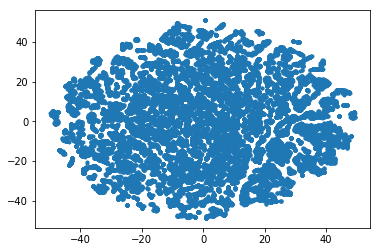

In [40]:
tsne = TSNE(n_jobs=-1)
Y = tsne.fit_transform(encoder_pred[:50000])
vis_x = Y[:, 0]
vis_y = Y[:, 1]
plt.scatter(vis_x, vis_y, marker='.')
plt.clim(-0.5, 9.5)
plt.show()

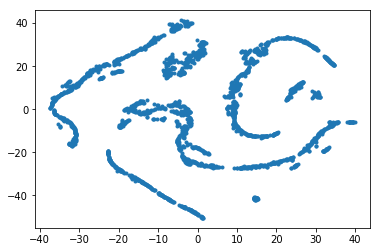

In [267]:
tsne = TSNE(n_jobs=-1)
Y = tsne.fit_transform(np_matrix)
vis_x = Y[:, 0]
vis_y = Y[:, 1]
plt.scatter(vis_x, vis_y, marker='.')
plt.clim(-0.5, 9.5)
plt.show()

In [58]:
n_clusters = 10
kmeans = KMeans(n_clusters=10, n_init=20)
y_pred = kmeans.fit_predict(latent_space)

cluster_centres = kmeans.cluster_centers_

from collections import defaultdict
clusters_dict = defaultdict(list)
for i, clus in enumerate(y_pred):
    clusters_dict[clus].append(i)

In [59]:
autoencoder_pred.shape

(2345, 63)

In [60]:
display(autoencoder_pred.reshape(len(autoencoder_pred), 21, 3), clusters_dict, ids=range(10))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [61]:
display(x_train, clusters_dict, ids=range(10))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [ ]:
plot_history(history[-1])

In [42]:
pred = autoencoder.predict(x_train2)

In [44]:
pred.shape

(4690, 63)

In [45]:
display(pred.reshape(len(pred),21,3))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [45]:
decoded_streamlines = autoencoder.predict(X)
decoded_streamlines = decoded_streamlines.reshape(len(decoded_streamlines), 21, 3)
encoded_streamlines = encoder.predict(X)
#reconstructed_img=decoder.predict(encoded_img)

In [46]:
print(decoded_streamlines.shape)
print(encoded_streamlines.shape)

(445903, 21, 3)
(445903, 100)


In [47]:
compare(x_train, pred.reshape(len(pred),21,3), 10, one_by_one=True)  

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


#### Clustering

In [76]:
autoencoder = sequence_autoencoder
encoder = sequence_encoder

In [77]:
n_clusters = 324
#encoder_pred = encoder.predict(X)
#autoencoder_pred = autoencoder.predict(X)

In [78]:
encoder_pred.shape

(222951, 21)

In [79]:
autoencoder_pred.shape

(222951, 21, 3)

In [53]:
# update encoder, decoder
# TODO: is this needed? Might be redundant...
'''
print('Updating encoder, decoder')
for i in range(len(encoder.layers)):
    encoder.layers[i].set_weights(autoencoder.layers[i].get_weights())
'''
# initialize cluster centres using k-means
print('Initializing cluster centres with k-means.')
# 20 reinicios de kmeans para quedarse con la mejor solucion
kmeans = KMeans(n_clusters=n_clusters, n_init=1, verbose=1)
y_pred = kmeans.fit_predict(encoder_pred)

cluster_centres = kmeans.cluster_centers_

Initializing cluster centres with k-means.
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 8141.9653
start iteration
done sorting
end inner loop
Iteration 1, inertia 7635.9976
start iteration
done sorting
end inner loop
Iteration 2, inertia 7493.366
start iteration
done sorting
end inner loop
Iteration 3, inertia 7418.909
start iteration
done sorting
end inner loop
Iteration 4, inertia 7375.296
start iteration
done sorting
end inner loop
Iteration 5, inertia 7346.1772
start iteration
done sorting
end inner loop
Iteration 6, inertia 7326.5635
start iteration
done sorting
end inner loop
Iteration 7, inertia 7313.207
start iteration
done sorting
end inner loop
Iteration 8, inertia 7304.5903
start iteration
done sorting
end inner loop
Iteration 9, inertia 7297.3086
start iteration
done sorting
end inner loop
Iteration 10, inertia 7288.6094
start iteration
done sorting
end inner loop
Iteration 11, inertia 7279.093
start iteration
done sorting
end inn

In [54]:
cluster_centres.shape

(324, 21)

In [69]:
encoder = sequence_encoder

In [86]:
# prepare DEC model
DEC = Sequential([encoder, ClusteringLayer(n_clusters,
                                          weights=cluster_centres,
                                          name='clustering')
                 ])
DEC.compile(loss='kullback_leibler_divergence', optimizer='adadelta', metrics=['acc'])

In [88]:
DEC.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 21)                224568    
_________________________________________________________________
clustering (ClusteringLayer) (None, 324)               6804      
Total params: 231,372
Trainable params: 231,372
Non-trainable params: 0
_________________________________________________________________


In [90]:
X = x_train

In [114]:
tol=0.01
iter_max=1500
batch_size=1024
update_interval = X.shape[0]/batch_size
print('Update interval', update_interval)
save_interval = X.shape[0]/batch_size*50
print('Save interval', save_interval)

assert save_interval >= update_interval

train = True
iteration, index = 0, 0
metrics = []
while train:
    # cutoff iteration
    if iter_max < iteration:
        print('Reached maximum iteration limit. Stopping training.')
        break

    # update (or initialize) probability distributions and propagate weight changes
    # from DEC model to encoder.
    if iteration % update_interval == 0:
        print("*", iteration)
        q = DEC.predict(X, verbose=0)
        p = p_mat(q)

        curr_y_pred = q.argmax(1)
        delta_label = ((curr_y_pred == y_pred).sum().astype(np.float32) / curr_y_pred.shape[0])

        print(str(np.round(delta_label*100, 5))+'% change in label assignment')

        if delta_label < tol:
            print('Reached tolerance threshold. Stopping training.')
            train = False
            continue
        else:
            y_pred = curr_y_pred

        for i in range(len(encoder.layers)):
            encoder.layers[i].set_weights(DEC.layers[0].layers[i].get_weights())
        cluster_centres = DEC.layers[-1].get_weights()[0]

    # train on batch
    print('Iteration %d, ' % iteration)
    if (index+1)*batch_size > X.shape[0]:
        loss = DEC.train_on_batch(X[index*batch_size::], p[index*batch_size::])
        index = 0
        metrics.append([loss[0], loss[1]])
        #sys.stdout.write('Loss %f' % loss)
        print('loss:', loss[0], 'acc:', loss[1])
    else:
        print(X[index*batch_size:(index+1) * batch_size].shape)
        print(p[index*batch_size:(index+1) * batch_size].shape)
        loss = DEC.train_on_batch(X[index*batch_size:(index+1) * batch_size],
                                       p[index*batch_size:(index+1) * batch_size])
        #sys.stdout.write('Loss %f' % loss)
        print('loss:', loss[0], 'acc:', loss[1])
        metrics.append([loss[0], loss[1]])
        index += 1

    # save intermediate
    if iteration % save_interval == 0:
        z = encoder.predict(X)
        pca = PCA(n_components=2).fit(z)
        z_2d = pca.transform(z)
        clust_2d = pca.transform(cluster_centres)
        # save states for visualization
        pickle.dump({'z_2d': z_2d, 'clust_2d': clust_2d, 'q': q, 'p': p},
                    open('c'+str(iteration)+'.pkl', 'wb'))
        # save DEC model checkpoints
        DEC.save('DEC_model_'+str(iteration)+'.h5')

    iteration += 1

Update interval 217.7255859375
Save interval 10886.279296875
* 0
61.39331% change in label assignment
Iteration 0, 
(1024, 21, 3)
(1024, 324)
loss: 0.0686153 acc: 0.83203125
Iteration 1, 
(1024, 21, 3)
(1024, 324)
loss: 0.06805314 acc: 0.7138672
Iteration 2, 
(1024, 21, 3)
(1024, 324)
loss: 0.072521046 acc: 0.5810547
Iteration 3, 
(1024, 21, 3)
(1024, 324)
loss: 0.079741195 acc: 0.44335938
Iteration 4, 
(1024, 21, 3)
(1024, 324)
loss: 0.09069621 acc: 0.32617188
Iteration 5, 
(1024, 21, 3)
(1024, 324)
loss: 0.091210976 acc: 0.3623047
Iteration 6, 
(1024, 21, 3)
(1024, 324)
loss: 0.08613624 acc: 0.33984375
Iteration 7, 
(1024, 21, 3)
(1024, 324)
loss: 0.080774054 acc: 0.39746094
Iteration 8, 
(1024, 21, 3)
(1024, 324)
loss: 0.07931019 acc: 0.40722656
Iteration 9, 
(1024, 21, 3)
(1024, 324)
loss: 0.07969001 acc: 0.4169922
Iteration 10, 
(1024, 21, 3)
(1024, 324)
loss: 0.07854734 acc: 0.4140625
Iteration 11, 
(1024, 21, 3)
(1024, 324)
loss: 0.080094956 acc: 0.41503906
Iteration 12, 
(1024,

loss: 0.059775487 acc: 0.6357422
Iteration 111, 
(1024, 21, 3)
(1024, 324)
loss: 0.059229888 acc: 0.6142578
Iteration 112, 
(1024, 21, 3)
(1024, 324)
loss: 0.05977087 acc: 0.59472656
Iteration 113, 
(1024, 21, 3)
(1024, 324)
loss: 0.06053795 acc: 0.6123047
Iteration 114, 
(1024, 21, 3)
(1024, 324)
loss: 0.060387406 acc: 0.61035156
Iteration 115, 
(1024, 21, 3)
(1024, 324)
loss: 0.05953662 acc: 0.61621094
Iteration 116, 
(1024, 21, 3)
(1024, 324)
loss: 0.059483454 acc: 0.61621094
Iteration 117, 
(1024, 21, 3)
(1024, 324)
loss: 0.06010447 acc: 0.6503906
Iteration 118, 
(1024, 21, 3)
(1024, 324)
loss: 0.06045802 acc: 0.6152344
Iteration 119, 
(1024, 21, 3)
(1024, 324)
loss: 0.06010402 acc: 0.6328125
Iteration 120, 
(1024, 21, 3)
(1024, 324)
loss: 0.059341416 acc: 0.62402344
Iteration 121, 
(1024, 21, 3)
(1024, 324)
loss: 0.059036516 acc: 0.6376953
Iteration 122, 
(1024, 21, 3)
(1024, 324)
loss: 0.05948468 acc: 0.5986328
Iteration 123, 
(1024, 21, 3)
(1024, 324)
loss: 0.05821596 acc: 0.629

loss: 0.052120633 acc: 0.60839844
Iteration 221, 
(1024, 21, 3)
(1024, 324)
loss: 0.0514668 acc: 0.63964844
Iteration 222, 
(1024, 21, 3)
(1024, 324)
loss: 0.05220563 acc: 0.609375
Iteration 223, 
(1024, 21, 3)
(1024, 324)
loss: 0.053951405 acc: 0.61328125
Iteration 224, 
(1024, 21, 3)
(1024, 324)
loss: 0.05252219 acc: 0.5996094
Iteration 225, 
(1024, 21, 3)
(1024, 324)
loss: 0.05250316 acc: 0.61035156
Iteration 226, 
(1024, 21, 3)
(1024, 324)
loss: 0.052239895 acc: 0.64453125
Iteration 227, 
(1024, 21, 3)
(1024, 324)
loss: 0.054000422 acc: 0.5878906
Iteration 228, 
(1024, 21, 3)
(1024, 324)
loss: 0.05256844 acc: 0.6220703
Iteration 229, 
(1024, 21, 3)
(1024, 324)
loss: 0.053116735 acc: 0.62890625
Iteration 230, 
(1024, 21, 3)
(1024, 324)
loss: 0.053015843 acc: 0.5839844
Iteration 231, 
(1024, 21, 3)
(1024, 324)
loss: 0.053765193 acc: 0.5908203
Iteration 232, 
(1024, 21, 3)
(1024, 324)
loss: 0.053868175 acc: 0.58496094
Iteration 233, 
(1024, 21, 3)
(1024, 324)
loss: 0.054631397 acc: 0.

loss: 0.047572806 acc: 0.57128906
Iteration 331, 
(1024, 21, 3)
(1024, 324)
loss: 0.04818953 acc: 0.61328125
Iteration 332, 
(1024, 21, 3)
(1024, 324)
loss: 0.048120297 acc: 0.5830078
Iteration 333, 
(1024, 21, 3)
(1024, 324)
loss: 0.047574654 acc: 0.6201172
Iteration 334, 
(1024, 21, 3)
(1024, 324)
loss: 0.047489308 acc: 0.58496094
Iteration 335, 
(1024, 21, 3)
(1024, 324)
loss: 0.04796624 acc: 0.6220703
Iteration 336, 
(1024, 21, 3)
(1024, 324)
loss: 0.048087925 acc: 0.5839844
Iteration 337, 
(1024, 21, 3)
(1024, 324)
loss: 0.04810688 acc: 0.60253906
Iteration 338, 
(1024, 21, 3)
(1024, 324)
loss: 0.047453888 acc: 0.5986328
Iteration 339, 
(1024, 21, 3)
(1024, 324)
loss: 0.04733356 acc: 0.61621094
Iteration 340, 
(1024, 21, 3)
(1024, 324)
loss: 0.047540247 acc: 0.5732422
Iteration 341, 
(1024, 21, 3)
(1024, 324)
loss: 0.04643009 acc: 0.6201172
Iteration 342, 
(1024, 21, 3)
(1024, 324)
loss: 0.0461739 acc: 0.5878906
Iteration 343, 
(1024, 21, 3)
(1024, 324)
loss: 0.046297237 acc: 0.60

loss: 0.04579169 acc: 0.56347656
Iteration 442, 
(1024, 21, 3)
(1024, 324)
loss: 0.04423789 acc: 0.6113281
Iteration 443, 
(1024, 21, 3)
(1024, 324)
loss: 0.04323487 acc: 0.60839844
Iteration 444, 
(1024, 21, 3)
(1024, 324)
loss: 0.04320094 acc: 0.6044922
Iteration 445, 
(1024, 21, 3)
(1024, 324)
loss: 0.044438288 acc: 0.5917969
Iteration 446, 
(1024, 21, 3)
(1024, 324)
loss: 0.043369293 acc: 0.6230469
Iteration 447, 
(1024, 21, 3)
(1024, 324)
loss: 0.043934844 acc: 0.60253906
Iteration 448, 
(1024, 21, 3)
(1024, 324)
loss: 0.044156786 acc: 0.5449219
Iteration 449, 
(1024, 21, 3)
(1024, 324)
loss: 0.044483818 acc: 0.5595703
Iteration 450, 
(1024, 21, 3)
(1024, 324)
loss: 0.044421595 acc: 0.5859375
Iteration 451, 
(1024, 21, 3)
(1024, 324)
loss: 0.045180004 acc: 0.57714844
Iteration 452, 
(1024, 21, 3)
(1024, 324)
loss: 0.04371243 acc: 0.5605469
Iteration 453, 
(1024, 21, 3)
(1024, 324)
loss: 0.04329037 acc: 0.59375
Iteration 454, 
(1024, 21, 3)
(1024, 324)
loss: 0.04406087 acc: 0.60058

loss: 0.03994622 acc: 0.609375
Iteration 552, 
(1024, 21, 3)
(1024, 324)
loss: 0.04018504 acc: 0.6035156
Iteration 553, 
(1024, 21, 3)
(1024, 324)
loss: 0.04049752 acc: 0.58984375
Iteration 554, 
(1024, 21, 3)
(1024, 324)
loss: 0.040150125 acc: 0.63671875
Iteration 555, 
(1024, 21, 3)
(1024, 324)
loss: 0.039938632 acc: 0.6220703
Iteration 556, 
(1024, 21, 3)
(1024, 324)
loss: 0.039560854 acc: 0.640625
Iteration 557, 
(1024, 21, 3)
(1024, 324)
loss: 0.039302565 acc: 0.6171875
Iteration 558, 
(1024, 21, 3)
(1024, 324)
loss: 0.039521158 acc: 0.6826172
Iteration 559, 
(1024, 21, 3)
(1024, 324)
loss: 0.03826563 acc: 0.60058594
Iteration 560, 
(1024, 21, 3)
(1024, 324)
loss: 0.03854764 acc: 0.6455078
Iteration 561, 
(1024, 21, 3)
(1024, 324)
loss: 0.03856212 acc: 0.6044922
Iteration 562, 
(1024, 21, 3)
(1024, 324)
loss: 0.039238147 acc: 0.6621094
Iteration 563, 
(1024, 21, 3)
(1024, 324)
loss: 0.039077483 acc: 0.60839844
Iteration 564, 
(1024, 21, 3)
(1024, 324)
loss: 0.038395744 acc: 0.6650

loss: 0.036495715 acc: 0.6113281
Iteration 662, 
(1024, 21, 3)
(1024, 324)
loss: 0.03648937 acc: 0.6201172
Iteration 663, 
(1024, 21, 3)
(1024, 324)
loss: 0.03755039 acc: 0.5957031
Iteration 664, 
(1024, 21, 3)
(1024, 324)
loss: 0.036666475 acc: 0.6435547
Iteration 665, 
(1024, 21, 3)
(1024, 324)
loss: 0.0373428 acc: 0.5996094
Iteration 666, 
(1024, 21, 3)
(1024, 324)
loss: 0.037584383 acc: 0.58984375
Iteration 667, 
(1024, 21, 3)
(1024, 324)
loss: 0.03798121 acc: 0.56640625
Iteration 668, 
(1024, 21, 3)
(1024, 324)
loss: 0.037948407 acc: 0.60839844
Iteration 669, 
(1024, 21, 3)
(1024, 324)
loss: 0.038795866 acc: 0.57421875
Iteration 670, 
(1024, 21, 3)
(1024, 324)
loss: 0.03743176 acc: 0.578125
Iteration 671, 
(1024, 21, 3)
(1024, 324)
loss: 0.037178915 acc: 0.58691406
Iteration 672, 
(1024, 21, 3)
(1024, 324)
loss: 0.037771244 acc: 0.6142578
Iteration 673, 
(1024, 21, 3)
(1024, 324)
loss: 0.03702502 acc: 0.59765625
Iteration 674, 
(1024, 21, 3)
(1024, 324)
loss: 0.03705359 acc: 0.655

loss: 0.034888647 acc: 0.57714844
Iteration 772, 
(1024, 21, 3)
(1024, 324)
loss: 0.03448455 acc: 0.64160156
Iteration 773, 
(1024, 21, 3)
(1024, 324)
loss: 0.03430725 acc: 0.61621094
Iteration 774, 
(1024, 21, 3)
(1024, 324)
loss: 0.033978708 acc: 0.63671875
Iteration 775, 
(1024, 21, 3)
(1024, 324)
loss: 0.03375672 acc: 0.60058594
Iteration 776, 
(1024, 21, 3)
(1024, 324)
loss: 0.033868726 acc: 0.6904297
Iteration 777, 
(1024, 21, 3)
(1024, 324)
loss: 0.032782227 acc: 0.60058594
Iteration 778, 
(1024, 21, 3)
(1024, 324)
loss: 0.033067502 acc: 0.64941406
Iteration 779, 
(1024, 21, 3)
(1024, 324)
loss: 0.03306725 acc: 0.6015625
Iteration 780, 
(1024, 21, 3)
(1024, 324)
loss: 0.03354192 acc: 0.6669922
Iteration 781, 
(1024, 21, 3)
(1024, 324)
loss: 0.03353049 acc: 0.6152344
Iteration 782, 
(1024, 21, 3)
(1024, 324)
loss: 0.03289886 acc: 0.6660156
Iteration 783, 
(1024, 21, 3)
(1024, 324)
loss: 0.03300599 acc: 0.58984375
Iteration 784, 
(1024, 21, 3)
(1024, 324)
loss: 0.0326977 acc: 0.64

loss: 0.032430366 acc: 0.59375
Iteration 882, 
(1024, 21, 3)
(1024, 324)
loss: 0.03160228 acc: 0.671875
Iteration 883, 
(1024, 21, 3)
(1024, 324)
loss: 0.032169323 acc: 0.6035156
Iteration 884, 
(1024, 21, 3)
(1024, 324)
loss: 0.032196812 acc: 0.63671875
Iteration 885, 
(1024, 21, 3)
(1024, 324)
loss: 0.032556336 acc: 0.5761719
Iteration 886, 
(1024, 21, 3)
(1024, 324)
loss: 0.03275416 acc: 0.6308594
Iteration 887, 
(1024, 21, 3)
(1024, 324)
loss: 0.033700727 acc: 0.5625
Iteration 888, 
(1024, 21, 3)
(1024, 324)
loss: 0.032624625 acc: 0.60253906
Iteration 889, 
(1024, 21, 3)
(1024, 324)
loss: 0.032686997 acc: 0.5830078
Iteration 890, 
(1024, 21, 3)
(1024, 324)
loss: 0.033137456 acc: 0.62109375
Iteration 891, 
(1024, 21, 3)
(1024, 324)
loss: 0.032395434 acc: 0.57910156
Iteration 892, 
(1024, 21, 3)
(1024, 324)
loss: 0.032340333 acc: 0.6591797
Iteration 893, 
(1024, 21, 3)
(1024, 324)
loss: 0.03176417 acc: 0.60058594
Iteration 894, 
(1024, 21, 3)
(1024, 324)
loss: 0.031744927 acc: 0.6308

loss: 0.029726036 acc: 0.6748047
Iteration 992, 
(1024, 21, 3)
(1024, 324)
loss: 0.029292315 acc: 0.62402344
Iteration 993, 
(1024, 21, 3)
(1024, 324)
loss: 0.029012969 acc: 0.7001953
Iteration 994, 
(1024, 21, 3)
(1024, 324)
loss: 0.029110966 acc: 0.62597656
Iteration 995, 
(1024, 21, 3)
(1024, 324)
loss: 0.028477425 acc: 0.7011719
Iteration 996, 
(1024, 21, 3)
(1024, 324)
loss: 0.028729813 acc: 0.62890625
Iteration 997, 
(1024, 21, 3)
(1024, 324)
loss: 0.02897847 acc: 0.6621094
Iteration 998, 
(1024, 21, 3)
(1024, 324)
loss: 0.029247984 acc: 0.6044922
Iteration 999, 
(1024, 21, 3)
(1024, 324)
loss: 0.029430306 acc: 0.6845703
Iteration 1000, 
(1024, 21, 3)
(1024, 324)
loss: 0.02890306 acc: 0.63183594
Iteration 1001, 
(1024, 21, 3)
(1024, 324)
loss: 0.029159479 acc: 0.67285156
Iteration 1002, 
(1024, 21, 3)
(1024, 324)
loss: 0.029032098 acc: 0.6191406
Iteration 1003, 
(1024, 21, 3)
(1024, 324)
loss: 0.02970748 acc: 0.6435547
Iteration 1004, 
(1024, 21, 3)
(1024, 324)
loss: 0.029590044 

loss: 0.027910441 acc: 0.64160156
Iteration 1101, 
(1024, 21, 3)
(1024, 324)
loss: 0.02838907 acc: 0.5878906
Iteration 1102, 
(1024, 21, 3)
(1024, 324)
loss: 0.028427863 acc: 0.62402344
Iteration 1103, 
(1024, 21, 3)
(1024, 324)
loss: 0.02864313 acc: 0.57421875
Iteration 1104, 
(1024, 21, 3)
(1024, 324)
loss: 0.029078111 acc: 0.6171875
Iteration 1105, 
(1024, 21, 3)
(1024, 324)
loss: 0.029781096 acc: 0.54589844
Iteration 1106, 
(1024, 21, 3)
(1024, 324)
loss: 0.028839909 acc: 0.5986328
Iteration 1107, 
(1024, 21, 3)
(1024, 324)
loss: 0.02894871 acc: 0.55859375
Iteration 1108, 
(1024, 21, 3)
(1024, 324)
loss: 0.02930338 acc: 0.6171875
Iteration 1109, 
(1024, 21, 3)
(1024, 324)
loss: 0.02863971 acc: 0.57128906
Iteration 1110, 
(1024, 21, 3)
(1024, 324)
loss: 0.028649334 acc: 0.6513672
Iteration 1111, 
(1024, 21, 3)
(1024, 324)
loss: 0.02807079 acc: 0.60058594
Iteration 1112, 
(1024, 21, 3)
(1024, 324)
loss: 0.028136466 acc: 0.62890625
Iteration 1113, 
(1024, 21, 3)
(1024, 324)
loss: 0.02

loss: 0.027024962 acc: 0.6279297
Iteration 1209, 
(1024, 21, 3)
(1024, 324)
loss: 0.027013637 acc: 0.6152344
Iteration 1210, 
(1024, 21, 3)
(1024, 324)
loss: 0.026795484 acc: 0.62597656
Iteration 1211, 
(1024, 21, 3)
(1024, 324)
loss: 0.026603179 acc: 0.5917969
Iteration 1212, 
(1024, 21, 3)
(1024, 324)
loss: 0.026639454 acc: 0.6699219
Iteration 1213, 
(1024, 21, 3)
(1024, 324)
loss: 0.025742784 acc: 0.5761719
Iteration 1214, 
(1024, 21, 3)
(1024, 324)
loss: 0.026049187 acc: 0.62597656
Iteration 1215, 
(1024, 21, 3)
(1024, 324)
loss: 0.025976975 acc: 0.5810547
Iteration 1216, 
(1024, 21, 3)
(1024, 324)
loss: 0.02617183 acc: 0.63183594
Iteration 1217, 
(1024, 21, 3)
(1024, 324)
loss: 0.026460249 acc: 0.5888672
Iteration 1218, 
(1024, 21, 3)
(1024, 324)
loss: 0.026032353 acc: 0.6298828
Iteration 1219, 
(1024, 21, 3)
(1024, 324)
loss: 0.026083905 acc: 0.5966797
Iteration 1220, 
(1024, 21, 3)
(1024, 324)
loss: 0.025648668 acc: 0.62109375
Iteration 1221, 
(1024, 21, 3)
(1024, 324)
loss: 0.0

loss: 0.026063748 acc: 0.6269531
Iteration 1318, 
(1024, 21, 3)
(1024, 324)
loss: 0.025176935 acc: 0.640625
Iteration 1319, 
(1024, 21, 3)
(1024, 324)
loss: 0.025604034 acc: 0.64453125
Iteration 1320, 
(1024, 21, 3)
(1024, 324)
loss: 0.025548752 acc: 0.5878906
Iteration 1321, 
(1024, 21, 3)
(1024, 324)
loss: 0.025795057 acc: 0.63378906
Iteration 1322, 
(1024, 21, 3)
(1024, 324)
loss: 0.026002457 acc: 0.5966797
Iteration 1323, 
(1024, 21, 3)
(1024, 324)
loss: 0.026451241 acc: 0.65722656
Iteration 1324, 
(1024, 21, 3)
(1024, 324)
loss: 0.025464498 acc: 0.5859375
Iteration 1325, 
(1024, 21, 3)
(1024, 324)
loss: 0.02550842 acc: 0.6582031
Iteration 1326, 
(1024, 21, 3)
(1024, 324)
loss: 0.025908982 acc: 0.58984375
Iteration 1327, 
(1024, 21, 3)
(1024, 324)
loss: 0.025463622 acc: 0.6542969
Iteration 1328, 
(1024, 21, 3)
(1024, 324)
loss: 0.025710106 acc: 0.61328125
Iteration 1329, 
(1024, 21, 3)
(1024, 324)
loss: 0.024969397 acc: 0.64453125
Iteration 1330, 
(1024, 21, 3)
(1024, 324)
loss: 0.

loss: 0.024481114 acc: 0.6660156
Iteration 1426, 
(1024, 21, 3)
(1024, 324)
loss: 0.024307303 acc: 0.6308594
Iteration 1427, 
(1024, 21, 3)
(1024, 324)
loss: 0.024106853 acc: 0.6660156
Iteration 1428, 
(1024, 21, 3)
(1024, 324)
loss: 0.023740066 acc: 0.6123047
Iteration 1429, 
(1024, 21, 3)
(1024, 324)
loss: 0.023593139 acc: 0.6748047
Iteration 1430, 
(1024, 21, 3)
(1024, 324)
loss: 0.02360656 acc: 0.6220703
Iteration 1431, 
(1024, 21, 3)
(1024, 324)
loss: 0.023132121 acc: 0.69433594
Iteration 1432, 
(1024, 21, 3)
(1024, 324)
loss: 0.023377728 acc: 0.6191406
Iteration 1433, 
(1024, 21, 3)
(1024, 324)
loss: 0.023583394 acc: 0.64941406
Iteration 1434, 
(1024, 21, 3)
(1024, 324)
loss: 0.023667319 acc: 0.5996094
Iteration 1435, 
(1024, 21, 3)
(1024, 324)
loss: 0.023933358 acc: 0.66308594
Iteration 1436, 
(1024, 21, 3)
(1024, 324)
loss: 0.023438858 acc: 0.60546875
Iteration 1437, 
(1024, 21, 3)
(1024, 324)
loss: 0.023665735 acc: 0.65234375
Iteration 1438, 
(1024, 21, 3)
(1024, 324)
loss: 0.

In [99]:
len(metrics)

501

In [100]:
cluster_centres.shape

(324, 21)

In [115]:
acc = []
loss = []
for metric in metrics:
    acc.append(metric[1])
    loss.append(metric[0])

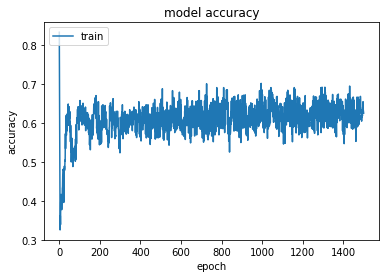

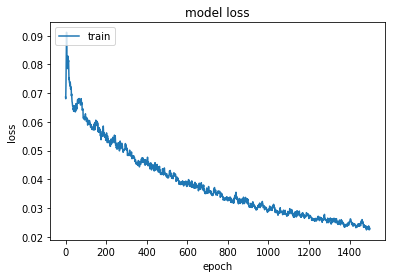

In [116]:
# summarize history for accuracy
plt.plot(acc)
#plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
#plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [108]:
latent_space = encoder.predict(x_train.reshape(len(x_train),63))

In [105]:
m = pairwise_matrix(autoencoder_pred)
np_matrix = np.array(m, dtype='double')

In [121]:
m = pairwise_matrix2(latent_space)
np_matrix = np.array(m, dtype='double')

In [122]:
import hdbscan
from collections import defaultdict
clusterer = hdbscan.HDBSCAN(metric='precomputed',min_cluster_size=60)#, min_samples=1, min_cluster_size=5)
clusterer.fit(np_matrix)
#from collections import defaultdict
clusters_dict = defaultdict(list)
for i, clus in enumerate(clusterer.labels_):
    clusters_dict[clus].append(i)

In [117]:
from collections import defaultdict
clusters_dict = defaultdict(list)
for i, clus in enumerate(y_pred):
    clusters_dict[clus].append(i)
len(set(clusters_dict.keys()))

301

In [119]:
display(x_train, clusters_dict, ids=range(len(set(clusters_dict.keys()))))

/home/miguel/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [151]:
latent_space[19].shape

(100,)

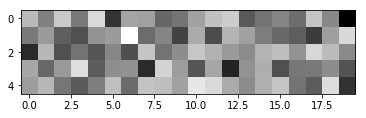

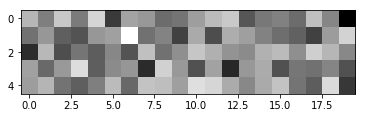

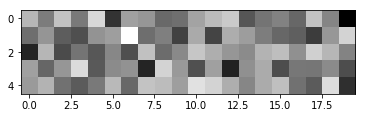

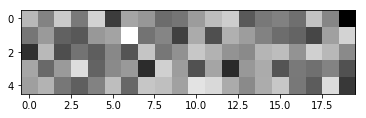

In [171]:
plt.imshow(latent_space[19].reshape(5,20), cmap="gray")
plt.show()
plt.imshow(latent_space[21].reshape(5,20), cmap="gray")
plt.show()
plt.imshow(latent_space[27].reshape(5,20), cmap="gray")
plt.show()
plt.imshow(new_latent.reshape(5,20), cmap="gray")
plt.show()

In [167]:
new_fiber = np.flip(x_train[29], axis=0)

In [168]:
new_fiber

array([[0.44095767, 0.61918783, 0.7643117 ],
       [0.42991886, 0.5921827 , 0.72266144],
       [0.42137656, 0.5725194 , 0.69004405],
       [0.4124232 , 0.56161773, 0.6528356 ],
       [0.39964432, 0.5600544 , 0.6143687 ],
       [0.39087632, 0.56091285, 0.5747868 ],
       [0.37743887, 0.55604345, 0.5374353 ],
       [0.35774294, 0.5494862 , 0.5031259 ],
       [0.33721963, 0.54823035, 0.468619  ],
       [0.32296145, 0.5568171 , 0.4323577 ],
       [0.31525713, 0.5683598 , 0.39462203],
       [0.315556  , 0.5796879 , 0.35599646],
       [0.3116697 , 0.5922266 , 0.31836736],
       [0.30778202, 0.60699725, 0.28169608],
       [0.31248415, 0.6243832 , 0.24669024],
       [0.3230728 , 0.64090425, 0.2126084 ],
       [0.3379559 , 0.6484154 , 0.17620648],
       [0.3590802 , 0.6555033 , 0.14307426],
       [0.3752162 , 0.6656119 , 0.10827203],
       [0.38290337, 0.6681599 , 0.06834553],
       [0.3893812 , 0.6710064 , 0.02821047]], dtype=float32)

In [170]:
new_latent = encoder.predict(new_fiber.reshape(1,63))